<a href="https://colab.research.google.com/github/gyanendar/ms_project/blob/main/RIM_ONE_DL_CROSSFOLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Headers

In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from IPython.display import display
from keras.layers import Dense, GlobalAveragePooling2D
#from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import KFold
from sklearn import metrics
import seaborn as sns

In [ ]:
import gc
gc.collect()

0

# Drives

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
RIM_ONE_DL_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/RIM-ONE_DL_images/partitioned_randomly'
SAVE_FILE = r'/content/gdrive/My Drive/MSC_Project/Model/CNN/generated_data/RIMONE_CROSSFOLD.csv'


In [ ]:
def initialise_df_perfromance_matrix():
  g_performance_df =  pd.DataFrame([], columns = ['Model', 'Accuracy','Sensitivity','AUC'])
  g_performance_df.to_csv(SAVE_FILE, encoding='utf-8', index=False)

In [ ]:
def save_performance_data(new_data):
  g_performance_df = pd.read_csv(SAVE_FILE)
  data_list = g_performance_df.values.tolist()
  data_exist = False
  for index in range(len(data_list)):
    if(data_list[index][0]==new_data[0]):
      data_list[index] = new_data
      data_exist = True
  if(data_exist==False):
    data_list.append(new_data)
  g_performance_df = pd.DataFrame(data_list, columns = ['Model', 'Accuracy','Sensitivity','AUC'])
  g_performance_df.to_csv(SAVE_FILE, encoding='utf-8', index=False)

In [ ]:
HEIGHT= 224
WIDTH = 224
BATCH_SIZE = 32
CLASS_COUNT = 2
NUM_EPOCHS_A = 50
NUM_EPOCHS_B = 50
g_performance = {}

# Dataset

In [ ]:
# Resize image to 256*256
# Convert to numpy array
def process_image(data_set_dir, label_dict, width, height):
    
    x = [] # will store images as arrays
    y = [] # store labels
    # list folders in directory
    directories = os.listdir(data_set_dir)
     
    # for each folder (train and validation) 
    for label in directories:
        
        # add class label to label dictionary
        if label not in label_dict:
            label_dict[label] = len(label_dict)
        
        # create full path for image directory 
        source_images = os.path.join(data_set_dir, label)
        images = os.listdir(source_images)
        # for each image in directory, 
        for image in images:
            #folder have .txt files which needs to be ignored
            if '.txt'not in image:
                # read the image from file, resize and add to a list
                full_size_image = cv2.imread(os.path.join(source_images, image))
                
                #append the image to x
                x.append(cv2.resize(full_size_image, (width,height), 
                                                            interpolation=cv2.INTER_CUBIC))
                # add the class label to y
                y.append(label)

   
    data = np.array(x, dtype="float") / 255.0                
    label = np.array(y)
    
    return data,label

In [ ]:
def get_rim_one_dl_dataset():
    class_labels = {}
    training_images,training_labels = process_image(RIM_ONE_DL_DIR+"/training_set",class_labels,WIDTH,HEIGHT)
    training_label = (pd.Series(training_labels).map(class_labels)).values
   

    test_images,test_labels = process_image(RIM_ONE_DL_DIR+"/test_set",class_labels,WIDTH,HEIGHT)
    test_label = (pd.Series(test_labels).map(class_labels)).values
    
    return training_images,training_label,test_images,test_label

In [ ]:
def set_seed():
  tf.random.set_seed(100)
  np.random.seed(100)
  random.seed(100)

**Callbacks**

In [ ]:


def get_early_stoping_cb_on_min_val_loss(patience_num = 6):
  return EarlyStopping(monitor='val_loss', mode='min', verbose=0, \
                       patience=patience_num)

def get_model_checkpoint_cb_on_max_val_acc(file_name):
  return ModelCheckpoint(file_name, monitor="val_accuracy", 	mode="max", \
                         save_best_only=True, verbose=1)	

def learning_rate_schedular_fun(epoch, lr):
  if epoch <100:
    return lr 
  else:
    return lr*tf.math.exp(-.1)
  
def get_model_learning_rate_cb():
  return tf.keras.callbacks.LearningRateScheduler(learning_rate_schedular_fun,\
                                                  verbose=0)


def get_basic_callback():
  return [get_early_stoping_cb_on_min_val_loss()]

def get_basic_and_lrs_callback():
  return [get_early_stoping_cb_on_min_val_loss(),get_model_learning_rate_cb()]

def get_all_callback(file_name):
  return [get_early_stoping_cb_on_min_val_loss(),\
          get_model_checkpoint_cb_on_max_val_acc(file_name)]

# Plots

In [ ]:
def plot_model_performance(history,model_name,part):
  plt.style.use("ggplot")
  plt.figure(figsize=(7,6))
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

  #Print best score 
 
  print("\nModel Performance Summary:\n")
  
  

  epoch_index = history.history["val_accuracy"].index(max(history.history["val_accuracy"]))
    
  best_val_accuracy = history.history["val_accuracy"][epoch_index]

  print(f"Best Validation accuracy:{best_val_accuracy} at EPOCH:{epoch_index+1}")

  
  
  #Store the above performance matrix
  #g_record_v1.add_entry(model_name,MODEL_PERFORMANCE(model_part = part, \
  #   val_acc = best_val_accuracy))

In [ ]:
def plot_ROC_AUC(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def plot_overall_performance():
  g_performance_df = pd.read_csv(SAVE_FILE)
  #data_list = g_performance_df.values.tolist()
  
  # for item in g_performance:
  #   data_list.append([item,g_performance[item][0],g_performance[item][1],g_performance[item][2]])
  #df = pd.DataFrame(data_list, columns = ['Model', 'Accuracy','Sensitivity','AUC'])
  display(g_performance_df)
  plt.figure()
  plot = sns.barplot(y='Model', x='Accuracy', data=g_performance_df)
  plt.show()
  print(g_performance_df.to_latex(index=False))

Get Pre-trained Model

In [ ]:
# Returns Pretrained Network with top layer removed
# And Trainable set to false

def get_high_level_model(trained_model_name,inputshape):
  set_seed()
  model = None
  if trained_model_name == "vgg16":
      model = tf.keras.applications.VGG16(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
      
  elif trained_model_name == "vgg19":
      model =  tf.keras.applications.VGG19(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
      
  elif trained_model_name == "resnet50":
     model = tf.keras.applications.ResNet50(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "xception":
     model = tf.keras.applications.Xception(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "DenseNet121":
     model = tf.keras.applications.DenseNet121(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  elif trained_model_name == "MobileNet":
     model = tf.keras.applications.MobileNet(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  elif trained_model_name == "MobileNetV2":
     model = tf.keras.applications.MobileNetV2(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  elif trained_model_name == "InceptionResNetV2":
     model = tf.keras.applications.InceptionResNetV2(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  elif trained_model_name == "InceptionV3":
     model = tf.keras.applications.InceptionV3(weights='imagenet', \
                            include_top = False, input_shape = inputshape)  
  elif trained_model_name == "NASNetMobile":
     model = tf.keras.applications.NASNetMobile(weights='imagenet', \
                            include_top = False, input_shape = inputshape)         
  
  if model != None:
    model.trainable = False

  return model

# MODEL

In [ ]:
class HIGH_LEVEL_MODEL:
  def __init__(self, trained_model_name,fold = 5, inputshape = (224,224,3)):

    set_seed()
    
    #Start constructing the model with pretrained network 
    self.model = tf.keras.models.Sequential(name = trained_model_name)
    
    # Get Pretrained model with top layer removed and trainable parameter frozen
    self.high_level_model_obj = get_high_level_model(trained_model_name, \
                                                     inputshape)
    self.model.add(self.high_level_model_obj)
    
    # Flatten the output and add FC & Softmax layer
    #self.model.add(tf.keras.layers.Flatten())
    self.model.add(tf.keras.layers.GlobalAveragePooling2D())
    
    #self.model.add(tf.keras.layers.Dense(512, activation='relu'))  
    self.model.add(tf.keras.layers.Dense(CLASS_COUNT, activation='softmax'))                             
    
    #Model is constructed Now
    print(self.model.summary())    
    
    #display(plot_model(self.model, show_shapes=True, expand_nested=True))
    
    # Setting Model JSON file and weight filte name 
    self.model_file_name = self.model.name+".json"
    self.fold_count = fold
    #display(plot_model(self.model, show_shapes=True, expand_nested=True))
    self.kfold = KFold(n_splits=self.fold_count, shuffle=True)
    # Setting Model JSON file and weight filte name 
    self.model_wt_file_name_a = []
    self.model_wt_file_name_b = []
    self.model_file_name = self.model.name+".json"
    for index in range(0,fold):
      self.model_wt_file_name_a.append(f"{self.model.name}_a_{index}.hdf5")
      self.model_wt_file_name_b.append(f"{self.model.name}_b_{index}.hdf5")
    self.model_wt_file_name =f"{self.model.name}_wt.hdf5"
    self.fold_accuracy_a = []
    self.fold_accuracy_b = []
    
    # To identify the variantion in parameter 
    #self.model_varient = varient

  def train_phase(self,train_x,train_y,test_x,test_y,data_aug=True):
    fold_itr = 0
    for train,validate in self.kfold.split(train_x,train_y):  
      print(f"Starting fold {fold_itr}")

      train_data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=30, fill_mode='nearest',zoom_range=0.2)
      if data_aug == False:
         train_data_generator = ImageDataGenerator()
      
      train_generator = train_data_generator.flow(train_x[train], train_y[train], batch_size=BATCH_SIZE)
   
      val_data_generator = ImageDataGenerator()
      val_generator = val_data_generator.flow(train_x[validate], train_y[validate], batch_size=BATCH_SIZE)

      self.model.compile(loss='sparse_categorical_crossentropy', \
          optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),metrics=['accuracy'])
    
      model_json = self.model.to_json()
      with open(self.model_file_name, "w") as json_file:
        json_file.write(model_json)

      history = self.model.fit(train_generator, epochs=NUM_EPOCHS_A, \
                   batch_size=BATCH_SIZE, validation_data=val_generator, \
                   callbacks = get_all_callback(self.model_wt_file_name_a[fold_itr]))        
      best_val_accuracy = max(history.history["val_accuracy"])
      self.fold_accuracy_a.append(best_val_accuracy)
      
      plot_model_performance(history,self.model.name,"phase_a"+str(fold_itr))

      self.model.load_weights(self.model_wt_file_name_a[fold_itr])
      self.high_level_model_obj.trainable = True

      optimizer_obj = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
      self.model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer_obj,
                metrics=['accuracy'])
    
      history = self.model.fit(train_generator, epochs=NUM_EPOCHS_B, \
                   batch_size=BATCH_SIZE, validation_data=val_generator, \
                   callbacks = get_all_callback(self.model_wt_file_name_b[fold_itr]))

      best_val_accuracy = max(history.history["val_accuracy"])
      self.fold_accuracy_b.append(best_val_accuracy)      
      plot_model_performance(history,self.model.name,"phase_b"+str(fold_itr))
      fold_itr = fold_itr + 1
      gc.collect()

    print(f"Average Accuracy:{sum(self.fold_accuracy_b)/len(self.fold_accuracy_b)}")
    print(" Training Model on full dataset")
    print(" Training Model with pretraned layer frozen")
    index= self.fold_accuracy_b.index(max(self.fold_accuracy_b))
    self.model.load_weights(self.model_wt_file_name_b[index])
    self.high_level_model_obj.trainable = False
    optimizer_obj = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
    self.model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer_obj,
                metrics=['accuracy'])
    
    train_data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=30, fill_mode='nearest',zoom_range=0.2)
    if data_aug == False:
       train_data_generator = ImageDataGenerator()

    train_generator = train_data_generator.flow(train_x, train_y, batch_size=BATCH_SIZE)
   
    val_data_generator = ImageDataGenerator()
    val_generator = val_data_generator.flow(test_x,test_y, batch_size=BATCH_SIZE)
    history = self.model.fit(train_generator, epochs=NUM_EPOCHS_B, \
                   batch_size=BATCH_SIZE, validation_data=val_generator, \
                   callbacks = get_all_callback(self.model_wt_file_name))
        
    plot_model_performance(history,self.model.name,"final")
    print(" Training Model with pretraned layer trainable")
    self.model.load_weights(self.model_wt_file_name)
    self.high_level_model_obj.trainable = True
    optimizer_obj = tf.keras.optimizers.RMSprop(learning_rate=2e-5)
    self.model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer_obj,
                metrics=['accuracy'])
    
    history = self.model.fit(train_generator, epochs=NUM_EPOCHS_B, \
                   batch_size=BATCH_SIZE, validation_data=val_generator, \
                   callbacks = get_all_callback(self.model_wt_file_name))
    
    self.model.load_weights(self.model_wt_file_name)
    
    predicted_val = self.model.predict(test_x,verbose = 1)
    self.y_classes = predicted_val.argmax(axis=-1)
    tn, fp, fn, tp = confusion_matrix(test_y, self.y_classes).ravel()
    final_accuracy = accuracy_score(test_y, self.y_classes)
    final_sensitivity=tp/(tp+fn)
    print("Accuracy:",final_accuracy)
    print("Sensitivity:",final_sensitivity)
    #self.fpr, self.tpr, _ = roc_curve(test_y, self.y_classes)
    #self.roc_auc = auc(self.fpr, self.tpr)
    #plot_ROC_AUC(self.fpr, self.tpr, self.roc_auc)     
    
    fpr, tpr, thresholds = metrics.roc_curve(test_y, self.y_classes)
    auc = metrics.auc(fpr, tpr)
    print(f"AUC:{auc}")
    
    save_performance_data([f"{self.model.name}_A_{data_aug}",final_accuracy,final_sensitivity,auc])
    
    #STEP A: 
    # Train the model with pre-trained network trainable parameter frozen
    # Get Validation accuracy
  def phase_a(self,train_x,train_y,optimizer_obj = tf.keras.optimizers.RMSprop(learning_rate=0.01)):
    print ("\n Phase A - Training Fully Connected Layers\n")
    
    fold_itr = 0
    for train,validate in self.kfold.split(train_x,train_y):

      train_data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=30, fill_mode='nearest',zoom_range=0.2,rescale=1.0/255)
      train_generator = train_data_generator.flow(train_x[train], train_y[train], batch_size=BATCH_SIZE)
   
      val_data_generator = ImageDataGenerator(rescale=1.0/255)
      val_generator = val_data_generator.flow(train_x[validate], train_y[validate], batch_size=BATCH_SIZE)
      

      self.model.compile(loss='sparse_categorical_crossentropy', \
          optimizer=optimizer_obj,metrics=['accuracy'])
    
      model_json = self.model.to_json()
      with open(self.model_file_name, "w") as json_file:
        json_file.write(model_json)

      history = self.model.fit(train_generator, epochs=NUM_EPOCHS_A, \
                   batch_size=BATCH_SIZE, validation_data=val_generator, \
                   callbacks = get_all_callback(self.model_wt_file_name_a[fold_itr]))
    
      best_val_accuracy = max(history.history["val_accuracy"])
      self.fold_accuracy_a.append(best_val_accuracy)
      fold_itr = fold_itr + 1
      plot_model_performance(history,self.model.name,"phase_a"+str(fold_itr))
  
    print(f"Best fold accurcay:{max(self.fold_accuracy_a)}")
  

    #STEP B:
    # make part of the pretrained model available for training
    # Train the model with low learning rate
    # Calculate the accuracy
  
  def phase_b(self,train_x,train_y):
    print ("\n Phase B  - Fine Tune Fully Connected Layer and \
                Selected Convolutional Layers \n")
    
    #model_index = self.fold_accuracy_a.index(max(self.fold_accuracy_a))

    fold_itr = 0
    for train,validate in self.kfold.split(train_x,train_y):

      train_data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=30, fill_mode='nearest',zoom_range=0.2,rescale=1.0/255)
      train_generator = train_data_generator.flow(train_x[train], train_y[train], batch_size=BATCH_SIZE)
   
      val_data_generator = ImageDataGenerator(rescale=1.0/255)
      val_generator = val_data_generator.flow(train_x[validate], train_y[validate], batch_size=BATCH_SIZE)

      self.model.load_weights(self.model_wt_file_name_a[fold_itr])
      self.high_level_model_obj.trainable = True

      optimizer_obj = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
      self.model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer_obj,
                metrics=['accuracy'])
    
      history = self.model.fit(train_generator, epochs=NUM_EPOCHS_B, \
                   batch_size=BATCH_SIZE, validation_data=val_generator, \
                   callbacks = get_all_callback(self.model_wt_file_name_b[fold_itr]))
    
      best_val_accuracy = max(history.history["val_accuracy"])
      self.fold_accuracy_b.append(best_val_accuracy)
      fold_itr = fold_itr + 1
      plot_model_performance(history,self.model.name,"phase_a"+str(fold_itr))
  
    print(f"Best fold accurcay:{max(self.fold_accuracy_b)}")

  def get_scores(self,test_x,test_y):

    #index= self.fold_accuracy_b.index(max(self.fold_accuracy_b))
    #self.model.load_weights(self.model_wt_file_name_b[index])
    self.model.load_weights(self.model_wt_file_name)
    optimizer_obj = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
    self.model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer_obj,
                metrics=['accuracy'])
    
    predicted_val = self.model.predict(test_x,verbose = 1)
    self.y_classes = predicted_val.argmax(axis=-1)
    tn, fp, fn, tp = confusion_matrix(test_y, self.y_classes).ravel()
    print("Accuracy:",accuracy_score(test_y, self.y_classes))
    print("Sensitivity:",tp/(tp+fn))
    self.fpr, self.tpr, _ = roc_curve(test_y, self.y_classes)
    self.roc_auc = auc(self.fpr, self.tpr)
    plot_ROC_AUC(self.fpr, self.tpr, self.roc_auc)  

Initialise Matrix

In [ ]:
# Run this onnce
initialise_df_perfromance_matrix()

Get DataSet

In [ ]:
training_images,training_label,test_images,test_label = get_rim_one_dl_dataset()

# Run 

VGG

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________
None
Starting fold 0
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.3542
Epoch 1: val_accuracy improved from -inf to 0.35294, saving model to vgg16_a_0.hdf5
9/9 [==============================] - 9s 644m

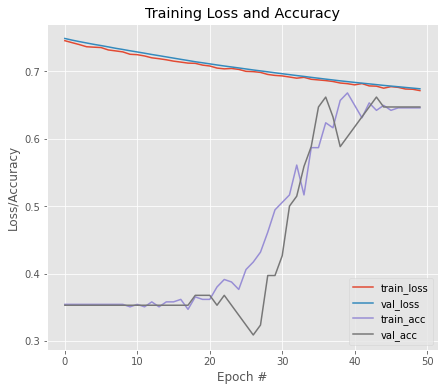


Model Performance Summary:

Best Validation accuracy:0.6617646813392639 at EPOCH:37
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.6494
Epoch 1: val_accuracy improved from -inf to 0.64706, saving model to vgg16_b_0.hdf5
9/9 [==============================] - 13s 845ms/step - loss: 0.6405 - accuracy: 0.6494 - val_loss: 0.6213 - val_accuracy: 0.6471
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.6716
Epoch 2: val_accuracy improved from 0.64706 to 0.66176, saving model to vgg16_b_0.hdf5
9/9 [==============================] - 5s 524ms/step - loss: 0.6167 - accuracy: 0.6716 - val_loss: 0.5996 - val_accuracy: 0.6618
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.6110 - accuracy: 0.7048
Epoch 3: val_accuracy improved from 0.66176 to 0.75000, saving model to vgg16_b_0.hdf5
9/9 [==============================] - 5s 527ms/step - loss: 0.6110 - accuracy: 0.7048 - val_loss: 0.5715 - val_accuracy: 

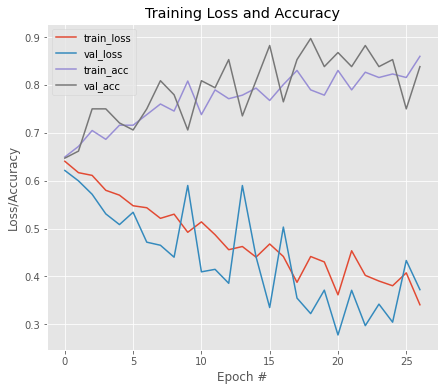


Model Performance Summary:

Best Validation accuracy:0.8970588445663452 at EPOCH:19
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.7269
Epoch 1: val_accuracy improved from -inf to 0.91176, saving model to vgg16_a_1.hdf5
9/9 [==============================] - 7s 542ms/step - loss: 0.5123 - accuracy: 0.7269 - val_loss: 0.2290 - val_accuracy: 0.9118
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.3417 - accuracy: 0.8266
Epoch 2: val_accuracy did not improve from 0.91176
9/9 [==============================] - 5s 480ms/step - loss: 0.3417 - accuracy: 0.8266 - val_loss: 0.2267 - val_accuracy: 0.9118
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.8266
Epoch 3: val_accuracy did not improve from 0.91176
9/9 [==============================] - 5s 480ms/step - loss: 0.3844 - accuracy: 0.8266 - val_loss: 0.4674 - val_accuracy: 0.7647
Epoch 4/50
9/9 [==============================] - 

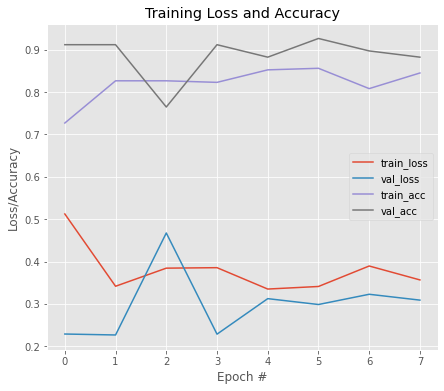


Model Performance Summary:

Best Validation accuracy:0.9264705777168274 at EPOCH:6
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.4230 - accuracy: 0.8303
Epoch 1: val_accuracy improved from -inf to 0.91176, saving model to vgg16_b_1.hdf5
9/9 [==============================] - 7s 554ms/step - loss: 0.4230 - accuracy: 0.8303 - val_loss: 0.2130 - val_accuracy: 0.9118
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.8561
Epoch 2: val_accuracy did not improve from 0.91176
9/9 [==============================] - 5s 485ms/step - loss: 0.2968 - accuracy: 0.8561 - val_loss: 0.1847 - val_accuracy: 0.9118
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8561
Epoch 3: val_accuracy improved from 0.91176 to 0.92647, saving model to vgg16_b_1.hdf5
9/9 [==============================] - 5s 520ms/step - loss: 0.3150 - accuracy: 0.8561 - val_loss: 0.1854 - val_accuracy: 0.9265
Epoch 4/50
9/9 [===============

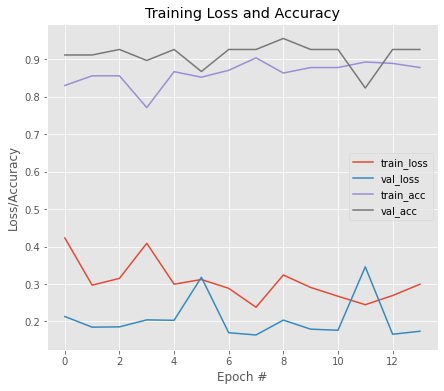


Model Performance Summary:

Best Validation accuracy:0.9558823704719543 at EPOCH:9
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3955 - accuracy: 0.9004
Epoch 1: val_accuracy improved from -inf to 0.86765, saving model to vgg16_a_2.hdf5
9/9 [==============================] - 6s 542ms/step - loss: 0.3955 - accuracy: 0.9004 - val_loss: 0.2657 - val_accuracy: 0.8676
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9188
Epoch 2: val_accuracy did not improve from 0.86765
9/9 [==============================] - 5s 488ms/step - loss: 0.2050 - accuracy: 0.9188 - val_loss: 0.2606 - val_accuracy: 0.8529
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9188
Epoch 3: val_accuracy did not improve from 0.86765
9/9 [==============================] - 5s 491ms/step - loss: 0.2074 - accuracy: 0.9188 - val_loss: 0.3226 - val_accuracy: 0.8382
Epoch 4/50
9/9 [==============================] - E

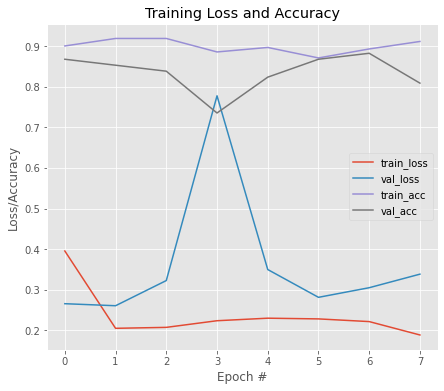


Model Performance Summary:

Best Validation accuracy:0.8823529481887817 at EPOCH:7
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.8561
Epoch 1: val_accuracy improved from -inf to 0.83824, saving model to vgg16_b_2.hdf5
9/9 [==============================] - 6s 539ms/step - loss: 0.3430 - accuracy: 0.8561 - val_loss: 0.2703 - val_accuracy: 0.8382
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.9188
Epoch 2: val_accuracy improved from 0.83824 to 0.86765, saving model to vgg16_b_2.hdf5
9/9 [==============================] - 5s 517ms/step - loss: 0.1890 - accuracy: 0.9188 - val_loss: 0.2390 - val_accuracy: 0.8676
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9225
Epoch 3: val_accuracy did not improve from 0.86765
9/9 [==============================] - 4s 516ms/step - loss: 0.1876 - accuracy: 0.9225 - val_loss: 0.2675 - val_accuracy: 0.8529
Epoch 4/50
9/9 [===============

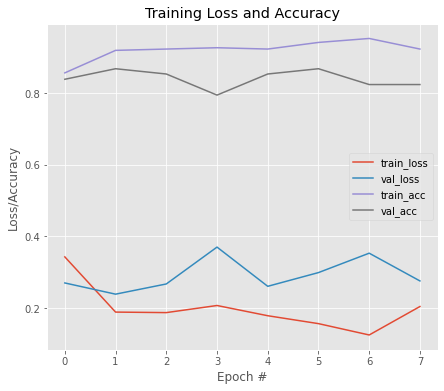


Model Performance Summary:

Best Validation accuracy:0.8676470518112183 at EPOCH:2
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.9225
Epoch 1: val_accuracy improved from -inf to 0.91176, saving model to vgg16_a_3.hdf5
9/9 [==============================] - 7s 543ms/step - loss: 0.3452 - accuracy: 0.9225 - val_loss: 0.1776 - val_accuracy: 0.9118
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.9077
Epoch 2: val_accuracy did not improve from 0.91176
9/9 [==============================] - 5s 481ms/step - loss: 0.2230 - accuracy: 0.9077 - val_loss: 0.1748 - val_accuracy: 0.9118
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9446
Epoch 3: val_accuracy did not improve from 0.91176
9/9 [==============================] - 5s 487ms/step - loss: 0.1608 - accuracy: 0.9446 - val_loss: 0.1688 - val_accuracy: 0.9118
Epoch 4/50
9/9 [==============================] - E

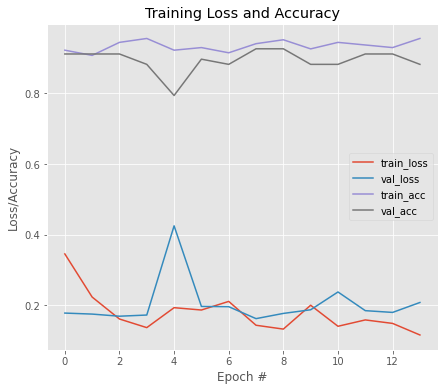


Model Performance Summary:

Best Validation accuracy:0.9264705777168274 at EPOCH:8
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.8856
Epoch 1: val_accuracy improved from -inf to 0.91176, saving model to vgg16_b_3.hdf5
9/9 [==============================] - 7s 546ms/step - loss: 0.3058 - accuracy: 0.8856 - val_loss: 0.1958 - val_accuracy: 0.9118
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9705
Epoch 2: val_accuracy did not improve from 0.91176
9/9 [==============================] - 5s 489ms/step - loss: 0.1186 - accuracy: 0.9705 - val_loss: 0.3401 - val_accuracy: 0.8676
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.8930
Epoch 3: val_accuracy did not improve from 0.91176
9/9 [==============================] - 5s 484ms/step - loss: 0.1987 - accuracy: 0.8930 - val_loss: 0.1999 - val_accuracy: 0.8824
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0

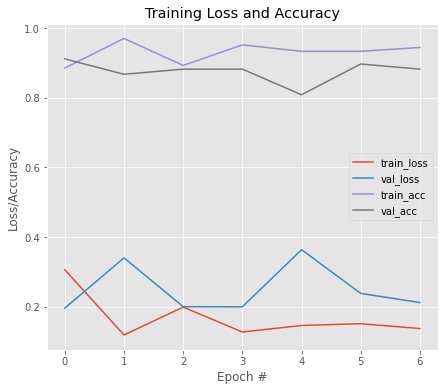


Model Performance Summary:

Best Validation accuracy:0.9117646813392639 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.8934
Epoch 1: val_accuracy improved from -inf to 0.98507, saving model to vgg16_a_4.hdf5
9/9 [==============================] - 11s 1s/step - loss: 0.2986 - accuracy: 0.8934 - val_loss: 0.0689 - val_accuracy: 0.9851
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9301
Epoch 2: val_accuracy did not improve from 0.98507
9/9 [==============================] - 5s 494ms/step - loss: 0.1729 - accuracy: 0.9301 - val_loss: 0.1199 - val_accuracy: 0.9552
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9522
Epoch 3: val_accuracy did not improve from 0.98507
9/9 [==============================] - 5s 499ms/step - loss: 0.1294 - accuracy: 0.9522 - val_loss: 0.0816 - val_accuracy: 0.9851
Epoch 4/50
9/9 [==============================] - ETA

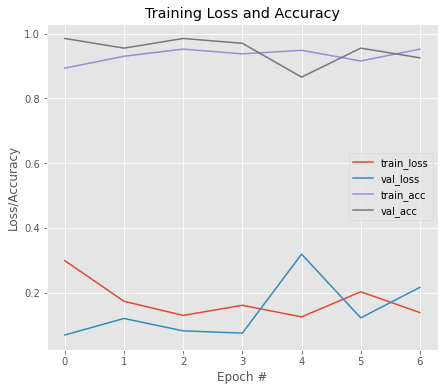


Model Performance Summary:

Best Validation accuracy:0.9850746393203735 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9007
Epoch 1: val_accuracy improved from -inf to 0.95522, saving model to vgg16_b_4.hdf5
9/9 [==============================] - 7s 549ms/step - loss: 0.2305 - accuracy: 0.9007 - val_loss: 0.1478 - val_accuracy: 0.9552
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.9449
Epoch 2: val_accuracy improved from 0.95522 to 0.97015, saving model to vgg16_b_4.hdf5
9/9 [==============================] - 5s 522ms/step - loss: 0.1495 - accuracy: 0.9449 - val_loss: 0.0824 - val_accuracy: 0.9701
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9265
Epoch 3: val_accuracy improved from 0.97015 to 0.98507, saving model to vgg16_b_4.hdf5
9/9 [==============================] - 5s 523ms/step - loss: 0.1643 - accuracy: 0.9265 - val_loss: 0.0777 - val_accuracy: 0.

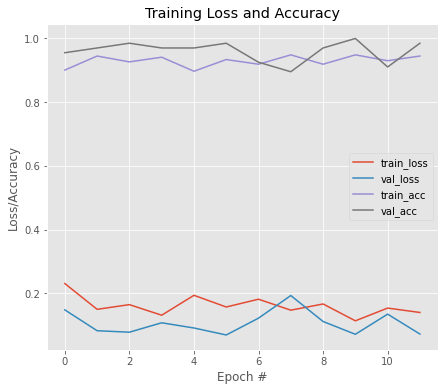


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:10
Average Accuracy:0.9264705896377563
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9764
Epoch 1: val_accuracy improved from -inf to 0.89726, saving model to vgg16_wt.hdf5
11/11 [==============================] - 9s 798ms/step - loss: 0.1011 - accuracy: 0.9764 - val_loss: 0.2219 - val_accuracy: 0.8973
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9794
Epoch 2: val_accuracy did not improve from 0.89726
11/11 [==============================] - 4s 385ms/step - loss: 0.0928 - accuracy: 0.9794 - val_loss: 0.2224 - val_accuracy: 0.8973
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9646
Epoch 3: val_accuracy did not improve from 0.89726
11/11 [==============================] - 4s 386ms/step - loss: 0.1062 - accuracy: 0.9646 

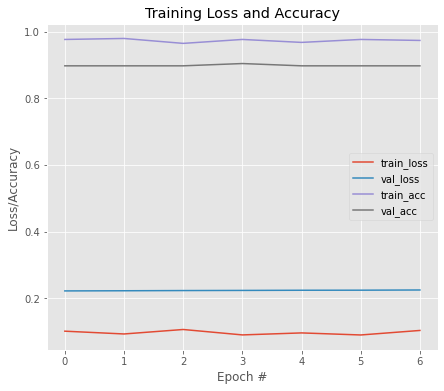


Model Performance Summary:

Best Validation accuracy:0.9041095972061157 at EPOCH:4
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.0718 - accuracy: 0.7699
Epoch 1: val_accuracy improved from -inf to 0.87671, saving model to vgg16_wt.hdf5
11/11 [==============================] - 11s 860ms/step - loss: 1.0718 - accuracy: 0.7699 - val_loss: 0.2751 - val_accuracy: 0.8767
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.2671 - accuracy: 0.8702
Epoch 2: val_accuracy improved from 0.87671 to 0.91781, saving model to vgg16_wt.hdf5
11/11 [==============================] - 6s 561ms/step - loss: 0.2671 - accuracy: 0.8702 - val_loss: 0.2441 - val_accuracy: 0.9178
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9204
Epoch 3: val_accuracy did not improve from 0.91781
11/11 [==============================] - 6s 529ms/step - loss: 0.2301 - accuracy: 0.9204 - val_loss: 0.3

In [ ]:
vgg_model_obj = HIGH_LEVEL_MODEL("vgg16")
vgg_model_obj.train_phase(training_images,training_label,test_images,test_label)

VGG19

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 20,025,410
Trainable params: 1,026
Non-trainable params: 20,024,384
_________________________________________________________________
None
Starting fold 0
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 1.0106 - accuracy: 0.6458
Epoch 1: val_accuracy improved from -inf to 0.64706, saving model

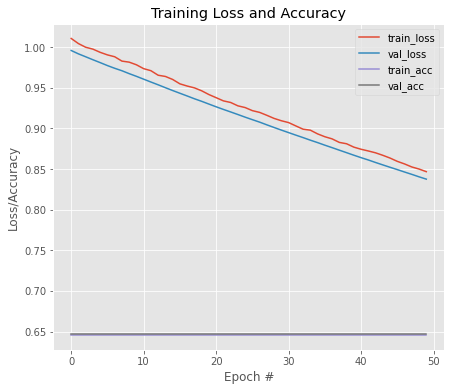


Model Performance Summary:

Best Validation accuracy:0.6470588445663452 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.6384
Epoch 1: val_accuracy improved from -inf to 0.64706, saving model to vgg19_b_0.hdf5
9/9 [==============================] - 15s 960ms/step - loss: 0.6842 - accuracy: 0.6384 - val_loss: 0.6139 - val_accuracy: 0.6471
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.6716
Epoch 2: val_accuracy did not improve from 0.64706
9/9 [==============================] - 6s 595ms/step - loss: 0.6385 - accuracy: 0.6716 - val_loss: 0.6150 - val_accuracy: 0.6471
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.6531
Epoch 3: val_accuracy improved from 0.64706 to 0.76471, saving model to vgg19_b_0.hdf5
9/9 [==============================] - 6s 644ms/step - loss: 0.6312 - accuracy: 0.6531 - val_loss: 0.6028 - val_accuracy: 0.7647
Epoch 4/50
9/9 [==============

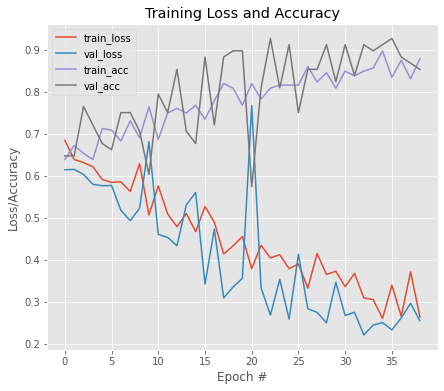


Model Performance Summary:

Best Validation accuracy:0.9264705777168274 at EPOCH:23
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.7934
Epoch 1: val_accuracy improved from -inf to 0.92647, saving model to vgg19_a_1.hdf5
9/9 [==============================] - 8s 659ms/step - loss: 0.4900 - accuracy: 0.7934 - val_loss: 0.1929 - val_accuracy: 0.9265
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.8708
Epoch 2: val_accuracy improved from 0.92647 to 0.97059, saving model to vgg19_a_1.hdf5
9/9 [==============================] - 6s 683ms/step - loss: 0.2966 - accuracy: 0.8708 - val_loss: 0.1428 - val_accuracy: 0.9706
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.8745
Epoch 3: val_accuracy improved from 0.97059 to 0.98529, saving model to vgg19_a_1.hdf5
9/9 [==============================] - 6s 644ms/step - loss: 0.3289 - accuracy: 0.8745 - val_loss: 0.1295 -

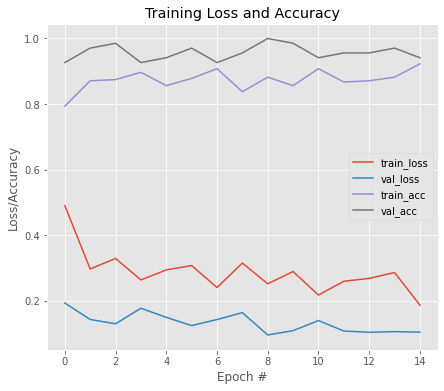


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:9
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3577 - accuracy: 0.8524
Epoch 1: val_accuracy improved from -inf to 0.86765, saving model to vgg19_b_1.hdf5
9/9 [==============================] - 8s 669ms/step - loss: 0.3577 - accuracy: 0.8524 - val_loss: 0.3135 - val_accuracy: 0.8676
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8524
Epoch 2: val_accuracy improved from 0.86765 to 0.97059, saving model to vgg19_b_1.hdf5
9/9 [==============================] - 6s 652ms/step - loss: 0.3161 - accuracy: 0.8524 - val_loss: 0.1095 - val_accuracy: 0.9706
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9299
Epoch 3: val_accuracy did not improve from 0.97059
9/9 [==============================] - 6s 606ms/step - loss: 0.1841 - accuracy: 0.9299 - val_loss: 0.0794 - val_accuracy: 0.9559
Epoch 4/50
9/9 [==============================

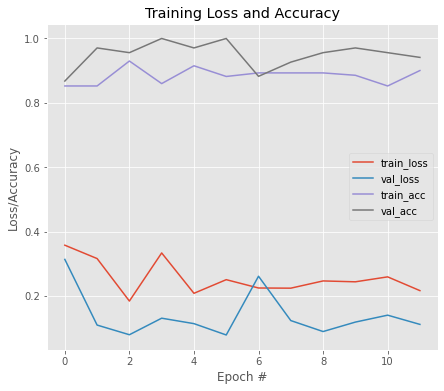


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:4
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.8930
Epoch 1: val_accuracy improved from -inf to 0.86765, saving model to vgg19_a_2.hdf5
9/9 [==============================] - 8s 655ms/step - loss: 0.3193 - accuracy: 0.8930 - val_loss: 0.2694 - val_accuracy: 0.8676
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9188
Epoch 2: val_accuracy did not improve from 0.86765
9/9 [==============================] - 6s 602ms/step - loss: 0.1592 - accuracy: 0.9188 - val_loss: 0.2577 - val_accuracy: 0.8529
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.9114
Epoch 3: val_accuracy improved from 0.86765 to 0.89706, saving model to vgg19_a_2.hdf5
9/9 [==============================] - 6s 649ms/step - loss: 0.1964 - accuracy: 0.9114 - val_loss: 0.1989 - val_accuracy: 0.8971
Epoch 4/50
9/9 [==============

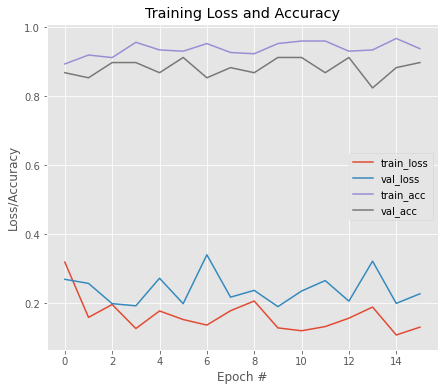


Model Performance Summary:

Best Validation accuracy:0.9117646813392639 at EPOCH:6
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.8745
Epoch 1: val_accuracy improved from -inf to 0.88235, saving model to vgg19_b_2.hdf5
9/9 [==============================] - 8s 666ms/step - loss: 0.3524 - accuracy: 0.8745 - val_loss: 0.2374 - val_accuracy: 0.8824
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9114
Epoch 2: val_accuracy did not improve from 0.88235
9/9 [==============================] - 6s 600ms/step - loss: 0.1957 - accuracy: 0.9114 - val_loss: 0.3250 - val_accuracy: 0.8382
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9151
Epoch 3: val_accuracy did not improve from 0.88235
9/9 [==============================] - 6s 600ms/step - loss: 0.1870 - accuracy: 0.9151 - val_loss: 0.5267 - val_accuracy: 0.7794
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0

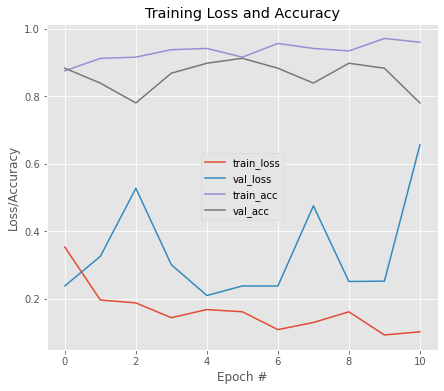


Model Performance Summary:

Best Validation accuracy:0.9117646813392639 at EPOCH:6
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.9041
Epoch 1: val_accuracy improved from -inf to 0.94118, saving model to vgg19_a_3.hdf5
9/9 [==============================] - 8s 664ms/step - loss: 0.2528 - accuracy: 0.9041 - val_loss: 0.1407 - val_accuracy: 0.9412
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9373
Epoch 2: val_accuracy did not improve from 0.94118
9/9 [==============================] - 6s 605ms/step - loss: 0.1450 - accuracy: 0.9373 - val_loss: 0.1675 - val_accuracy: 0.9412
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9262
Epoch 3: val_accuracy did not improve from 0.94118
9/9 [==============================] - 6s 605ms/step - loss: 0.1588 - accuracy: 0.9262 - val_loss: 0.2449 - val_accuracy: 0.8676
Epoch 4/50
9/9 [==============================] - E

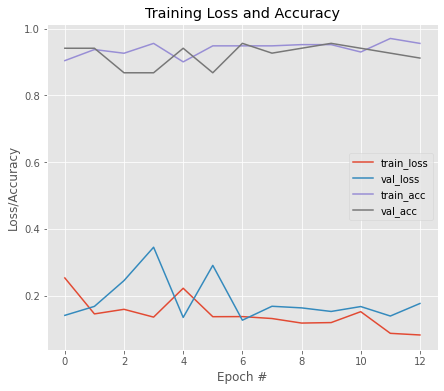


Model Performance Summary:

Best Validation accuracy:0.9558823704719543 at EPOCH:7
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.9114
Epoch 1: val_accuracy improved from -inf to 0.94118, saving model to vgg19_b_3.hdf5
9/9 [==============================] - 8s 663ms/step - loss: 0.3085 - accuracy: 0.9114 - val_loss: 0.1418 - val_accuracy: 0.9412
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9631
Epoch 2: val_accuracy did not improve from 0.94118
9/9 [==============================] - 6s 601ms/step - loss: 0.0955 - accuracy: 0.9631 - val_loss: 0.2108 - val_accuracy: 0.8971
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.9483
Epoch 3: val_accuracy did not improve from 0.94118
9/9 [==============================] - 6s 610ms/step - loss: 0.1178 - accuracy: 0.9483 - val_loss: 0.1335 - val_accuracy: 0.9265
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0

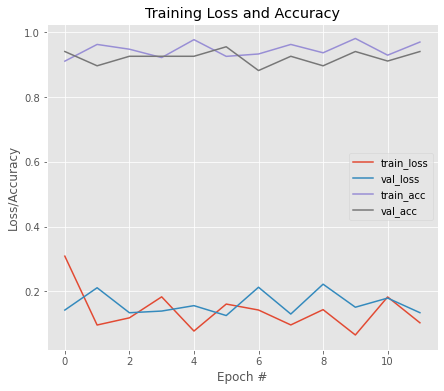


Model Performance Summary:

Best Validation accuracy:0.9558823704719543 at EPOCH:6
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8750
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to vgg19_a_4.hdf5
9/9 [==============================] - 13s 1s/step - loss: 0.3940 - accuracy: 0.8750 - val_loss: 0.0646 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9669
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 6s 611ms/step - loss: 0.0919 - accuracy: 0.9669 - val_loss: 0.0977 - val_accuracy: 0.9254
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9559
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 6s 649ms/step - loss: 0.1148 - accuracy: 0.9559 - val_loss: 0.1419 - val_accuracy: 0.9104
Epoch 4/50
9/9 [==============================] - ETA

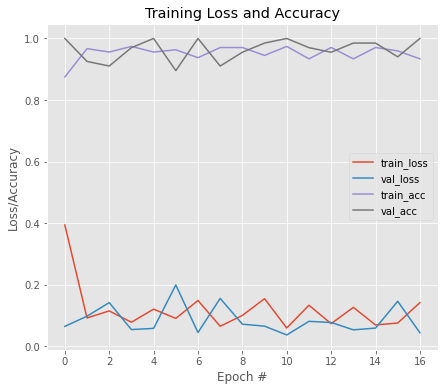


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3252 - accuracy: 0.9081
Epoch 1: val_accuracy improved from -inf to 0.95522, saving model to vgg19_b_4.hdf5
9/9 [==============================] - 8s 662ms/step - loss: 0.3252 - accuracy: 0.9081 - val_loss: 0.0860 - val_accuracy: 0.9552
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9559
Epoch 2: val_accuracy did not improve from 0.95522
9/9 [==============================] - 6s 605ms/step - loss: 0.0929 - accuracy: 0.9559 - val_loss: 0.0803 - val_accuracy: 0.9552
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9596
Epoch 3: val_accuracy did not improve from 0.95522
9/9 [==============================] - 6s 608ms/step - loss: 0.1023 - accuracy: 0.9596 - val_loss: 0.2245 - val_accuracy: 0.8955
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0960 - accurac

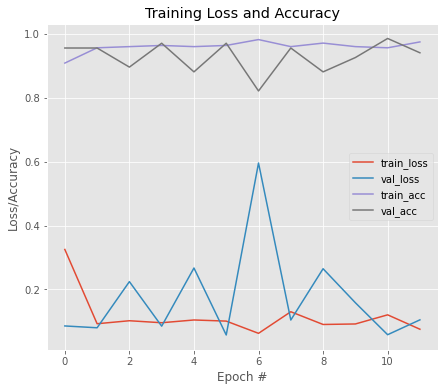


Model Performance Summary:

Best Validation accuracy:0.9850746393203735 at EPOCH:11
Average Accuracy:0.9558384537696838
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.9410
Epoch 1: val_accuracy improved from -inf to 0.89726, saving model to vgg19_wt.hdf5
11/11 [==============================] - 10s 869ms/step - loss: 0.2068 - accuracy: 0.9410 - val_loss: 0.2417 - val_accuracy: 0.8973
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9410
Epoch 2: val_accuracy did not improve from 0.89726
11/11 [==============================] - 5s 437ms/step - loss: 0.2104 - accuracy: 0.9410 - val_loss: 0.2415 - val_accuracy: 0.8973
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.2237 - accuracy: 0.9263
Epoch 3: val_accuracy did not improve from 0.89726
11/11 [==============================] - 5s 443ms/step - loss: 0.2237 - a

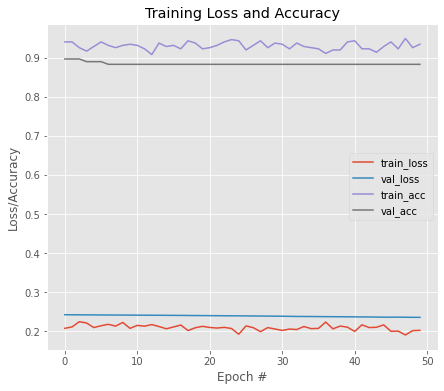


Model Performance Summary:

Best Validation accuracy:0.8972602486610413 at EPOCH:1
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.8965 - accuracy: 0.7286
Epoch 1: val_accuracy improved from -inf to 0.76027, saving model to vgg19_wt.hdf5
11/11 [==============================] - 13s 1s/step - loss: 0.8965 - accuracy: 0.7286 - val_loss: 0.4112 - val_accuracy: 0.7603
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.8260
Epoch 2: val_accuracy improved from 0.76027 to 0.86986, saving model to vgg19_wt.hdf5
11/11 [==============================] - 8s 703ms/step - loss: 0.3751 - accuracy: 0.8260 - val_loss: 0.2677 - val_accuracy: 0.8699
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.8791
Epoch 3: val_accuracy did not improve from 0.86986
11/11 [==============================] - 8s 669ms/step - loss: 0.3030 - accuracy: 0.8791 - val_loss: 0.6683

In [ ]:
vgg19_model_obj = HIGH_LEVEL_MODEL("vgg19")
vgg19_model_obj.train_phase(training_images,training_label,test_images,test_label)

RESNET50

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________
None
Starting fold 0
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.6458
Epoch 1: val_accuracy improved from -inf to 0.64706, saving mo

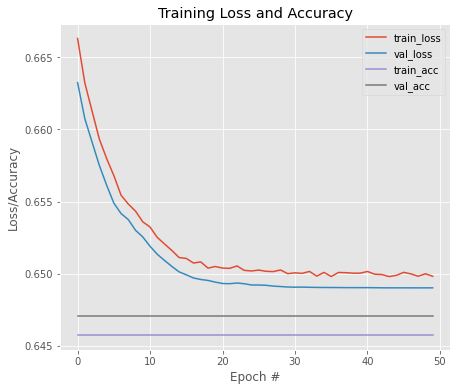


Model Performance Summary:

Best Validation accuracy:0.6470588445663452 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.6531
Epoch 1: val_accuracy improved from -inf to 0.64706, saving model to resnet50_b_0.hdf5
9/9 [==============================] - 19s 684ms/step - loss: 0.6700 - accuracy: 0.6531 - val_loss: 0.6510 - val_accuracy: 0.6471
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.7196
Epoch 2: val_accuracy did not improve from 0.64706
9/9 [==============================] - 4s 395ms/step - loss: 0.5491 - accuracy: 0.7196 - val_loss: 0.6599 - val_accuracy: 0.6471
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.4850 - accuracy: 0.7712
Epoch 3: val_accuracy did not improve from 0.64706
9/9 [==============================] - 4s 407ms/step - loss: 0.4850 - accuracy: 0.7712 - val_loss: 0.6768 - val_accuracy: 0.6471
Epoch 4/50
9/9 [==============================] - ETA: 0s - los

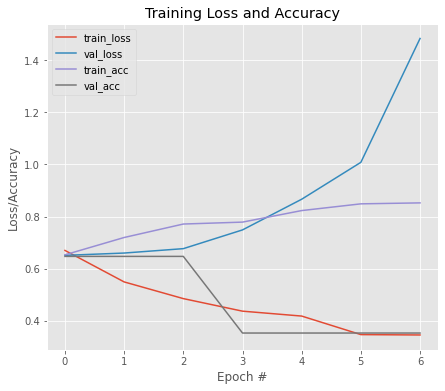


Model Performance Summary:

Best Validation accuracy:0.6470588445663452 at EPOCH:1
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.8635
Epoch 1: val_accuracy improved from -inf to 0.29412, saving model to resnet50_a_1.hdf5
9/9 [==============================] - 17s 601ms/step - loss: 0.3288 - accuracy: 0.8635 - val_loss: 1.8504 - val_accuracy: 0.2941
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2717 - accuracy: 0.9114
Epoch 2: val_accuracy did not improve from 0.29412
9/9 [==============================] - 4s 387ms/step - loss: 0.2717 - accuracy: 0.9114 - val_loss: 2.4335 - val_accuracy: 0.2941
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.9114
Epoch 3: val_accuracy did not improve from 0.29412
9/9 [==============================] - 4s 391ms/step - loss: 0.2505 - accuracy: 0.9114 - val_loss: 2.7038 - val_accuracy: 0.2941
Epoch 4/50
9/9 [==============================]

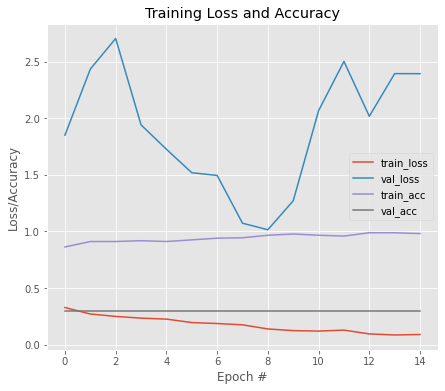


Model Performance Summary:

Best Validation accuracy:0.29411765933036804 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.8819
Epoch 1: val_accuracy improved from -inf to 0.29412, saving model to resnet50_b_1.hdf5
9/9 [==============================] - 17s 599ms/step - loss: 0.2673 - accuracy: 0.8819 - val_loss: 2.4866 - val_accuracy: 0.2941
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9151
Epoch 2: val_accuracy did not improve from 0.29412
9/9 [==============================] - 4s 392ms/step - loss: 0.2307 - accuracy: 0.9151 - val_loss: 1.9770 - val_accuracy: 0.2941
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9336
Epoch 3: val_accuracy did not improve from 0.29412
9/9 [==============================] - 4s 393ms/step - loss: 0.1958 - accuracy: 0.9336 - val_loss: 2.8102 - val_accuracy: 0.2941
Epoch 4/50
9/9 [==============================] - ETA: 0s - lo

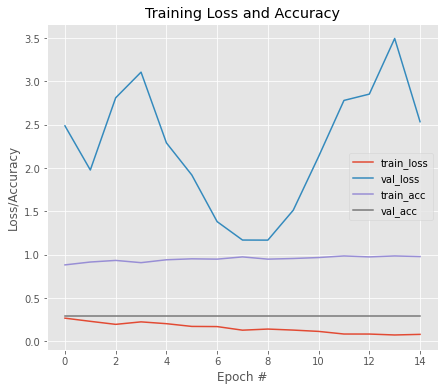


Model Performance Summary:

Best Validation accuracy:0.29411765933036804 at EPOCH:1
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9742
Epoch 1: val_accuracy improved from -inf to 0.38235, saving model to resnet50_a_2.hdf5
9/9 [==============================] - 17s 590ms/step - loss: 0.1079 - accuracy: 0.9742 - val_loss: 4.2765 - val_accuracy: 0.3824
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9631
Epoch 2: val_accuracy did not improve from 0.38235
9/9 [==============================] - 4s 379ms/step - loss: 0.1136 - accuracy: 0.9631 - val_loss: 4.2352 - val_accuracy: 0.3824
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9668
Epoch 3: val_accuracy did not improve from 0.38235
9/9 [==============================] - 4s 386ms/step - loss: 0.0929 - accuracy: 0.9668 - val_loss: 4.2780 - val_accuracy: 0.3824
Epoch 4/50
9/9 [==============================

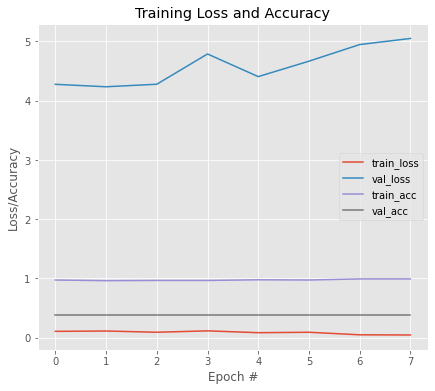


Model Performance Summary:

Best Validation accuracy:0.38235294818878174 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9668
Epoch 1: val_accuracy improved from -inf to 0.38235, saving model to resnet50_b_2.hdf5
9/9 [==============================] - 17s 612ms/step - loss: 0.0962 - accuracy: 0.9668 - val_loss: 4.4481 - val_accuracy: 0.3824
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9631
Epoch 2: val_accuracy did not improve from 0.38235
9/9 [==============================] - 4s 390ms/step - loss: 0.0818 - accuracy: 0.9631 - val_loss: 4.3645 - val_accuracy: 0.3824
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9742
Epoch 3: val_accuracy did not improve from 0.38235
9/9 [==============================] - 4s 397ms/step - loss: 0.0835 - accuracy: 0.9742 - val_loss: 4.5205 - val_accuracy: 0.3824
Epoch 4/50
9/9 [==============================] - ETA: 0s - lo

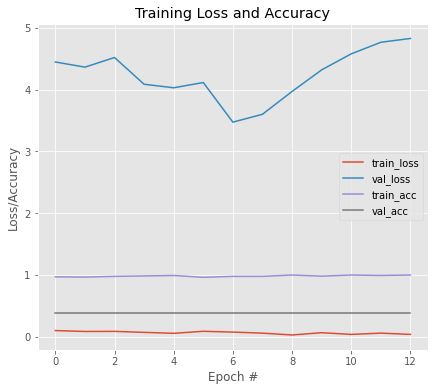


Model Performance Summary:

Best Validation accuracy:0.38235294818878174 at EPOCH:1
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9815
Epoch 1: val_accuracy improved from -inf to 0.36765, saving model to resnet50_a_3.hdf5
9/9 [==============================] - 16s 572ms/step - loss: 0.0457 - accuracy: 0.9815 - val_loss: 4.6623 - val_accuracy: 0.3676
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9779
Epoch 2: val_accuracy did not improve from 0.36765
9/9 [==============================] - 4s 408ms/step - loss: 0.0469 - accuracy: 0.9779 - val_loss: 4.9116 - val_accuracy: 0.3676
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9852
Epoch 3: val_accuracy did not improve from 0.36765
9/9 [==============================] - 4s 391ms/step - loss: 0.0405 - accuracy: 0.9852 - val_loss: 3.6781 - val_accuracy: 0.3676
Epoch 4/50
9/9 [==============================

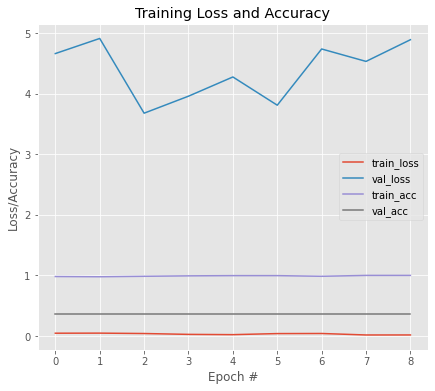


Model Performance Summary:

Best Validation accuracy:0.36764705181121826 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9963
Epoch 1: val_accuracy improved from -inf to 0.36765, saving model to resnet50_b_3.hdf5
9/9 [==============================] - 17s 599ms/step - loss: 0.0251 - accuracy: 0.9963 - val_loss: 4.4707 - val_accuracy: 0.3676
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9963
Epoch 2: val_accuracy did not improve from 0.36765
9/9 [==============================] - 4s 401ms/step - loss: 0.0246 - accuracy: 0.9963 - val_loss: 3.9460 - val_accuracy: 0.3676
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9852
Epoch 3: val_accuracy did not improve from 0.36765
9/9 [==============================] - 4s 377ms/step - loss: 0.0423 - accuracy: 0.9852 - val_loss: 3.7774 - val_accuracy: 0.3676
Epoch 4/50
9/9 [==============================] - ETA: 0s - lo

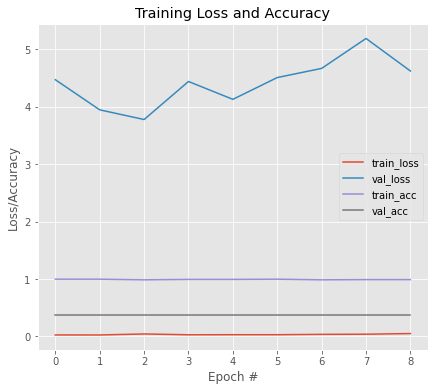


Model Performance Summary:

Best Validation accuracy:0.36764705181121826 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9926
Epoch 1: val_accuracy improved from -inf to 0.37313, saving model to resnet50_a_4.hdf5
9/9 [==============================] - 18s 797ms/step - loss: 0.0221 - accuracy: 0.9926 - val_loss: 3.7316 - val_accuracy: 0.3731
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9963
Epoch 2: val_accuracy did not improve from 0.37313
9/9 [==============================] - 4s 380ms/step - loss: 0.0102 - accuracy: 0.9963 - val_loss: 3.6789 - val_accuracy: 0.3731
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 0.37313
9/9 [==============================] - 4s 397ms/step - loss: 0.0237 - accuracy: 0.9963 - val_loss: 3.1972 - val_accuracy: 0.3731
Epoch 4/50
9/9 [==============================

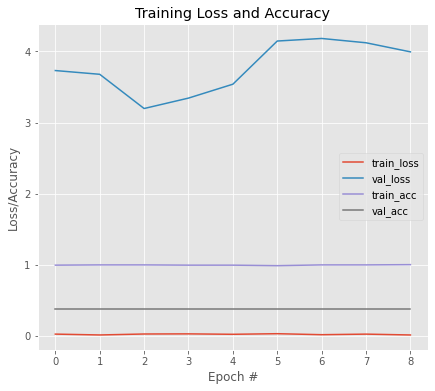


Model Performance Summary:

Best Validation accuracy:0.3731343150138855 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9963
Epoch 1: val_accuracy improved from -inf to 0.37313, saving model to resnet50_b_4.hdf5
9/9 [==============================] - 17s 614ms/step - loss: 0.0267 - accuracy: 0.9963 - val_loss: 3.2239 - val_accuracy: 0.3731
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.37313
9/9 [==============================] - 4s 393ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 3.3100 - val_accuracy: 0.3731
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 0.37313
9/9 [==============================] - 4s 395ms/step - loss: 0.0155 - accuracy: 0.9963 - val_loss: 2.7954 - val_accuracy: 0.3731
Epoch 4/50
9/9 [==============================] - ETA: 0s - los

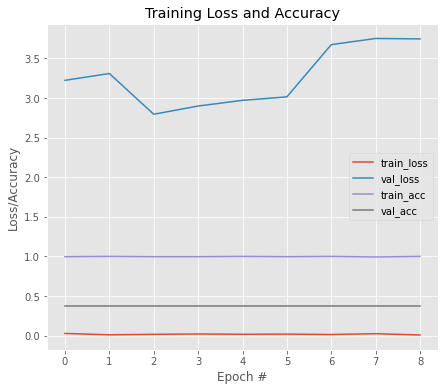


Model Performance Summary:

Best Validation accuracy:0.3731343150138855 at EPOCH:1
Average Accuracy:0.41286216378211976
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.6460
Epoch 1: val_accuracy improved from -inf to 0.64384, saving model to resnet50_wt.hdf5
11/11 [==============================] - 10s 609ms/step - loss: 0.6521 - accuracy: 0.6460 - val_loss: 0.6526 - val_accuracy: 0.6438
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.6460
Epoch 2: val_accuracy did not improve from 0.64384
11/11 [==============================] - 4s 395ms/step - loss: 0.6513 - accuracy: 0.6460 - val_loss: 0.6521 - val_accuracy: 0.6438
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.6510 - accuracy: 0.6460
Epoch 3: val_accuracy did not improve from 0.64384
11/11 [==============================] - 4s 397ms/step - loss: 0.6510 

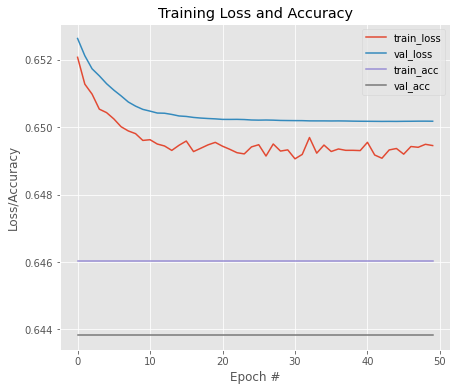


Model Performance Summary:

Best Validation accuracy:0.6438356041908264 at EPOCH:1
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.4787 - accuracy: 0.7699
Epoch 1: val_accuracy improved from -inf to 0.64384, saving model to resnet50_wt.hdf5
11/11 [==============================] - 19s 680ms/step - loss: 0.4787 - accuracy: 0.7699 - val_loss: 0.6699 - val_accuracy: 0.6438
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8496
Epoch 2: val_accuracy did not improve from 0.64384
11/11 [==============================] - 5s 415ms/step - loss: 0.3387 - accuracy: 0.8496 - val_loss: 0.6804 - val_accuracy: 0.6438
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.2972 - accuracy: 0.8761
Epoch 3: val_accuracy did not improve from 0.64384
11/11 [==============================] - 5s 417ms/step - loss: 0.2972 - accuracy: 0.8761 - val_loss: 1.2505 - val_accuracy: 0.3562
Epoch

In [ ]:
resnet50_model_obj = HIGH_LEVEL_MODEL("resnet50")
resnet50_model_obj.train_phase(training_images,training_label,test_images,test_label)

DENSENET121

29097984/29084464 [==============================] - 0s 0us/step
Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 7,039,554
Trainable params: 2,050
Non-trainable params: 7,037,504
_________________________________________________________________
None
Starting fold 0
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.9149 - accuracy: 0.3727
Epoch 1: val_accuracy improved from -inf to 0.35294, saving m

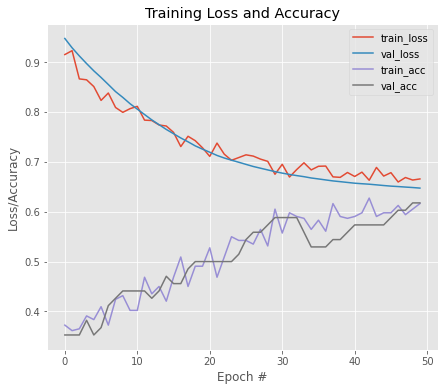


Model Performance Summary:

Best Validation accuracy:0.6176470518112183 at EPOCH:49
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.9010 - accuracy: 0.6458
Epoch 1: val_accuracy improved from -inf to 0.63235, saving model to DenseNet121_b_0.hdf5
9/9 [==============================] - 33s 974ms/step - loss: 0.9010 - accuracy: 0.6458 - val_loss: 0.6188 - val_accuracy: 0.6324
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.7275 - accuracy: 0.6827
Epoch 2: val_accuracy improved from 0.63235 to 0.64706, saving model to DenseNet121_b_0.hdf5
9/9 [==============================] - 5s 512ms/step - loss: 0.7275 - accuracy: 0.6827 - val_loss: 0.6030 - val_accuracy: 0.6471
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.6900
Epoch 3: val_accuracy did not improve from 0.64706
9/9 [==============================] - 4s 406ms/step - loss: 0.6832 - accuracy: 0.6900 - val_loss: 0.5938 - val_accuracy: 0.6471
Epoch 4/50
9/9 [=

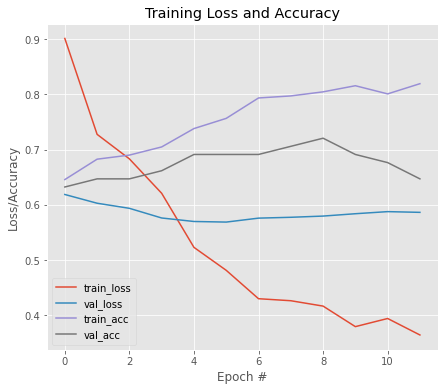


Model Performance Summary:

Best Validation accuracy:0.720588207244873 at EPOCH:9
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8524
Epoch 1: val_accuracy improved from -inf to 0.76471, saving model to DenseNet121_a_1.hdf5
9/9 [==============================] - 27s 741ms/step - loss: 0.3408 - accuracy: 0.8524 - val_loss: 0.5423 - val_accuracy: 0.7647
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.8635
Epoch 2: val_accuracy did not improve from 0.76471
9/9 [==============================] - 4s 394ms/step - loss: 0.3542 - accuracy: 0.8635 - val_loss: 0.5429 - val_accuracy: 0.7500
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8487
Epoch 3: val_accuracy did not improve from 0.76471
9/9 [==============================] - 4s 381ms/step - loss: 0.3396 - accuracy: 0.8487 - val_loss: 0.5522 - val_accuracy: 0.7059
Epoch 4/50
9/9 [=============================

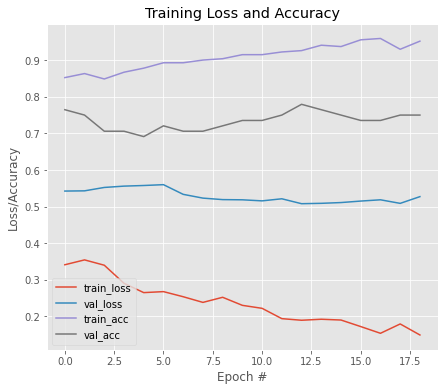


Model Performance Summary:

Best Validation accuracy:0.779411792755127 at EPOCH:13
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9262
Epoch 1: val_accuracy improved from -inf to 0.76471, saving model to DenseNet121_b_1.hdf5
9/9 [==============================] - 27s 720ms/step - loss: 0.1992 - accuracy: 0.9262 - val_loss: 0.5097 - val_accuracy: 0.7647
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9225
Epoch 2: val_accuracy did not improve from 0.76471
9/9 [==============================] - 4s 418ms/step - loss: 0.2005 - accuracy: 0.9225 - val_loss: 0.5100 - val_accuracy: 0.7500
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9446
Epoch 3: val_accuracy did not improve from 0.76471
9/9 [==============================] - 4s 397ms/step - loss: 0.1630 - accuracy: 0.9446 - val_loss: 0.5099 - val_accuracy: 0.7500
Epoch 4/50
9/9 [==============================] - ETA: 0s - 

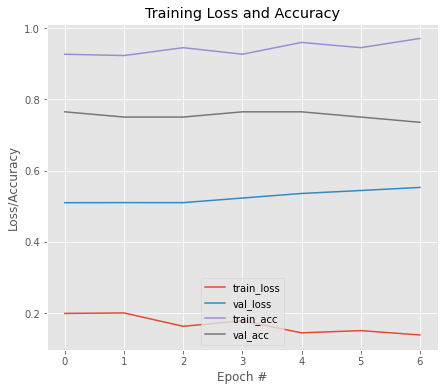


Model Performance Summary:

Best Validation accuracy:0.7647058963775635 at EPOCH:1
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9299
Epoch 1: val_accuracy improved from -inf to 0.66176, saving model to DenseNet121_a_2.hdf5
9/9 [==============================] - 27s 746ms/step - loss: 0.1726 - accuracy: 0.9299 - val_loss: 0.8635 - val_accuracy: 0.6618
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9520
Epoch 2: val_accuracy did not improve from 0.66176
9/9 [==============================] - 4s 400ms/step - loss: 0.1563 - accuracy: 0.9520 - val_loss: 0.8556 - val_accuracy: 0.6471
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1460 - accuracy: 0.9557
Epoch 3: val_accuracy improved from 0.66176 to 0.67647, saving model to DenseNet121_a_2.hdf5
9/9 [==============================] - 5s 536ms/step - loss: 0.1460 - accuracy: 0.9557 - val_loss: 0.8024 - val_accuracy: 0.6765
Ep

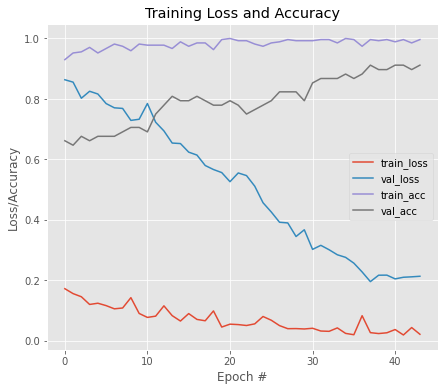


Model Performance Summary:

Best Validation accuracy:0.9117646813392639 at EPOCH:38
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9926
Epoch 1: val_accuracy improved from -inf to 0.89706, saving model to DenseNet121_b_2.hdf5
9/9 [==============================] - 27s 754ms/step - loss: 0.0274 - accuracy: 0.9926 - val_loss: 0.2144 - val_accuracy: 0.8971
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9926
Epoch 2: val_accuracy did not improve from 0.89706
9/9 [==============================] - 4s 398ms/step - loss: 0.0273 - accuracy: 0.9926 - val_loss: 0.2285 - val_accuracy: 0.8971
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.89706
9/9 [==============================] - 4s 399ms/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 0.2255 - val_accuracy: 0.8971
Epoch 4/50
9/9 [==============================] - ETA: 0s -

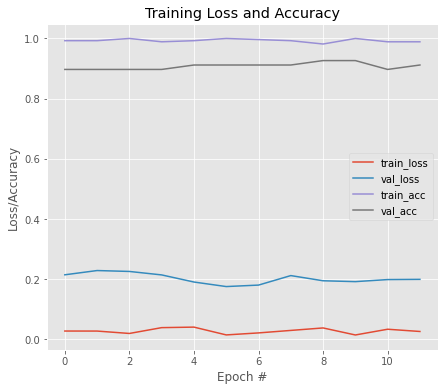


Model Performance Summary:

Best Validation accuracy:0.9264705777168274 at EPOCH:9
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9742
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to DenseNet121_a_3.hdf5
9/9 [==============================] - 27s 752ms/step - loss: 0.0840 - accuracy: 0.9742 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9779
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 399ms/step - loss: 0.0740 - accuracy: 0.9779 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9779
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 418ms/step - loss: 0.0521 - accuracy: 0.9779 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 4/50
9/9 [============================

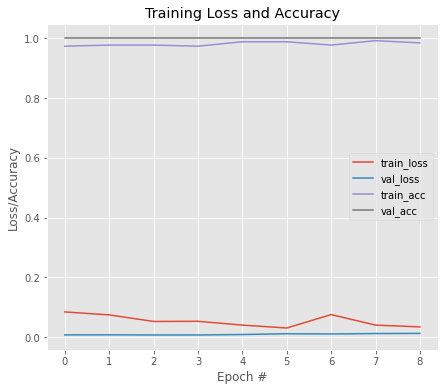


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0551 - accuracy: 0.9705
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to DenseNet121_b_3.hdf5
9/9 [==============================] - 27s 748ms/step - loss: 0.0551 - accuracy: 0.9705 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9779
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 396ms/step - loss: 0.0488 - accuracy: 0.9779 - val_loss: 0.0107 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9668
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 401ms/step - loss: 0.0838 - accuracy: 0.9668 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0647 - 

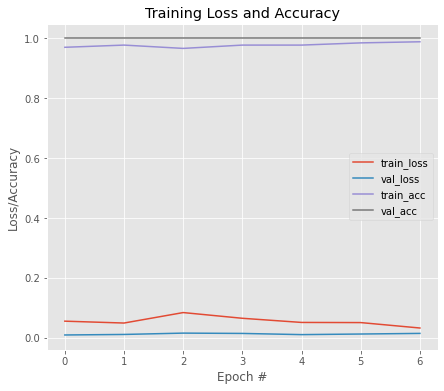


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9926
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to DenseNet121_a_4.hdf5
9/9 [==============================] - 31s 1s/step - loss: 0.0393 - accuracy: 0.9926 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9890
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 401ms/step - loss: 0.0330 - accuracy: 0.9890 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9926
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 402ms/step - loss: 0.0334 - accuracy: 0.9926 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - lo

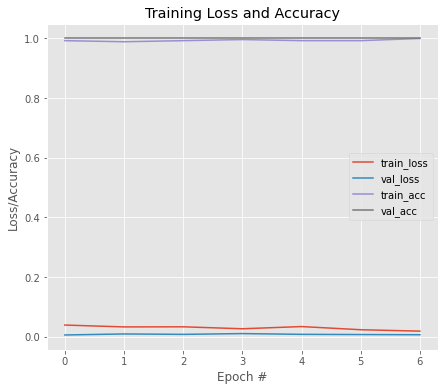


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9926
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to DenseNet121_b_4.hdf5
9/9 [==============================] - 27s 748ms/step - loss: 0.0339 - accuracy: 0.9926 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.9816
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 382ms/step - loss: 0.0565 - accuracy: 0.9816 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9926
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 402ms/step - loss: 0.0290 - accuracy: 0.9926 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0240 - 

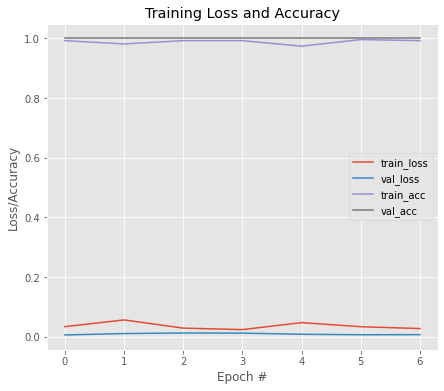


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Average Accuracy:0.8823529362678528
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9823
Epoch 1: val_accuracy improved from -inf to 0.93151, saving model to DenseNet121_wt.hdf5
11/11 [==============================] - 14s 834ms/step - loss: 0.0473 - accuracy: 0.9823 - val_loss: 0.2087 - val_accuracy: 0.9315
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9912
Epoch 2: val_accuracy did not improve from 0.93151
11/11 [==============================] - 4s 365ms/step - loss: 0.0365 - accuracy: 0.9912 - val_loss: 0.2095 - val_accuracy: 0.9315
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.9882
Epoch 3: val_accuracy did not improve from 0.93151
11/11 [==============================] - 4s 373ms/step - loss: 0.0395 - accuracy: 0

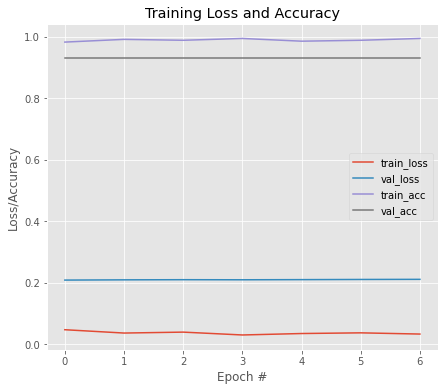


Model Performance Summary:

Best Validation accuracy:0.931506872177124 at EPOCH:1
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9823
Epoch 1: val_accuracy improved from -inf to 0.90411, saving model to DenseNet121_wt.hdf5
11/11 [==============================] - 30s 882ms/step - loss: 0.0536 - accuracy: 0.9823 - val_loss: 0.2321 - val_accuracy: 0.9041
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9823
Epoch 2: val_accuracy improved from 0.90411 to 0.91096, saving model to DenseNet121_wt.hdf5
11/11 [==============================] - 6s 508ms/step - loss: 0.0635 - accuracy: 0.9823 - val_loss: 0.2856 - val_accuracy: 0.9110
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9912
Epoch 3: val_accuracy improved from 0.91096 to 0.93151, saving model to DenseNet121_wt.hdf5
11/11 [==============================] - 6s 521ms/st

In [ ]:
densenet121_model_obj = HIGH_LEVEL_MODEL("DenseNet121")
densenet121_model_obj.train_phase(training_images,training_label,test_images,test_label)

MOBILENET

17235968/17225924 [==============================] - 1s 0us/step
Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 3,230,914
Trainable params: 2,050
Non-trainable params: 3,228,864
_________________________________________________________________
None
Starting fold 0
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6808 - accuracy: 0.60

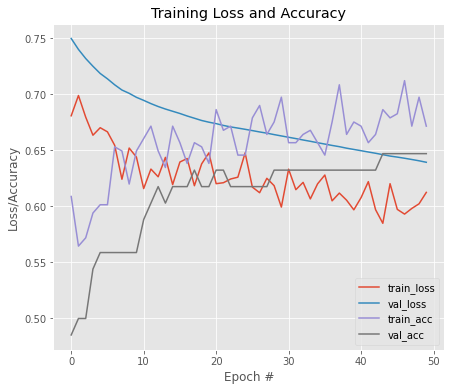


Model Performance Summary:

Best Validation accuracy:0.6470588445663452 at EPOCH:44
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6585 - accuracy: 0.6125
Epoch 1: val_accuracy improved from -inf to 0.67647, saving model to MobileNet_b_0.hdf5
9/9 [==============================] - 9s 418ms/step - loss: 0.6585 - accuracy: 0.6125 - val_loss: 0.6492 - val_accuracy: 0.6765
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.6790
Epoch 2: val_accuracy did not improve from 0.67647
9/9 [==============================] - 3s 328ms/step - loss: 0.6032 - accuracy: 0.6790 - val_loss: 0.7439 - val_accuracy: 0.5294
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.7122
Epoch 3: val_accuracy did not improve from 0.67647
9/9 [==============================] - 3s 329ms/step - loss: 0.6214 - accuracy: 0.7122 - val_loss: 0.8102 - val_accuracy: 0.5294
Epoch 4/50
9/9 [==============================] - ETA: 0s - lo

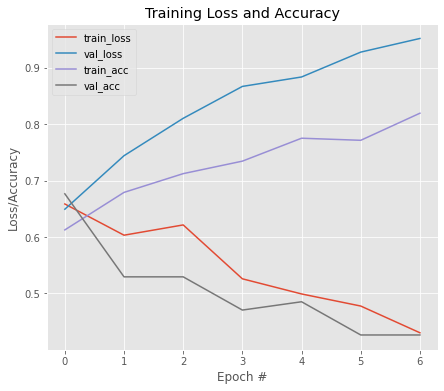


Model Performance Summary:

Best Validation accuracy:0.6764705777168274 at EPOCH:1
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.4452 - accuracy: 0.8044
Epoch 1: val_accuracy improved from -inf to 0.39706, saving model to MobileNet_a_1.hdf5
9/9 [==============================] - 8s 416ms/step - loss: 0.4452 - accuracy: 0.8044 - val_loss: 0.9028 - val_accuracy: 0.3971
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.8044
Epoch 2: val_accuracy improved from 0.39706 to 0.47059, saving model to MobileNet_a_1.hdf5
9/9 [==============================] - 3s 363ms/step - loss: 0.4778 - accuracy: 0.8044 - val_loss: 0.8188 - val_accuracy: 0.4706
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.4360 - accuracy: 0.7897
Epoch 3: val_accuracy improved from 0.47059 to 0.50000, saving model to MobileNet_a_1.hdf5
9/9 [==============================] - 3s 361ms/step - loss: 0.4360 - accuracy: 0.7897 - val_los

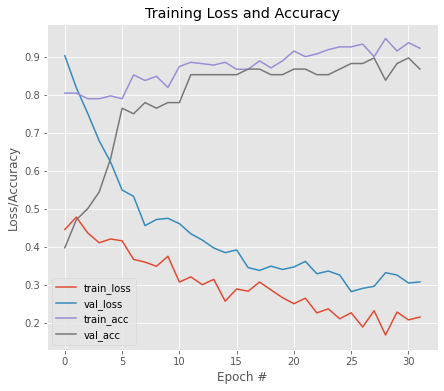


Model Performance Summary:

Best Validation accuracy:0.8970588445663452 at EPOCH:28
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9262
Epoch 1: val_accuracy improved from -inf to 0.89706, saving model to MobileNet_b_1.hdf5
9/9 [==============================] - 8s 413ms/step - loss: 0.2198 - accuracy: 0.9262 - val_loss: 0.2928 - val_accuracy: 0.8971
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2155 - accuracy: 0.9225
Epoch 2: val_accuracy did not improve from 0.89706
9/9 [==============================] - 3s 359ms/step - loss: 0.2155 - accuracy: 0.9225 - val_loss: 0.2788 - val_accuracy: 0.8971
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9188
Epoch 3: val_accuracy improved from 0.89706 to 0.91176, saving model to MobileNet_b_1.hdf5
9/9 [==============================] - 3s 362ms/step - loss: 0.2050 - accuracy: 0.9188 - val_loss: 0.2906 - val_accuracy: 0.9118
Epoch 4/50
9/9 [======

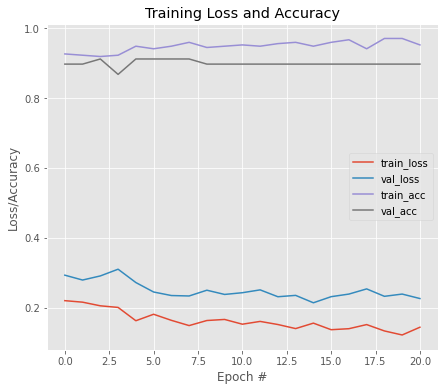


Model Performance Summary:

Best Validation accuracy:0.9117646813392639 at EPOCH:3
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1389 - accuracy: 0.9520
Epoch 1: val_accuracy improved from -inf to 0.92647, saving model to MobileNet_a_2.hdf5
9/9 [==============================] - 8s 402ms/step - loss: 0.1389 - accuracy: 0.9520 - val_loss: 0.1622 - val_accuracy: 0.9265
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 0.9446
Epoch 2: val_accuracy did not improve from 0.92647
9/9 [==============================] - 3s 325ms/step - loss: 0.1534 - accuracy: 0.9446 - val_loss: 0.1541 - val_accuracy: 0.9118
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.9631
Epoch 3: val_accuracy did not improve from 0.92647
9/9 [==============================] - 3s 356ms/step - loss: 0.1396 - accuracy: 0.9631 - val_loss: 0.1517 - val_accuracy: 0.9118
Epoch 4/50
9/9 [==============================]

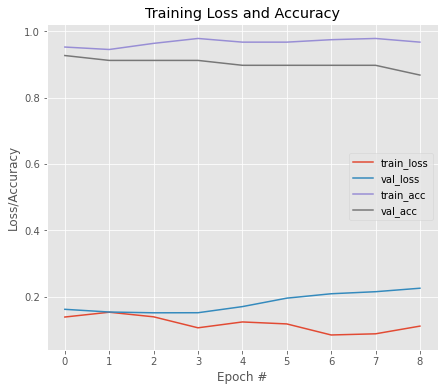


Model Performance Summary:

Best Validation accuracy:0.9264705777168274 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9557
Epoch 1: val_accuracy improved from -inf to 0.91176, saving model to MobileNet_b_2.hdf5
9/9 [==============================] - 8s 408ms/step - loss: 0.1211 - accuracy: 0.9557 - val_loss: 0.1639 - val_accuracy: 0.9118
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.9594
Epoch 2: val_accuracy did not improve from 0.91176
9/9 [==============================] - 3s 339ms/step - loss: 0.1235 - accuracy: 0.9594 - val_loss: 0.1591 - val_accuracy: 0.9118
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.9594
Epoch 3: val_accuracy did not improve from 0.91176
9/9 [==============================] - 3s 334ms/step - loss: 0.1188 - accuracy: 0.9594 - val_loss: 0.1833 - val_accuracy: 0.8971
Epoch 4/50
9/9 [==============================] - ETA: 0s - los

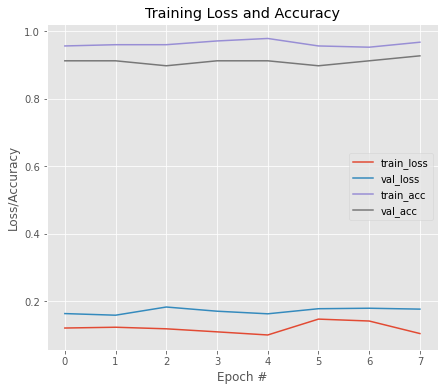


Model Performance Summary:

Best Validation accuracy:0.9264705777168274 at EPOCH:8
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9446
Epoch 1: val_accuracy improved from -inf to 0.95588, saving model to MobileNet_a_3.hdf5
9/9 [==============================] - 8s 415ms/step - loss: 0.1217 - accuracy: 0.9446 - val_loss: 0.1336 - val_accuracy: 0.9559
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9631
Epoch 2: val_accuracy did not improve from 0.95588
9/9 [==============================] - 3s 332ms/step - loss: 0.1148 - accuracy: 0.9631 - val_loss: 0.1280 - val_accuracy: 0.9559
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9520
Epoch 3: val_accuracy did not improve from 0.95588
9/9 [==============================] - 3s 330ms/step - loss: 0.1390 - accuracy: 0.9520 - val_loss: 0.1504 - val_accuracy: 0.9412
Epoch 4/50
9/9 [==============================]

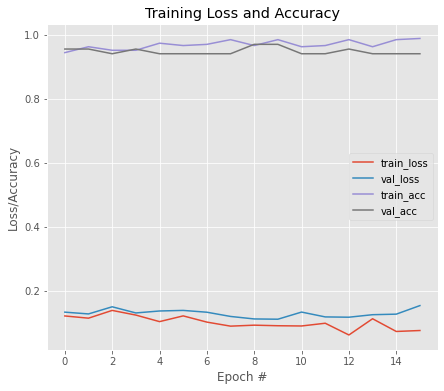


Model Performance Summary:

Best Validation accuracy:0.970588207244873 at EPOCH:9
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9594
Epoch 1: val_accuracy improved from -inf to 0.94118, saving model to MobileNet_b_3.hdf5
9/9 [==============================] - 8s 430ms/step - loss: 0.1083 - accuracy: 0.9594 - val_loss: 0.1427 - val_accuracy: 0.9412
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9705
Epoch 2: val_accuracy did not improve from 0.94118
9/9 [==============================] - 3s 333ms/step - loss: 0.0795 - accuracy: 0.9705 - val_loss: 0.1328 - val_accuracy: 0.9412
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9631
Epoch 3: val_accuracy did not improve from 0.94118
9/9 [==============================] - 3s 344ms/step - loss: 0.1159 - accuracy: 0.9631 - val_loss: 0.1289 - val_accuracy: 0.9412
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss

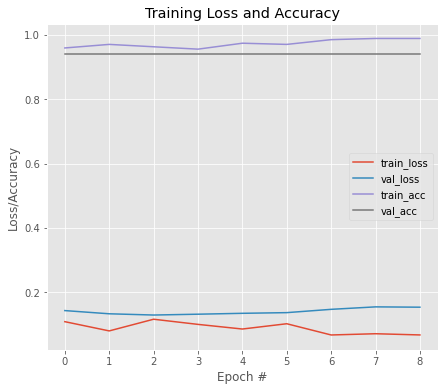


Model Performance Summary:

Best Validation accuracy:0.9411764740943909 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9522
Epoch 1: val_accuracy improved from -inf to 0.97015, saving model to MobileNet_a_4.hdf5
9/9 [==============================] - 9s 477ms/step - loss: 0.1092 - accuracy: 0.9522 - val_loss: 0.0477 - val_accuracy: 0.9701
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9669
Epoch 2: val_accuracy did not improve from 0.97015
9/9 [==============================] - 3s 372ms/step - loss: 0.0966 - accuracy: 0.9669 - val_loss: 0.0497 - val_accuracy: 0.9701
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.9816
Epoch 3: val_accuracy improved from 0.97015 to 0.98507, saving model to MobileNet_a_4.hdf5
9/9 [==============================] - 4s 373ms/step - loss: 0.0786 - accuracy: 0.9816 - val_loss: 0.0600 - val_accuracy: 0.9851
Epoch 4

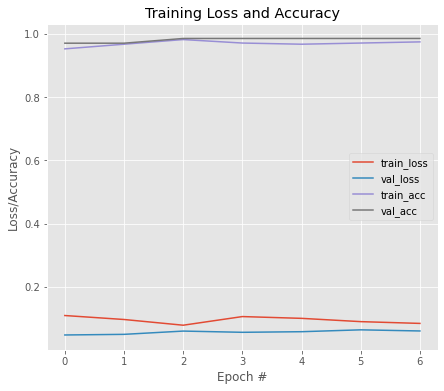


Model Performance Summary:

Best Validation accuracy:0.9850746393203735 at EPOCH:3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9743
Epoch 1: val_accuracy improved from -inf to 0.98507, saving model to MobileNet_b_4.hdf5
9/9 [==============================] - 8s 420ms/step - loss: 0.0898 - accuracy: 0.9743 - val_loss: 0.0638 - val_accuracy: 0.9851
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9779
Epoch 2: val_accuracy did not improve from 0.98507
9/9 [==============================] - 3s 338ms/step - loss: 0.0861 - accuracy: 0.9779 - val_loss: 0.0658 - val_accuracy: 0.9851
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.9706
Epoch 3: val_accuracy did not improve from 0.98507
9/9 [==============================] - 3s 339ms/step - loss: 0.0941 - accuracy: 0.9706 - val_loss: 0.0709 - val_accuracy: 0.9851
Epoch 4/50
9/9 [==============================] - ETA: 0s - los

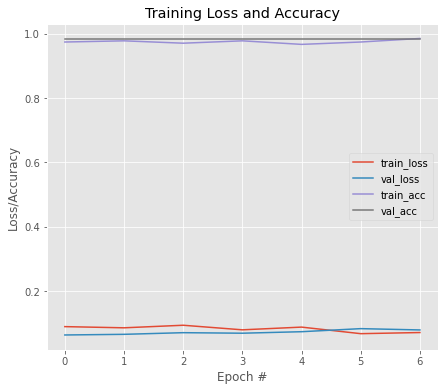


Model Performance Summary:

Best Validation accuracy:0.9850746393203735 at EPOCH:1
Average Accuracy:0.8881913900375367
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9882
Epoch 1: val_accuracy improved from -inf to 0.91096, saving model to MobileNet_wt.hdf5
11/11 [==============================] - 6s 432ms/step - loss: 0.0600 - accuracy: 0.9882 - val_loss: 0.2507 - val_accuracy: 0.9110
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9823
Epoch 2: val_accuracy improved from 0.91096 to 0.93151, saving model to MobileNet_wt.hdf5
11/11 [==============================] - 4s 366ms/step - loss: 0.0765 - accuracy: 0.9823 - val_loss: 0.2462 - val_accuracy: 0.9315
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9823
Epoch 3: val_accuracy did not improve from 0.93151
11/11 [=========================

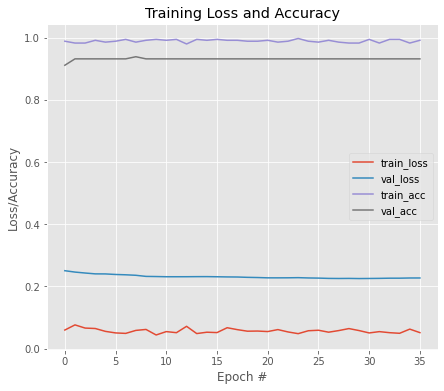


Model Performance Summary:

Best Validation accuracy:0.9383561611175537 at EPOCH:8
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.9469
Epoch 1: val_accuracy improved from -inf to 0.91096, saving model to MobileNet_wt.hdf5
11/11 [==============================] - 9s 429ms/step - loss: 0.1284 - accuracy: 0.9469 - val_loss: 0.2060 - val_accuracy: 0.9110
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9823
Epoch 2: val_accuracy improved from 0.91096 to 0.93836, saving model to MobileNet_wt.hdf5
11/11 [==============================] - 4s 381ms/step - loss: 0.0730 - accuracy: 0.9823 - val_loss: 0.2226 - val_accuracy: 0.9384
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9823
Epoch 3: val_accuracy did not improve from 0.93836
11/11 [==============================] - 4s 355ms/step - loss: 0.0714 - accuracy: 0.9823 - val_lo

In [ ]:
mobilenet_model_obj = HIGH_LEVEL_MODEL("MobileNet")
mobilenet_model_obj.train_phase(training_images,training_label,test_images,test_label)

INCEPTIONV3

87924736/87910968 [==============================] - 1s 0us/step
Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________
None
Starting fold 0
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.7657 - accuracy: 0.5240
Epoch 1: val_accuracy improved from -inf to 0.54412, saving

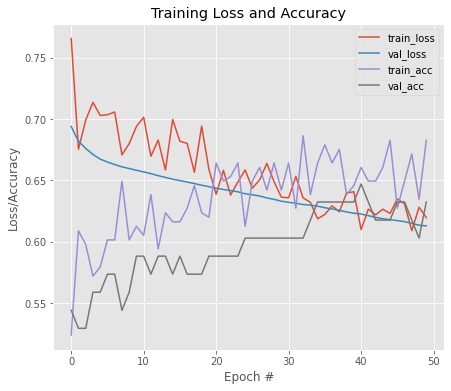


Model Performance Summary:

Best Validation accuracy:0.6470588445663452 at EPOCH:41
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6331 - accuracy: 0.6421
Epoch 1: val_accuracy improved from -inf to 0.67647, saving model to InceptionV3_b_0.hdf5
9/9 [==============================] - 21s 790ms/step - loss: 0.6331 - accuracy: 0.6421 - val_loss: 0.6390 - val_accuracy: 0.6765
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.5690 - accuracy: 0.7306
Epoch 2: val_accuracy did not improve from 0.67647
9/9 [==============================] - 4s 365ms/step - loss: 0.5690 - accuracy: 0.7306 - val_loss: 0.6595 - val_accuracy: 0.6618
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.7122
Epoch 3: val_accuracy did not improve from 0.67647
9/9 [==============================] - 4s 370ms/step - loss: 0.5575 - accuracy: 0.7122 - val_loss: 0.6530 - val_accuracy: 0.6618
Epoch 4/50
9/9 [==============================] - ETA: 0s -

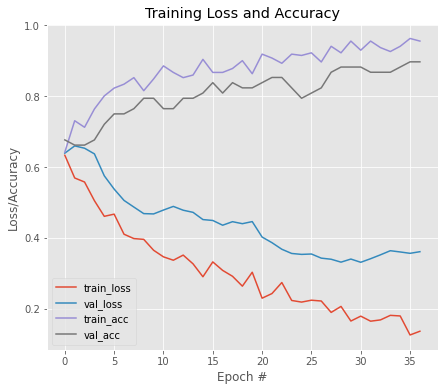


Model Performance Summary:

Best Validation accuracy:0.8970588445663452 at EPOCH:36
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9299
Epoch 1: val_accuracy improved from -inf to 0.97059, saving model to InceptionV3_a_1.hdf5
9/9 [==============================] - 18s 663ms/step - loss: 0.2028 - accuracy: 0.9299 - val_loss: 0.0986 - val_accuracy: 0.9706
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9520
Epoch 2: val_accuracy did not improve from 0.97059
9/9 [==============================] - 4s 391ms/step - loss: 0.1566 - accuracy: 0.9520 - val_loss: 0.1008 - val_accuracy: 0.9706
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9114
Epoch 3: val_accuracy did not improve from 0.97059
9/9 [==============================] - 4s 388ms/step - loss: 0.1901 - accuracy: 0.9114 - val_loss: 0.1032 - val_accuracy: 0.9559
Epoch 4/50
9/9 [===========================

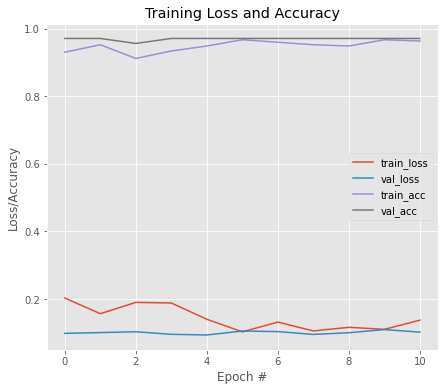


Model Performance Summary:

Best Validation accuracy:0.970588207244873 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9336
Epoch 1: val_accuracy improved from -inf to 0.97059, saving model to InceptionV3_b_1.hdf5
9/9 [==============================] - 18s 638ms/step - loss: 0.1626 - accuracy: 0.9336 - val_loss: 0.0936 - val_accuracy: 0.9706
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9410
Epoch 2: val_accuracy did not improve from 0.97059
9/9 [==============================] - 4s 363ms/step - loss: 0.1367 - accuracy: 0.9410 - val_loss: 0.0912 - val_accuracy: 0.9706
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1564 - accuracy: 0.9446
Epoch 3: val_accuracy did not improve from 0.97059
9/9 [==============================] - 4s 371ms/step - loss: 0.1564 - accuracy: 0.9446 - val_loss: 0.1029 - val_accuracy: 0.9706
Epoch 4/50
9/9 [==============================] - ETA: 0s - l

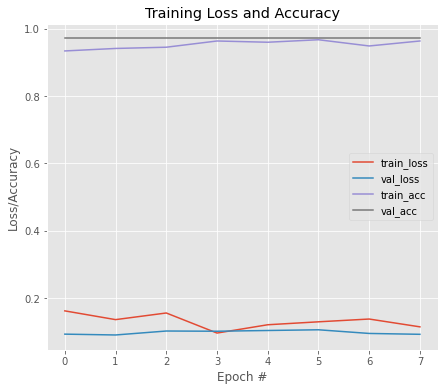


Model Performance Summary:

Best Validation accuracy:0.970588207244873 at EPOCH:1
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9889
Epoch 1: val_accuracy improved from -inf to 0.94118, saving model to InceptionV3_a_2.hdf5
9/9 [==============================] - 18s 629ms/step - loss: 0.0790 - accuracy: 0.9889 - val_loss: 0.0867 - val_accuracy: 0.9412
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9631
Epoch 2: val_accuracy improved from 0.94118 to 0.97059, saving model to InceptionV3_a_2.hdf5
9/9 [==============================] - 4s 467ms/step - loss: 0.1116 - accuracy: 0.9631 - val_loss: 0.0832 - val_accuracy: 0.9706
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9631
Epoch 3: val_accuracy improved from 0.97059 to 0.98529, saving model to InceptionV3_a_2.hdf5
9/9 [==============================] - 4s 470ms/step - loss: 0.1174 - accuracy: 0.9631 - v

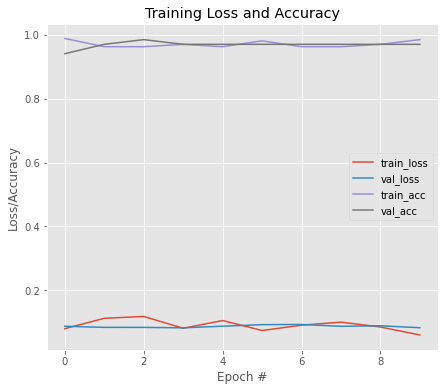


Model Performance Summary:

Best Validation accuracy:0.9852941036224365 at EPOCH:3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9631
Epoch 1: val_accuracy improved from -inf to 0.98529, saving model to InceptionV3_b_2.hdf5
9/9 [==============================] - 18s 629ms/step - loss: 0.0962 - accuracy: 0.9631 - val_loss: 0.0805 - val_accuracy: 0.9853
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.9705
Epoch 2: val_accuracy did not improve from 0.98529
9/9 [==============================] - 4s 369ms/step - loss: 0.0832 - accuracy: 0.9705 - val_loss: 0.0953 - val_accuracy: 0.9853
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9705
Epoch 3: val_accuracy did not improve from 0.98529
9/9 [==============================] - 4s 366ms/step - loss: 0.0888 - accuracy: 0.9705 - val_loss: 0.1088 - val_accuracy: 0.9706
Epoch 4/50
9/9 [==============================] - ETA: 0s - 

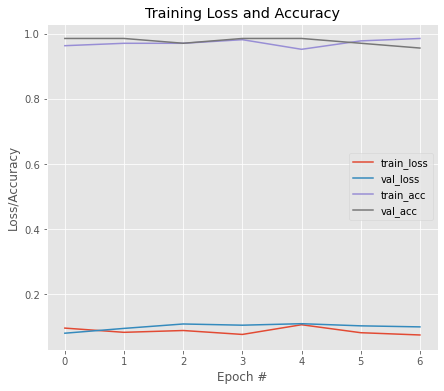


Model Performance Summary:

Best Validation accuracy:0.9852941036224365 at EPOCH:1
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9852
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionV3_a_3.hdf5
9/9 [==============================] - 18s 635ms/step - loss: 0.0701 - accuracy: 0.9852 - val_loss: 0.0212 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9742
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 360ms/step - loss: 0.0584 - accuracy: 0.9742 - val_loss: 0.0229 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9631
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 371ms/step - loss: 0.0864 - accuracy: 0.9631 - val_loss: 0.0229 - val_accuracy: 1.0000
Epoch 4/50
9/9 [============================

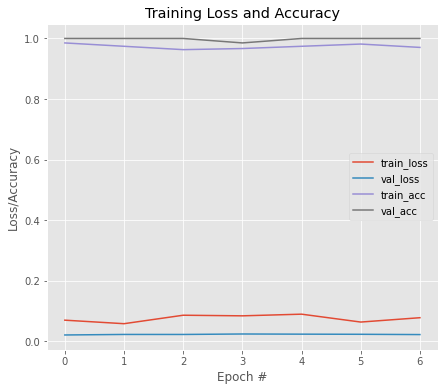


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9779
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionV3_b_3.hdf5
9/9 [==============================] - 18s 648ms/step - loss: 0.0613 - accuracy: 0.9779 - val_loss: 0.0221 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9483
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 368ms/step - loss: 0.1166 - accuracy: 0.9483 - val_loss: 0.0253 - val_accuracy: 0.9853
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9889
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 366ms/step - loss: 0.0501 - accuracy: 0.9889 - val_loss: 0.0237 - val_accuracy: 0.9853
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0919 - 

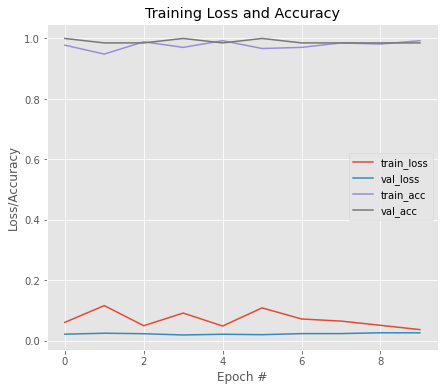


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9816
Epoch 1: val_accuracy improved from -inf to 0.98507, saving model to InceptionV3_a_4.hdf5
9/9 [==============================] - 21s 1s/step - loss: 0.0664 - accuracy: 0.9816 - val_loss: 0.0315 - val_accuracy: 0.9851
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9853
Epoch 2: val_accuracy did not improve from 0.98507
9/9 [==============================] - 4s 373ms/step - loss: 0.0367 - accuracy: 0.9853 - val_loss: 0.0258 - val_accuracy: 0.9851
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9706
Epoch 3: val_accuracy did not improve from 0.98507
9/9 [==============================] - 3s 364ms/step - loss: 0.0851 - accuracy: 0.9706 - val_loss: 0.0236 - val_accuracy: 0.9851
Epoch 4/50
9/9 [==============================] - ETA: 0s - lo

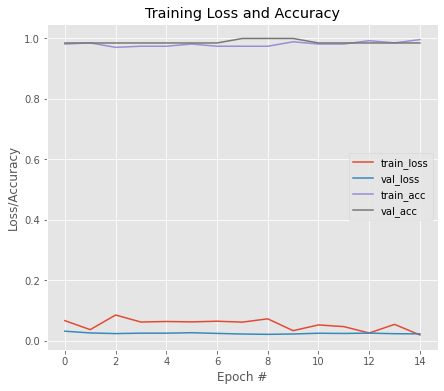


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:8
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9963
Epoch 1: val_accuracy improved from -inf to 0.98507, saving model to InceptionV3_b_4.hdf5
9/9 [==============================] - 18s 640ms/step - loss: 0.0208 - accuracy: 0.9963 - val_loss: 0.0355 - val_accuracy: 0.9851
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9853
Epoch 2: val_accuracy did not improve from 0.98507
9/9 [==============================] - 4s 360ms/step - loss: 0.0421 - accuracy: 0.9853 - val_loss: 0.0306 - val_accuracy: 0.9851
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9926
Epoch 3: val_accuracy did not improve from 0.98507
9/9 [==============================] - 3s 357ms/step - loss: 0.0361 - accuracy: 0.9926 - val_loss: 0.0293 - val_accuracy: 0.9851
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0649 - 

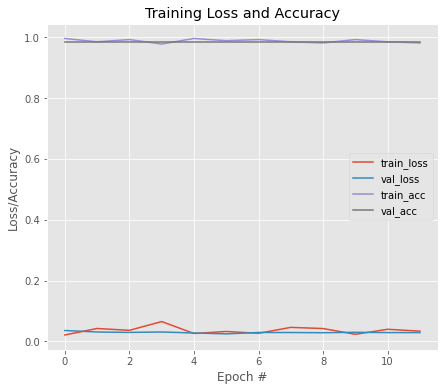


Model Performance Summary:

Best Validation accuracy:0.9850746393203735 at EPOCH:1
Average Accuracy:0.9676031589508056
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9912
Epoch 1: val_accuracy improved from -inf to 0.86986, saving model to InceptionV3_wt.hdf5
11/11 [==============================] - 12s 735ms/step - loss: 0.0407 - accuracy: 0.9912 - val_loss: 0.3598 - val_accuracy: 0.8699
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9853
Epoch 2: val_accuracy did not improve from 0.86986
11/11 [==============================] - 4s 393ms/step - loss: 0.0372 - accuracy: 0.9853 - val_loss: 0.3603 - val_accuracy: 0.8699
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9853
Epoch 3: val_accuracy did not improve from 0.86986
11/11 [==============================] - 4s 381ms/step - loss: 0.042

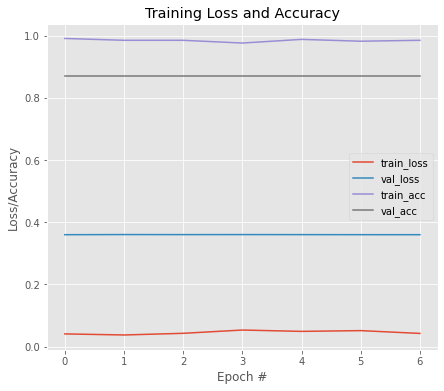


Model Performance Summary:

Best Validation accuracy:0.8698630332946777 at EPOCH:1
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9440
Epoch 1: val_accuracy improved from -inf to 0.86301, saving model to InceptionV3_wt.hdf5
11/11 [==============================] - 20s 735ms/step - loss: 0.1232 - accuracy: 0.9440 - val_loss: 0.3181 - val_accuracy: 0.8630
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9528
Epoch 2: val_accuracy improved from 0.86301 to 0.87671, saving model to InceptionV3_wt.hdf5
11/11 [==============================] - 5s 461ms/step - loss: 0.1081 - accuracy: 0.9528 - val_loss: 0.3170 - val_accuracy: 0.8767
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9882
Epoch 3: val_accuracy did not improve from 0.87671
11/11 [==============================] - 4s 379ms/step - loss: 0.0417 - accuracy: 0.9882 - v

In [ ]:
inceptionv3_model_obj = HIGH_LEVEL_MODEL("InceptionV3")
inceptionv3_model_obj.train_phase(training_images,training_label,test_images,test_label)

NASNETMOBILE

20004864/19993432 [==============================] - 0s 0us/step
Model: "NASNetMobile"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d_6   (None, 1056)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 2)                 2114      
                                                                 
Total params: 4,271,830
Trainable params: 2,114
Non-trainable params: 4,269,716
_________________________________________________________________
None
Starting fold 0
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.8232 - accuracy: 0.3801
Epoch 1: val_accuracy improved from -inf to 0.42647, saving 

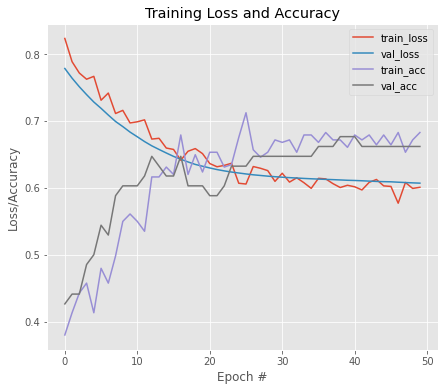


Model Performance Summary:

Best Validation accuracy:0.6764705777168274 at EPOCH:39
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.6310
Epoch 1: val_accuracy improved from -inf to 0.67647, saving model to NASNetMobile_b_0.hdf5
9/9 [==============================] - 57s 1s/step - loss: 0.6610 - accuracy: 0.6310 - val_loss: 0.6030 - val_accuracy: 0.6765
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.6421
Epoch 2: val_accuracy did not improve from 0.67647
9/9 [==============================] - 4s 422ms/step - loss: 0.6040 - accuracy: 0.6421 - val_loss: 0.5961 - val_accuracy: 0.6765
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7048
Epoch 3: val_accuracy did not improve from 0.67647
9/9 [==============================] - 4s 424ms/step - loss: 0.5697 - accuracy: 0.7048 - val_loss: 0.5920 - val_accuracy: 0.6618
Epoch 4/50
9/9 [==============================] - ETA: 0s - l

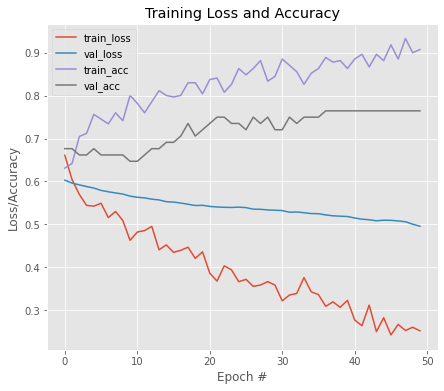


Model Performance Summary:

Best Validation accuracy:0.7647058963775635 at EPOCH:37
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.2716 - accuracy: 0.8967
Epoch 1: val_accuracy improved from -inf to 0.86765, saving model to NASNetMobile_a_1.hdf5
9/9 [==============================] - 56s 1s/step - loss: 0.2716 - accuracy: 0.8967 - val_loss: 0.3695 - val_accuracy: 0.8676
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.3070 - accuracy: 0.8339
Epoch 2: val_accuracy did not improve from 0.86765
9/9 [==============================] - 4s 411ms/step - loss: 0.3070 - accuracy: 0.8339 - val_loss: 0.3712 - val_accuracy: 0.8676
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9041
Epoch 3: val_accuracy improved from 0.86765 to 0.88235, saving model to NASNetMobile_a_1.hdf5
9/9 [==============================] - 6s 609ms/step - loss: 0.2593 - accuracy: 0.9041 - val_loss: 0.3690 - val_accuracy: 0.8824
Ep

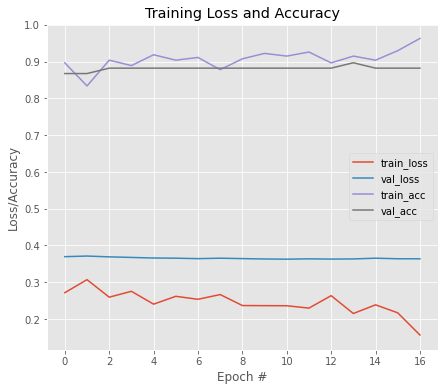


Model Performance Summary:

Best Validation accuracy:0.8970588445663452 at EPOCH:14
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9336
Epoch 1: val_accuracy improved from -inf to 0.88235, saving model to NASNetMobile_b_1.hdf5
9/9 [==============================] - 57s 1s/step - loss: 0.1856 - accuracy: 0.9336 - val_loss: 0.3626 - val_accuracy: 0.8824
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.9262
Epoch 2: val_accuracy did not improve from 0.88235
9/9 [==============================] - 4s 415ms/step - loss: 0.2008 - accuracy: 0.9262 - val_loss: 0.3616 - val_accuracy: 0.8824
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9262
Epoch 3: val_accuracy did not improve from 0.88235
9/9 [==============================] - 4s 399ms/step - loss: 0.1961 - accuracy: 0.9262 - val_loss: 0.3607 - val_accuracy: 0.8824
Epoch 4/50
9/9 [==============================] - ETA: 0s - l

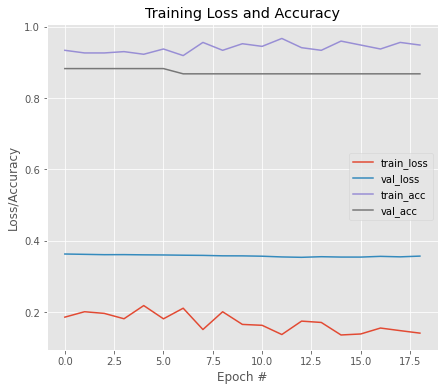


Model Performance Summary:

Best Validation accuracy:0.8823529481887817 at EPOCH:1
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.9594
Epoch 1: val_accuracy improved from -inf to 0.70588, saving model to NASNetMobile_a_2.hdf5
9/9 [==============================] - 53s 1s/step - loss: 0.1463 - accuracy: 0.9594 - val_loss: 0.5679 - val_accuracy: 0.7059
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.9446
Epoch 2: val_accuracy improved from 0.70588 to 0.72059, saving model to NASNetMobile_a_2.hdf5
9/9 [==============================] - 5s 586ms/step - loss: 0.1459 - accuracy: 0.9446 - val_loss: 0.5715 - val_accuracy: 0.7206
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9446
Epoch 3: val_accuracy did not improve from 0.72059
9/9 [==============================] - 4s 414ms/step - loss: 0.1651 - accuracy: 0.9446 - val_loss: 0.5683 - val_accuracy: 0.7206
Epo

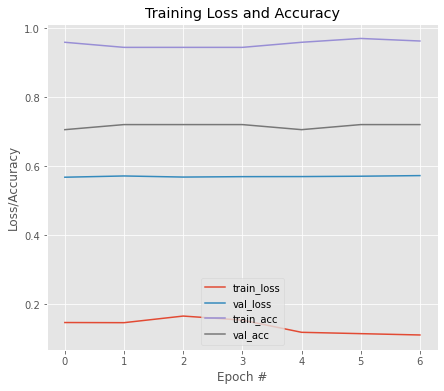


Model Performance Summary:

Best Validation accuracy:0.720588207244873 at EPOCH:2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9483
Epoch 1: val_accuracy improved from -inf to 0.72059, saving model to NASNetMobile_b_2.hdf5
9/9 [==============================] - 53s 1s/step - loss: 0.1190 - accuracy: 0.9483 - val_loss: 0.5801 - val_accuracy: 0.7206
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9483
Epoch 2: val_accuracy did not improve from 0.72059
9/9 [==============================] - 4s 409ms/step - loss: 0.1571 - accuracy: 0.9483 - val_loss: 0.5814 - val_accuracy: 0.7206
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9594
Epoch 3: val_accuracy did not improve from 0.72059
9/9 [==============================] - 4s 412ms/step - loss: 0.1215 - accuracy: 0.9594 - val_loss: 0.5833 - val_accuracy: 0.7206
Epoch 4/50
9/9 [==============================] - ETA: 0s - los

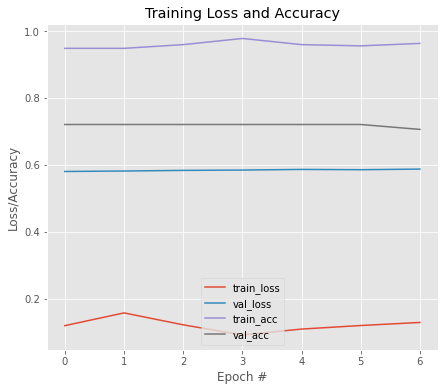


Model Performance Summary:

Best Validation accuracy:0.720588207244873 at EPOCH:1
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9520
Epoch 1: val_accuracy improved from -inf to 0.77941, saving model to NASNetMobile_a_3.hdf5
9/9 [==============================] - 53s 1s/step - loss: 0.1259 - accuracy: 0.9520 - val_loss: 0.5156 - val_accuracy: 0.7794
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9705
Epoch 2: val_accuracy did not improve from 0.77941
9/9 [==============================] - 4s 404ms/step - loss: 0.1089 - accuracy: 0.9705 - val_loss: 0.5181 - val_accuracy: 0.7647
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9815
Epoch 3: val_accuracy did not improve from 0.77941
9/9 [==============================] - 4s 408ms/step - loss: 0.0859 - accuracy: 0.9815 - val_loss: 0.5229 - val_accuracy: 0.7647
Epoch 4/50
9/9 [==============================]

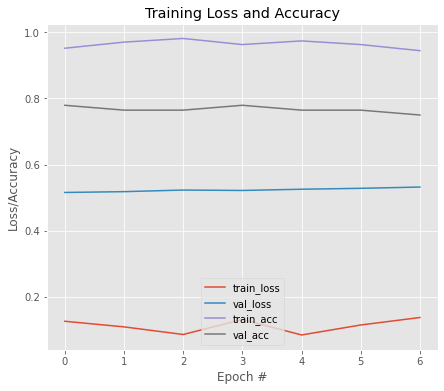


Model Performance Summary:

Best Validation accuracy:0.779411792755127 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9483
Epoch 1: val_accuracy improved from -inf to 0.76471, saving model to NASNetMobile_b_3.hdf5
9/9 [==============================] - 54s 1s/step - loss: 0.1236 - accuracy: 0.9483 - val_loss: 0.5180 - val_accuracy: 0.7647
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9705
Epoch 2: val_accuracy did not improve from 0.76471
9/9 [==============================] - 4s 411ms/step - loss: 0.0880 - accuracy: 0.9705 - val_loss: 0.5212 - val_accuracy: 0.7647
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.9668
Epoch 3: val_accuracy did not improve from 0.76471
9/9 [==============================] - 4s 415ms/step - loss: 0.0996 - accuracy: 0.9668 - val_loss: 0.5293 - val_accuracy: 0.7647
Epoch 4/50
9/9 [==============================] - ETA: 0s - los

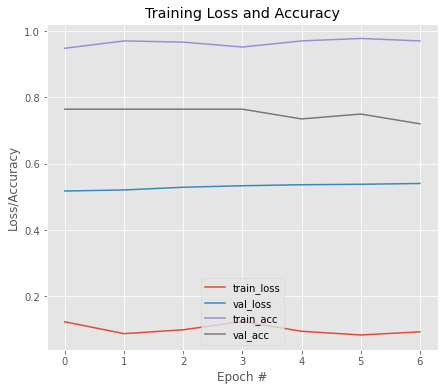


Model Performance Summary:

Best Validation accuracy:0.7647058963775635 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.9375
Epoch 1: val_accuracy improved from -inf to 0.76119, saving model to NASNetMobile_a_4.hdf5
9/9 [==============================] - 54s 1s/step - loss: 0.1500 - accuracy: 0.9375 - val_loss: 0.4880 - val_accuracy: 0.7612
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.9632
Epoch 2: val_accuracy did not improve from 0.76119
9/9 [==============================] - 4s 409ms/step - loss: 0.0996 - accuracy: 0.9632 - val_loss: 0.4940 - val_accuracy: 0.7612
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9632
Epoch 3: val_accuracy did not improve from 0.76119
9/9 [==============================] - 4s 408ms/step - loss: 0.1164 - accuracy: 0.9632 - val_loss: 0.4936 - val_accuracy: 0.7612
Epoch 4/50
9/9 [==============================

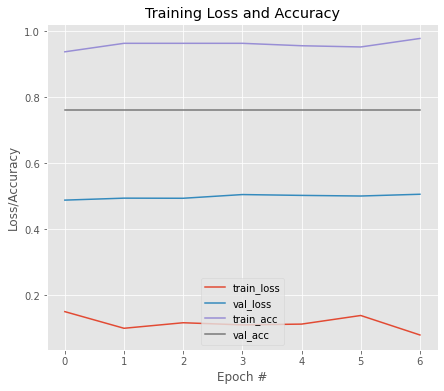


Model Performance Summary:

Best Validation accuracy:0.7611940503120422 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9706
Epoch 1: val_accuracy improved from -inf to 0.76119, saving model to NASNetMobile_b_4.hdf5
9/9 [==============================] - 56s 1s/step - loss: 0.1083 - accuracy: 0.9706 - val_loss: 0.4963 - val_accuracy: 0.7612
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9596
Epoch 2: val_accuracy did not improve from 0.76119
9/9 [==============================] - 4s 419ms/step - loss: 0.1054 - accuracy: 0.9596 - val_loss: 0.4962 - val_accuracy: 0.7612
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9706
Epoch 3: val_accuracy did not improve from 0.76119
9/9 [==============================] - 4s 414ms/step - loss: 0.1089 - accuracy: 0.9706 - val_loss: 0.4982 - val_accuracy: 0.7612
Epoch 4/50
9/9 [==============================] - ETA: 0s - lo

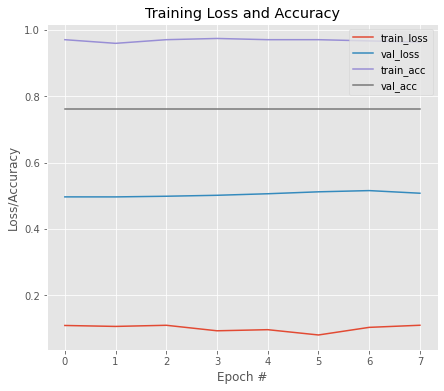


Model Performance Summary:

Best Validation accuracy:0.7611940503120422 at EPOCH:1
Average Accuracy:0.7787093997001648
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.4854 - accuracy: 0.7965
Epoch 1: val_accuracy improved from -inf to 0.77397, saving model to NASNetMobile_wt.hdf5
11/11 [==============================] - 21s 873ms/step - loss: 0.4854 - accuracy: 0.7965 - val_loss: 0.4873 - val_accuracy: 0.7740
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.4752 - accuracy: 0.7876
Epoch 2: val_accuracy did not improve from 0.77397
11/11 [==============================] - 4s 368ms/step - loss: 0.4752 - accuracy: 0.7876 - val_loss: 0.4869 - val_accuracy: 0.7740
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.4842 - accuracy: 0.7935
Epoch 3: val_accuracy did not improve from 0.77397
11/11 [==============================] - 4s 360ms/step - loss: 0.48

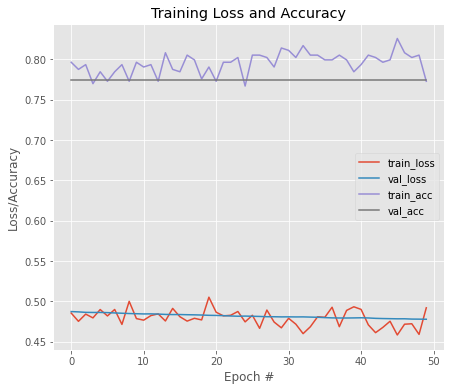


Model Performance Summary:

Best Validation accuracy:0.7739726305007935 at EPOCH:1
 Training Model with pretraned layer trainable
Epoch 1/50


In [ ]:
nasnetmobile_model_obj = HIGH_LEVEL_MODEL("NASNetMobile")
nasnetmobile_model_obj.train_phase(training_images,training_label,test_images,test_label)

MOBILENETV2

9420800/9406464 [==============================] - 0s 0us/step
Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
None
Starting fold 0
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 1.2891 - accuracy: 0.36

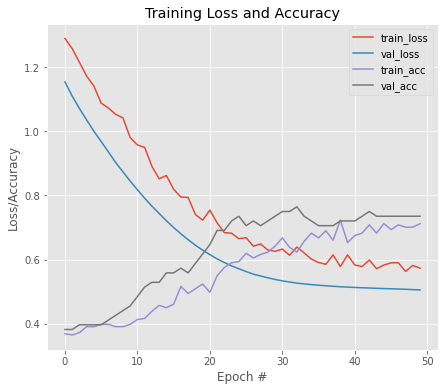


Model Performance Summary:

Best Validation accuracy:0.7647058963775635 at EPOCH:33
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.6310
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to MobileNetV2_b_0.hdf5
9/9 [==============================] - 14s 461ms/step - loss: 0.6360 - accuracy: 0.6310 - val_loss: 0.5476 - val_accuracy: 0.7500
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.5851 - accuracy: 0.6863
Epoch 2: val_accuracy did not improve from 0.75000
9/9 [==============================] - 3s 308ms/step - loss: 0.5851 - accuracy: 0.6863 - val_loss: 0.5785 - val_accuracy: 0.6471
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.5447 - accuracy: 0.7306
Epoch 3: val_accuracy did not improve from 0.75000
9/9 [==============================] - 3s 302ms/step - loss: 0.5447 - accuracy: 0.7306 - val_loss: 0.6084 - val_accuracy: 0.6324
Epoch 4/50
9/9 [==============================] - ETA: 0s -

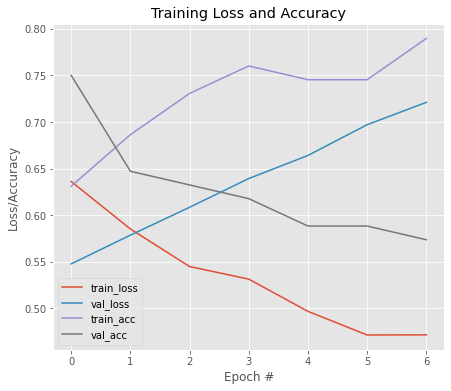


Model Performance Summary:

Best Validation accuracy:0.75 at EPOCH:1
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.4972 - accuracy: 0.7454
Epoch 1: val_accuracy improved from -inf to 0.45588, saving model to MobileNetV2_a_1.hdf5
9/9 [==============================] - 11s 429ms/step - loss: 0.4972 - accuracy: 0.7454 - val_loss: 0.9272 - val_accuracy: 0.4559
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.4505 - accuracy: 0.7823
Epoch 2: val_accuracy did not improve from 0.45588
9/9 [==============================] - 3s 303ms/step - loss: 0.4505 - accuracy: 0.7823 - val_loss: 0.9293 - val_accuracy: 0.4559
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.7897
Epoch 3: val_accuracy improved from 0.45588 to 0.47059, saving model to MobileNetV2_a_1.hdf5
9/9 [==============================] - 3s 349ms/step - loss: 0.4442 - accuracy: 0.7897 - val_loss: 0.9114 - val_accuracy: 0.4706
Epoch 4/50
9/9 [

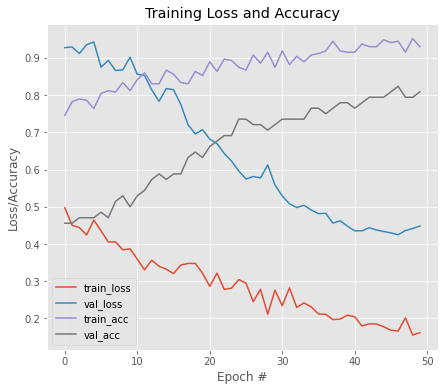


Model Performance Summary:

Best Validation accuracy:0.8235294222831726 at EPOCH:47
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9262
Epoch 1: val_accuracy improved from -inf to 0.82353, saving model to MobileNetV2_b_1.hdf5
9/9 [==============================] - 11s 421ms/step - loss: 0.1948 - accuracy: 0.9262 - val_loss: 0.4334 - val_accuracy: 0.8235
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9410
Epoch 2: val_accuracy did not improve from 0.82353
9/9 [==============================] - 3s 295ms/step - loss: 0.1911 - accuracy: 0.9410 - val_loss: 0.4371 - val_accuracy: 0.8235
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9483
Epoch 3: val_accuracy did not improve from 0.82353
9/9 [==============================] - 3s 331ms/step - loss: 0.1466 - accuracy: 0.9483 - val_loss: 0.4351 - val_accuracy: 0.8235
Epoch 4/50
9/9 [==============================] - ETA: 0s -

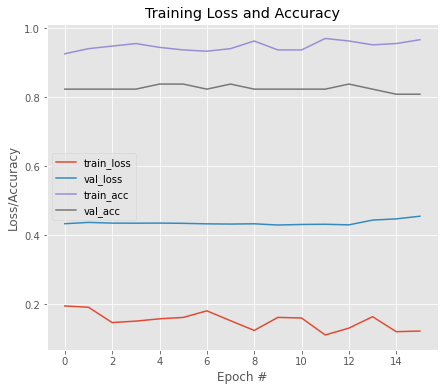


Model Performance Summary:

Best Validation accuracy:0.8382353186607361 at EPOCH:5
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9557
Epoch 1: val_accuracy improved from -inf to 0.70588, saving model to MobileNetV2_a_2.hdf5
9/9 [==============================] - 11s 429ms/step - loss: 0.1288 - accuracy: 0.9557 - val_loss: 0.6286 - val_accuracy: 0.7059
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.9151
Epoch 2: val_accuracy did not improve from 0.70588
9/9 [==============================] - 3s 303ms/step - loss: 0.1825 - accuracy: 0.9151 - val_loss: 0.6372 - val_accuracy: 0.7059
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.9631
Epoch 3: val_accuracy did not improve from 0.70588
9/9 [==============================] - 3s 309ms/step - loss: 0.1261 - accuracy: 0.9631 - val_loss: 0.6463 - val_accuracy: 0.7059
Epoch 4/50
9/9 [============================

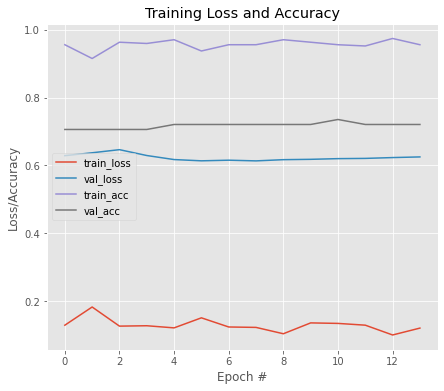


Model Performance Summary:

Best Validation accuracy:0.7352941036224365 at EPOCH:11
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9557
Epoch 1: val_accuracy improved from -inf to 0.72059, saving model to MobileNetV2_b_2.hdf5
9/9 [==============================] - 11s 436ms/step - loss: 0.1244 - accuracy: 0.9557 - val_loss: 0.6284 - val_accuracy: 0.7206
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9779
Epoch 2: val_accuracy improved from 0.72059 to 0.73529, saving model to MobileNetV2_b_2.hdf5
9/9 [==============================] - 3s 358ms/step - loss: 0.0834 - accuracy: 0.9779 - val_loss: 0.6297 - val_accuracy: 0.7353
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.9668
Epoch 3: val_accuracy did not improve from 0.73529
9/9 [==============================] - 3s 305ms/step - loss: 0.1036 - accuracy: 0.9668 - val_loss: 0.6285 - val_accuracy: 0.7353
Epoch 4/50
9/9 [=

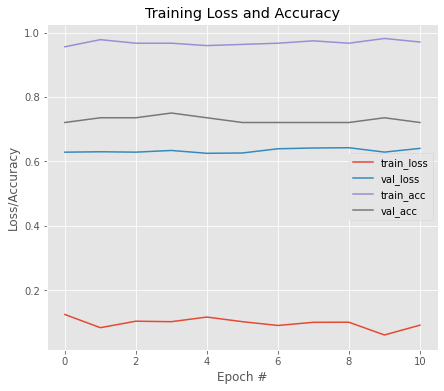


Model Performance Summary:

Best Validation accuracy:0.75 at EPOCH:4
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.9742
Epoch 1: val_accuracy improved from -inf to 0.76471, saving model to MobileNetV2_a_3.hdf5
9/9 [==============================] - 11s 430ms/step - loss: 0.0804 - accuracy: 0.9742 - val_loss: 0.5284 - val_accuracy: 0.7647
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9705
Epoch 2: val_accuracy did not improve from 0.76471
9/9 [==============================] - 3s 312ms/step - loss: 0.0872 - accuracy: 0.9705 - val_loss: 0.5231 - val_accuracy: 0.7353
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9742
Epoch 3: val_accuracy did not improve from 0.76471
9/9 [==============================] - 3s 305ms/step - loss: 0.0978 - accuracy: 0.9742 - val_loss: 0.5290 - val_accuracy: 0.7500
Epoch 4/50
9/9 [==============================] - ETA: 0s 

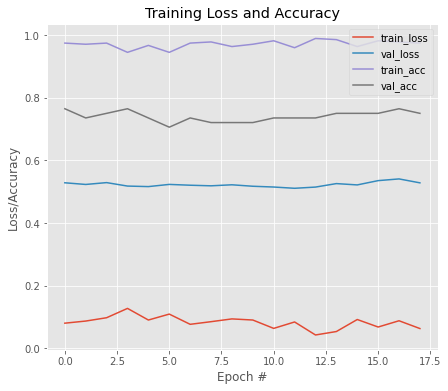


Model Performance Summary:

Best Validation accuracy:0.7647058963775635 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9742
Epoch 1: val_accuracy improved from -inf to 0.73529, saving model to MobileNetV2_b_3.hdf5
9/9 [==============================] - 11s 434ms/step - loss: 0.0915 - accuracy: 0.9742 - val_loss: 0.5896 - val_accuracy: 0.7353
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1012 - accuracy: 0.9631
Epoch 2: val_accuracy did not improve from 0.73529
9/9 [==============================] - 3s 307ms/step - loss: 0.1012 - accuracy: 0.9631 - val_loss: 0.5703 - val_accuracy: 0.7353
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0940 - accuracy: 0.9668
Epoch 3: val_accuracy did not improve from 0.73529
9/9 [==============================] - 3s 292ms/step - loss: 0.0940 - accuracy: 0.9668 - val_loss: 0.5718 - val_accuracy: 0.7353
Epoch 4/50
9/9 [==============================] - ETA: 0s - 

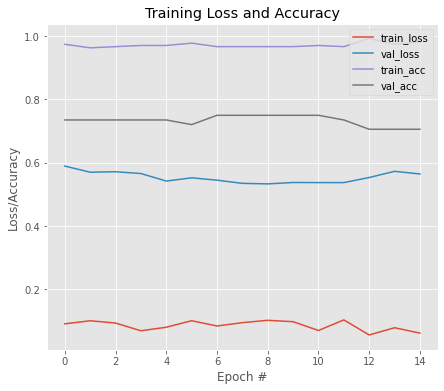


Model Performance Summary:

Best Validation accuracy:0.75 at EPOCH:7
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9669
Epoch 1: val_accuracy improved from -inf to 0.74627, saving model to MobileNetV2_a_4.hdf5
9/9 [==============================] - 12s 529ms/step - loss: 0.0744 - accuracy: 0.9669 - val_loss: 0.4604 - val_accuracy: 0.7463
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9706
Epoch 2: val_accuracy improved from 0.74627 to 0.76119, saving model to MobileNetV2_a_4.hdf5
9/9 [==============================] - 3s 338ms/step - loss: 0.0740 - accuracy: 0.9706 - val_loss: 0.4532 - val_accuracy: 0.7612
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9632
Epoch 3: val_accuracy did not improve from 0.76119
9/9 [==============================] - 3s 296ms/step - loss: 0.0878 - accuracy: 0.9632 - val_loss: 0.4548 - val_accuracy: 0.7612
Epoch 4/50
9/9 [

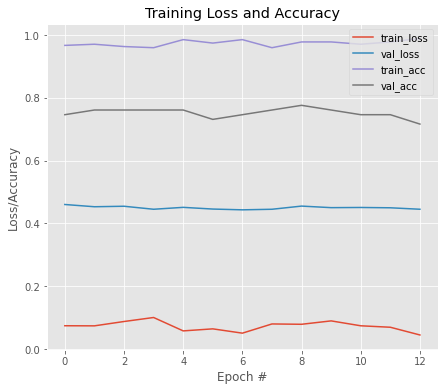


Model Performance Summary:

Best Validation accuracy:0.7761194109916687 at EPOCH:9
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9779
Epoch 1: val_accuracy improved from -inf to 0.74627, saving model to MobileNetV2_b_4.hdf5
9/9 [==============================] - 11s 435ms/step - loss: 0.0475 - accuracy: 0.9779 - val_loss: 0.4541 - val_accuracy: 0.7463
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9816
Epoch 2: val_accuracy improved from 0.74627 to 0.76119, saving model to MobileNetV2_b_4.hdf5
9/9 [==============================] - 3s 346ms/step - loss: 0.0535 - accuracy: 0.9816 - val_loss: 0.4420 - val_accuracy: 0.7612
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9779
Epoch 3: val_accuracy improved from 0.76119 to 0.77612, saving model to MobileNetV2_b_4.hdf5
9/9 [==============================] - 3s 336ms/step - loss: 0.0876 - accuracy: 0.9779 - val_loss: 0.4460

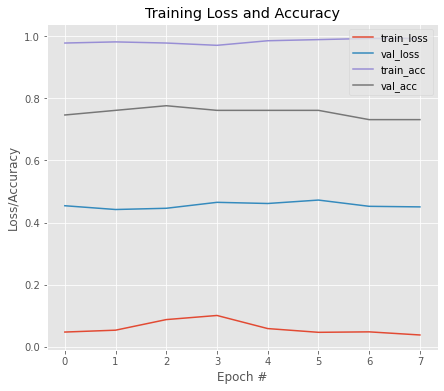


Model Performance Summary:

Best Validation accuracy:0.7761194109916687 at EPOCH:3
Average Accuracy:0.772870945930481
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.5719 - accuracy: 0.7168
Epoch 1: val_accuracy improved from -inf to 0.73288, saving model to MobileNetV2_wt.hdf5
11/11 [==============================] - 7s 449ms/step - loss: 0.5719 - accuracy: 0.7168 - val_loss: 0.5659 - val_accuracy: 0.7329
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.5531 - accuracy: 0.7257
Epoch 2: val_accuracy improved from 0.73288 to 0.73973, saving model to MobileNetV2_wt.hdf5
11/11 [==============================] - 4s 330ms/step - loss: 0.5531 - accuracy: 0.7257 - val_loss: 0.5728 - val_accuracy: 0.7397
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.5580 - accuracy: 0.7286
Epoch 3: val_accuracy did not improve from 0.73973
11/11 [======================

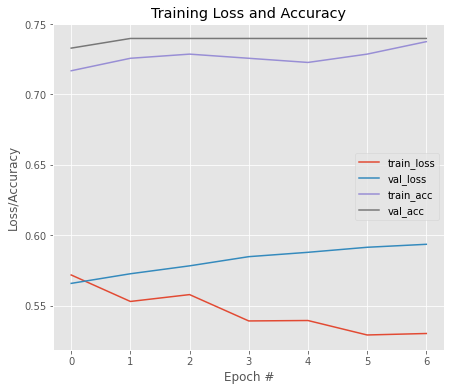


Model Performance Summary:

Best Validation accuracy:0.7397260069847107 at EPOCH:2
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9204
Epoch 1: val_accuracy improved from -inf to 0.73288, saving model to MobileNetV2_wt.hdf5
11/11 [==============================] - 12s 418ms/step - loss: 0.1734 - accuracy: 0.9204 - val_loss: 0.5765 - val_accuracy: 0.7329
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.9381
Epoch 2: val_accuracy improved from 0.73288 to 0.74658, saving model to MobileNetV2_wt.hdf5
11/11 [==============================] - 4s 350ms/step - loss: 0.1725 - accuracy: 0.9381 - val_loss: 0.5177 - val_accuracy: 0.7466
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.1453 - accuracy: 0.9499
Epoch 3: val_accuracy improved from 0.74658 to 0.76027, saving model to MobileNetV2_wt.hdf5
11/11 [==============================] - 4s 347ms/s

In [ ]:
nasnetmobile_model_obj = HIGH_LEVEL_MODEL("MobileNetV2")
nasnetmobile_model_obj.train_phase(training_images,training_label,test_images,test_label)

INCEPTIONRESNETV2

219070464/219055592 [==============================] - 3s 0us/step
Model: "InceptionResNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 54,339,810
Trainable params: 3,074
Non-trainable params: 54,336,736
_________________________________________________________________
None
Starting fold 0
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 1.1392 - ac

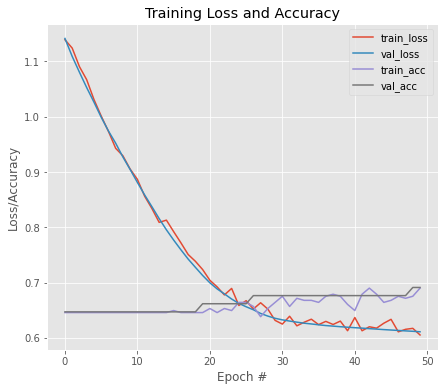


Model Performance Summary:

Best Validation accuracy:0.6911764740943909 at EPOCH:49
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.7697 - accuracy: 0.3985
Epoch 1: val_accuracy improved from -inf to 0.69118, saving model to InceptionResNetV2_b_0.hdf5
9/9 [==============================] - 46s 1s/step - loss: 0.7697 - accuracy: 0.3985 - val_loss: 0.5944 - val_accuracy: 0.6912
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.6535 - accuracy: 0.5609
Epoch 2: val_accuracy improved from 0.69118 to 0.72059, saving model to InceptionResNetV2_b_0.hdf5
9/9 [==============================] - 8s 918ms/step - loss: 0.6535 - accuracy: 0.5609 - val_loss: 0.5835 - val_accuracy: 0.7206
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.6272 - accuracy: 0.6273
Epoch 3: val_accuracy improved from 0.72059 to 0.75000, saving model to InceptionResNetV2_b_0.hdf5
9/9 [==============================] - 8s 871ms/step - loss: 0.6272 - accuracy: 0.6273 - 

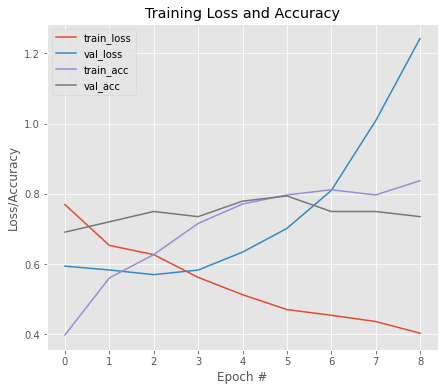


Model Performance Summary:

Best Validation accuracy:0.7941176295280457 at EPOCH:6
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.4037 - accuracy: 0.8192
Epoch 1: val_accuracy improved from -inf to 0.69118, saving model to InceptionResNetV2_a_1.hdf5
9/9 [==============================] - 43s 1s/step - loss: 0.4037 - accuracy: 0.8192 - val_loss: 2.8704 - val_accuracy: 0.6912
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.3588 - accuracy: 0.8672
Epoch 2: val_accuracy did not improve from 0.69118
9/9 [==============================] - 6s 620ms/step - loss: 0.3588 - accuracy: 0.8672 - val_loss: 3.9840 - val_accuracy: 0.6765
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8450
Epoch 3: val_accuracy did not improve from 0.69118
9/9 [==============================] - 6s 628ms/step - loss: 0.3456 - accuracy: 0.8450 - val_loss: 4.6383 - val_accuracy: 0.6765
Epoch 4/50
9/9 [=========================

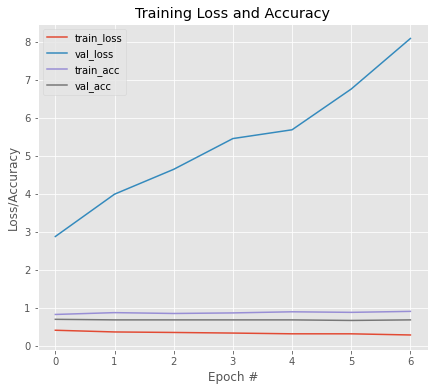


Model Performance Summary:

Best Validation accuracy:0.6911764740943909 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3475 - accuracy: 0.8561
Epoch 1: val_accuracy improved from -inf to 0.69118, saving model to InceptionResNetV2_b_1.hdf5
9/9 [==============================] - 43s 1s/step - loss: 0.3475 - accuracy: 0.8561 - val_loss: 3.9220 - val_accuracy: 0.6912
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.3355 - accuracy: 0.8819
Epoch 2: val_accuracy did not improve from 0.69118
9/9 [==============================] - 6s 625ms/step - loss: 0.3355 - accuracy: 0.8819 - val_loss: 4.8238 - val_accuracy: 0.6765
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.9041
Epoch 3: val_accuracy did not improve from 0.69118
9/9 [==============================] - 6s 666ms/step - loss: 0.2982 - accuracy: 0.9041 - val_loss: 5.3296 - val_accuracy: 0.6765
Epoch 4/50
9/9 [==============================] - ETA: 0s

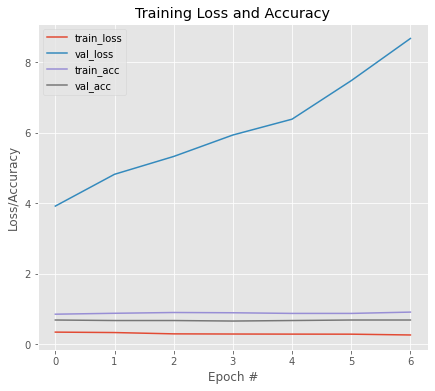


Model Performance Summary:

Best Validation accuracy:0.6911764740943909 at EPOCH:1
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9410
Epoch 1: val_accuracy improved from -inf to 0.64706, saving model to InceptionResNetV2_a_2.hdf5
9/9 [==============================] - 43s 1s/step - loss: 0.2054 - accuracy: 0.9410 - val_loss: 6.1309 - val_accuracy: 0.6471
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9557
Epoch 2: val_accuracy did not improve from 0.64706
9/9 [==============================] - 6s 622ms/step - loss: 0.1899 - accuracy: 0.9557 - val_loss: 6.3244 - val_accuracy: 0.6471
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9262
Epoch 3: val_accuracy did not improve from 0.64706
9/9 [==============================] - 6s 664ms/step - loss: 0.1979 - accuracy: 0.9262 - val_loss: 7.1113 - val_accuracy: 0.6324
Epoch 4/50
9/9 [=========================

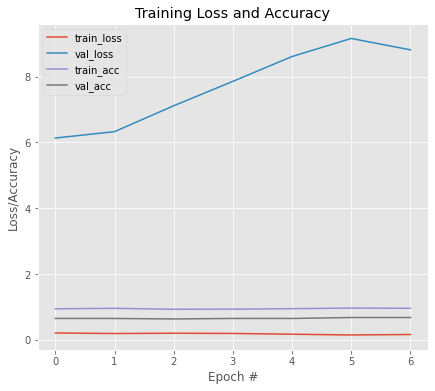


Model Performance Summary:

Best Validation accuracy:0.6764705777168274 at EPOCH:6
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.9373
Epoch 1: val_accuracy improved from -inf to 0.67647, saving model to InceptionResNetV2_b_2.hdf5
9/9 [==============================] - 42s 1s/step - loss: 0.1606 - accuracy: 0.9373 - val_loss: 9.4001 - val_accuracy: 0.6765
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9631
Epoch 2: val_accuracy did not improve from 0.67647
9/9 [==============================] - 6s 623ms/step - loss: 0.1140 - accuracy: 0.9631 - val_loss: 8.6948 - val_accuracy: 0.6765
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9557
Epoch 3: val_accuracy did not improve from 0.67647
9/9 [==============================] - 6s 665ms/step - loss: 0.1577 - accuracy: 0.9557 - val_loss: 8.6108 - val_accuracy: 0.6765
Epoch 4/50
9/9 [==============================] - ETA: 0s

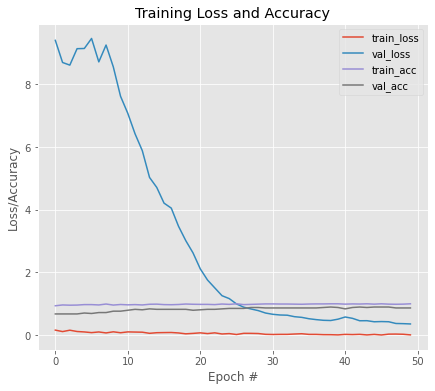


Model Performance Summary:

Best Validation accuracy:0.8970588445663452 at EPOCH:39
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9631
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionResNetV2_a_3.hdf5
9/9 [==============================] - 42s 1s/step - loss: 0.1331 - accuracy: 0.9631 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9631
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 6s 626ms/step - loss: 0.1032 - accuracy: 0.9631 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9742
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 6s 632ms/step - loss: 0.0509 - accuracy: 0.9742 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 4/50
9/9 [========================

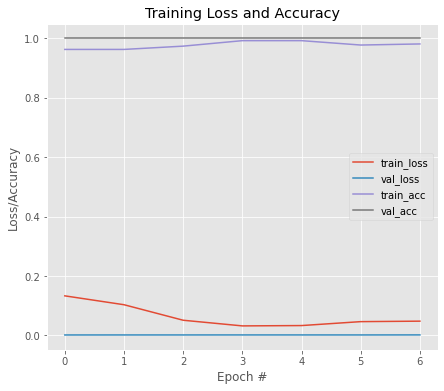


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9483
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionResNetV2_b_3.hdf5
9/9 [==============================] - 44s 1s/step - loss: 0.1327 - accuracy: 0.9483 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9594
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 6s 623ms/step - loss: 0.0881 - accuracy: 0.9594 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9668
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 6s 632ms/step - loss: 0.0694 - accuracy: 0.9668 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0848

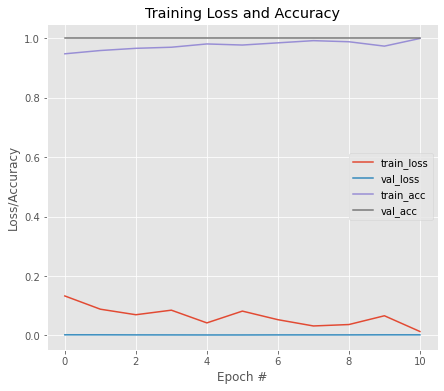


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9853
Epoch 1: val_accuracy improved from -inf to 0.98507, saving model to InceptionResNetV2_a_4.hdf5
9/9 [==============================] - 45s 2s/step - loss: 0.0520 - accuracy: 0.9853 - val_loss: 0.0596 - val_accuracy: 0.9851
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9779
Epoch 2: val_accuracy did not improve from 0.98507
9/9 [==============================] - 6s 625ms/step - loss: 0.0467 - accuracy: 0.9779 - val_loss: 0.0702 - val_accuracy: 0.9851
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9743
Epoch 3: val_accuracy did not improve from 0.98507
9/9 [==============================] - 6s 630ms/step - loss: 0.0573 - accuracy: 0.9743 - val_loss: 0.0700 - val_accuracy: 0.9851
Epoch 4/50
9/9 [==============================] - ETA: 0

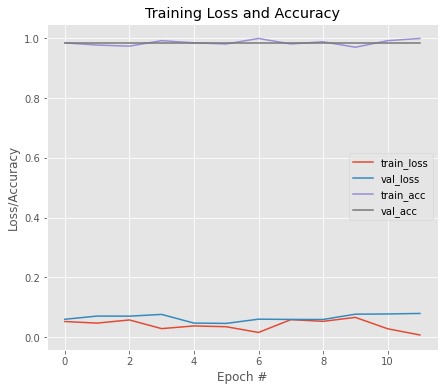


Model Performance Summary:

Best Validation accuracy:0.9850746393203735 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9963
Epoch 1: val_accuracy improved from -inf to 0.98507, saving model to InceptionResNetV2_b_4.hdf5
9/9 [==============================] - 44s 1s/step - loss: 0.0162 - accuracy: 0.9963 - val_loss: 0.0666 - val_accuracy: 0.9851
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9890
Epoch 2: val_accuracy did not improve from 0.98507
9/9 [==============================] - 6s 621ms/step - loss: 0.0249 - accuracy: 0.9890 - val_loss: 0.0717 - val_accuracy: 0.9851
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9743
Epoch 3: val_accuracy did not improve from 0.98507
9/9 [==============================] - 6s 629ms/step - loss: 0.0624 - accuracy: 0.9743 - val_loss: 0.0849 - val_accuracy: 0.9851
Epoch 4/50
9/9 [==============================] - ETA: 0s

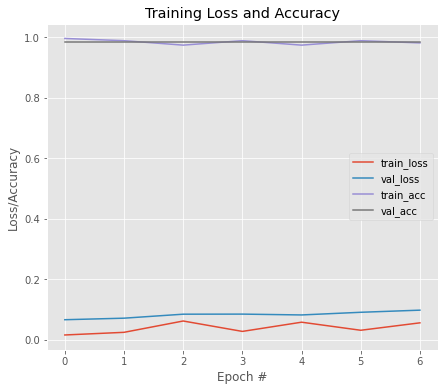


Model Performance Summary:

Best Validation accuracy:0.9850746393203735 at EPOCH:1
Average Accuracy:0.873485517501831
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.9853
Epoch 1: val_accuracy improved from -inf to 0.87671, saving model to InceptionResNetV2_wt.hdf5
11/11 [==============================] - 20s 1s/step - loss: 0.0804 - accuracy: 0.9853 - val_loss: 1.6841 - val_accuracy: 0.8767
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9705
Epoch 2: val_accuracy did not improve from 0.87671
11/11 [==============================] - 5s 430ms/step - loss: 0.1754 - accuracy: 0.9705 - val_loss: 1.6829 - val_accuracy: 0.8699
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9705
Epoch 3: val_accuracy did not improve from 0.87671
11/11 [==============================] - 5s 421ms/step - loss: 0.1

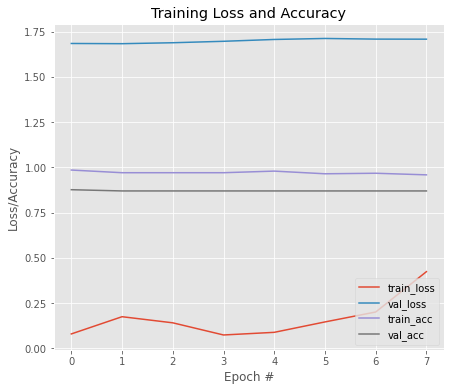


Model Performance Summary:

Best Validation accuracy:0.8767123222351074 at EPOCH:1
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9823
Epoch 1: val_accuracy improved from -inf to 0.84247, saving model to InceptionResNetV2_wt.hdf5
11/11 [==============================] - 46s 1s/step - loss: 0.0542 - accuracy: 0.9823 - val_loss: 1.8648 - val_accuracy: 0.8425
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 0.9764
Epoch 2: val_accuracy improved from 0.84247 to 0.86986, saving model to InceptionResNetV2_wt.hdf5
11/11 [==============================] - 10s 935ms/step - loss: 0.0674 - accuracy: 0.9764 - val_loss: 0.9783 - val_accuracy: 0.8699
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9912
Epoch 3: val_accuracy improved from 0.86986 to 0.88356, saving model to InceptionResNetV2_wt.hdf5
11/11 [============================

In [ ]:
inceptionresnetv2_model_obj = HIGH_LEVEL_MODEL("InceptionResNetV2")
inceptionresnetv2_model_obj.train_phase(training_images,training_label,test_images,test_label)

XCEPTION

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________
None
Starting fold 0
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.6494
Epoch 1: val_accuracy improved from -inf to 0.64706, saving mo

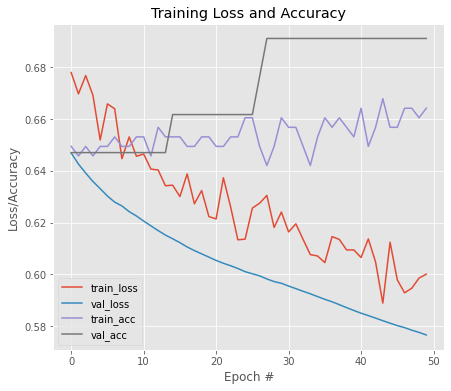


Model Performance Summary:

Best Validation accuracy:0.6911764740943909 at EPOCH:28
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6330 - accuracy: 0.6347
Epoch 1: val_accuracy improved from -inf to 0.69118, saving model to xception_b_0.hdf5
9/9 [==============================] - 18s 959ms/step - loss: 0.6330 - accuracy: 0.6347 - val_loss: 0.5768 - val_accuracy: 0.6912
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.6030 - accuracy: 0.6900
Epoch 2: val_accuracy did not improve from 0.69118
9/9 [==============================] - 6s 634ms/step - loss: 0.6030 - accuracy: 0.6900 - val_loss: 0.5584 - val_accuracy: 0.6765
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.7122
Epoch 3: val_accuracy did not improve from 0.69118
9/9 [==============================] - 6s 660ms/step - loss: 0.5728 - accuracy: 0.7122 - val_loss: 0.5459 - val_accuracy: 0.6765
Epoch 4/50
9/9 [==============================] - ETA: 0s - lo

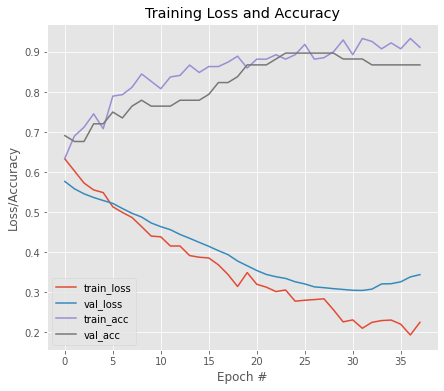


Model Performance Summary:

Best Validation accuracy:0.8970588445663452 at EPOCH:24
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9373
Epoch 1: val_accuracy improved from -inf to 0.95588, saving model to xception_a_1.hdf5
9/9 [==============================] - 15s 768ms/step - loss: 0.2074 - accuracy: 0.9373 - val_loss: 0.1218 - val_accuracy: 0.9559
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9151
Epoch 2: val_accuracy did not improve from 0.95588
9/9 [==============================] - 6s 627ms/step - loss: 0.2184 - accuracy: 0.9151 - val_loss: 0.1171 - val_accuracy: 0.9559
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.9077
Epoch 3: val_accuracy did not improve from 0.95588
9/9 [==============================] - 6s 673ms/step - loss: 0.2281 - accuracy: 0.9077 - val_loss: 0.1143 - val_accuracy: 0.9559
Epoch 4/50
9/9 [==============================

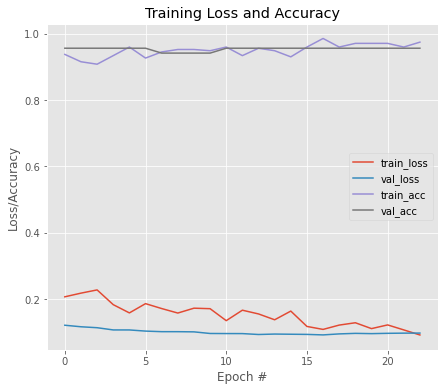


Model Performance Summary:

Best Validation accuracy:0.9558823704719543 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.9446
Epoch 1: val_accuracy improved from -inf to 0.95588, saving model to xception_b_1.hdf5
9/9 [==============================] - 14s 770ms/step - loss: 0.1808 - accuracy: 0.9446 - val_loss: 0.1142 - val_accuracy: 0.9559
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.9225
Epoch 2: val_accuracy did not improve from 0.95588
9/9 [==============================] - 6s 667ms/step - loss: 0.2188 - accuracy: 0.9225 - val_loss: 0.1155 - val_accuracy: 0.9559
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9225
Epoch 3: val_accuracy did not improve from 0.95588
9/9 [==============================] - 6s 637ms/step - loss: 0.1859 - accuracy: 0.9225 - val_loss: 0.1166 - val_accuracy: 0.9559
Epoch 4/50
9/9 [==============================] - ETA: 0s - los

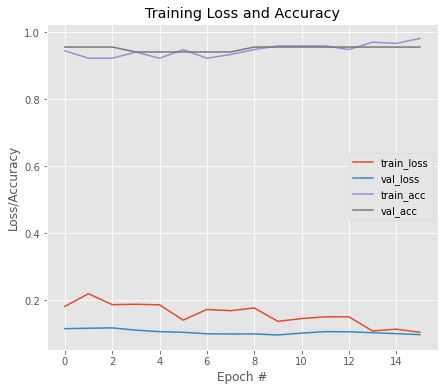


Model Performance Summary:

Best Validation accuracy:0.9558823704719543 at EPOCH:1
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9446
Epoch 1: val_accuracy improved from -inf to 0.97059, saving model to xception_a_2.hdf5
9/9 [==============================] - 14s 769ms/step - loss: 0.1412 - accuracy: 0.9446 - val_loss: 0.0912 - val_accuracy: 0.9706
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9815
Epoch 2: val_accuracy did not improve from 0.97059
9/9 [==============================] - 6s 628ms/step - loss: 0.0784 - accuracy: 0.9815 - val_loss: 0.0901 - val_accuracy: 0.9706
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9594
Epoch 3: val_accuracy did not improve from 0.97059
9/9 [==============================] - 6s 639ms/step - loss: 0.1134 - accuracy: 0.9594 - val_loss: 0.0905 - val_accuracy: 0.9706
Epoch 4/50
9/9 [==============================]

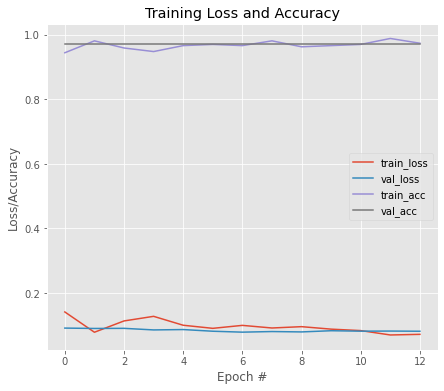


Model Performance Summary:

Best Validation accuracy:0.970588207244873 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9557
Epoch 1: val_accuracy improved from -inf to 0.97059, saving model to xception_b_2.hdf5
9/9 [==============================] - 14s 763ms/step - loss: 0.1129 - accuracy: 0.9557 - val_loss: 0.0830 - val_accuracy: 0.9706
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9446
Epoch 2: val_accuracy did not improve from 0.97059
9/9 [==============================] - 6s 618ms/step - loss: 0.1300 - accuracy: 0.9446 - val_loss: 0.0849 - val_accuracy: 0.9706
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9742
Epoch 3: val_accuracy did not improve from 0.97059
9/9 [==============================] - 6s 627ms/step - loss: 0.0974 - accuracy: 0.9742 - val_loss: 0.0826 - val_accuracy: 0.9706
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss

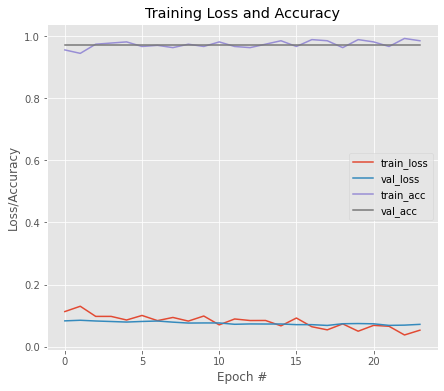


Model Performance Summary:

Best Validation accuracy:0.970588207244873 at EPOCH:1
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9668
Epoch 1: val_accuracy improved from -inf to 0.98529, saving model to xception_a_3.hdf5
9/9 [==============================] - 14s 776ms/step - loss: 0.0808 - accuracy: 0.9668 - val_loss: 0.0360 - val_accuracy: 0.9853
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9852
Epoch 2: val_accuracy did not improve from 0.98529
9/9 [==============================] - 6s 623ms/step - loss: 0.0529 - accuracy: 0.9852 - val_loss: 0.0365 - val_accuracy: 0.9853
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9742
Epoch 3: val_accuracy improved from 0.98529 to 1.00000, saving model to xception_a_3.hdf5
9/9 [==============================] - 7s 704ms/step - loss: 0.0755 - accuracy: 0.9742 - val_loss: 0.0340 - val_accuracy: 1.0000
Epoch 4/5

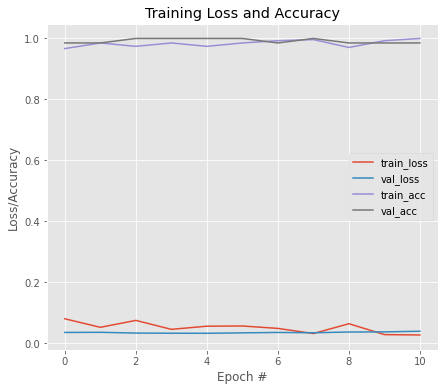


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9926
Epoch 1: val_accuracy improved from -inf to 0.98529, saving model to xception_b_3.hdf5
9/9 [==============================] - 14s 809ms/step - loss: 0.0433 - accuracy: 0.9926 - val_loss: 0.0382 - val_accuracy: 0.9853
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9815
Epoch 2: val_accuracy did not improve from 0.98529
9/9 [==============================] - 6s 616ms/step - loss: 0.0550 - accuracy: 0.9815 - val_loss: 0.0398 - val_accuracy: 0.9853
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0561 - accuracy: 0.9852
Epoch 3: val_accuracy did not improve from 0.98529
9/9 [==============================] - 6s 626ms/step - loss: 0.0561 - accuracy: 0.9852 - val_loss: 0.0396 - val_accuracy: 0.9853
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0559 - acc

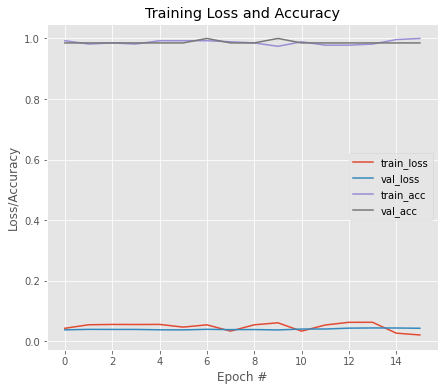


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:7
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9963
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to xception_a_4.hdf5
9/9 [==============================] - 17s 1s/step - loss: 0.0292 - accuracy: 0.9963 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 0.9926
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 6s 629ms/step - loss: 0.0366 - accuracy: 0.9926 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 6s 639ms/step - loss: 0.0254 - accuracy: 0.9963 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss:

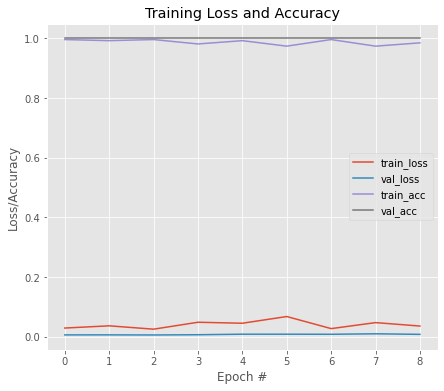


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9926
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to xception_b_4.hdf5
9/9 [==============================] - 15s 777ms/step - loss: 0.0288 - accuracy: 0.9926 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9890
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 6s 620ms/step - loss: 0.0275 - accuracy: 0.9890 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9890
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 6s 626ms/step - loss: 0.0357 - accuracy: 0.9890 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0404 - acc

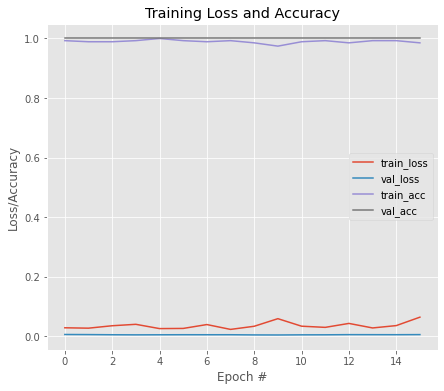


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Average Accuracy:0.9647058844566345
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9971
Epoch 1: val_accuracy improved from -inf to 0.91096, saving model to xception_wt.hdf5
11/11 [==============================] - 9s 602ms/step - loss: 0.0246 - accuracy: 0.9971 - val_loss: 0.2511 - val_accuracy: 0.9110
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9971
Epoch 2: val_accuracy did not improve from 0.91096
11/11 [==============================] - 4s 388ms/step - loss: 0.0242 - accuracy: 0.9971 - val_loss: 0.2518 - val_accuracy: 0.9110
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9882
Epoch 3: val_accuracy did not improve from 0.91096
11/11 [==============================] - 4s 367ms/step - loss: 0.0337 - accuracy: 0.988

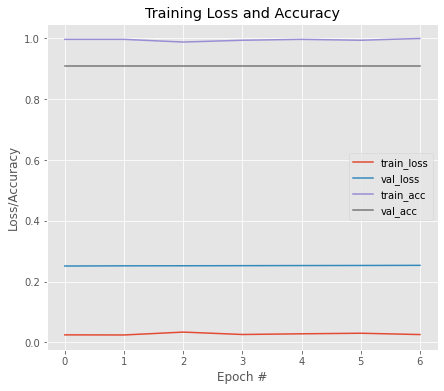


Model Performance Summary:

Best Validation accuracy:0.9109588861465454 at EPOCH:1
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9912
Epoch 1: val_accuracy improved from -inf to 0.91096, saving model to xception_wt.hdf5
11/11 [==============================] - 18s 973ms/step - loss: 0.0316 - accuracy: 0.9912 - val_loss: 0.2550 - val_accuracy: 0.9110
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9853
Epoch 2: val_accuracy did not improve from 0.91096
11/11 [==============================] - 8s 698ms/step - loss: 0.0583 - accuracy: 0.9853 - val_loss: 0.2591 - val_accuracy: 0.9041
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9735
Epoch 3: val_accuracy did not improve from 0.91096
11/11 [==============================] - 8s 699ms/step - loss: 0.0642 - accuracy: 0.9735 - val_loss: 0.2532 - val_accuracy: 0.9110
Epoch

In [ ]:
xception_model_obj = HIGH_LEVEL_MODEL("xception")
xception_model_obj.train_phase(training_images,training_label,test_images,test_label)

# PLOT PERFORMANCE

Model  Accuracy  Sensitivity       AUC
0              vgg16  0.938356     0.989362  0.917758
1              vgg19  0.924658     0.936170  0.920008
2           resnet50  0.643836     1.000000  0.500000
3        DenseNet121  0.931507     0.914894  0.938216
4          MobileNet  0.938356     0.936170  0.939239
5        InceptionV3  0.890411     0.957447  0.863339
6  InceptionResNetV2  0.904110     0.925532  0.895458
7        MobileNetV2  0.773973     0.925532  0.712766
8           xception  0.917808     0.957447  0.901800

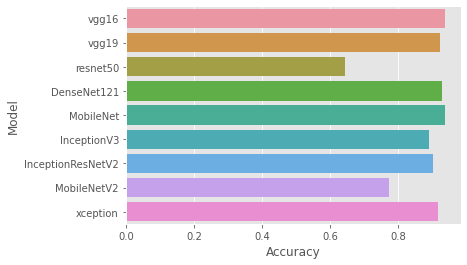

In [ ]:
plot_overall_performance()

# Without Data Augmentation

In [ ]:
MODEL_LIST = ['vgg16','vgg19','resnet50','DenseNet121','MobileNet','MobileNetV2','InceptionV3','InceptionResNetV2','xception']

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________
None
Starting fold 0
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.7484 - accuracy: 0.3542
Epoch 1: val_accuracy improved from -inf to 0.35294, saving model

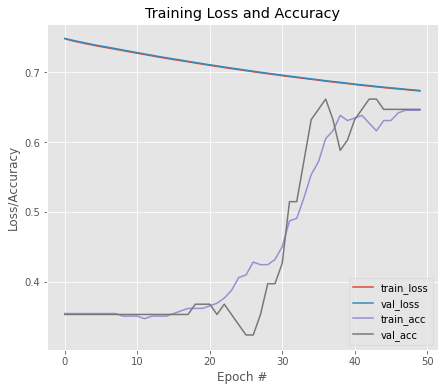


Model Performance Summary:

Best Validation accuracy:0.6617646813392639 at EPOCH:37
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6448 - accuracy: 0.6568
Epoch 1: val_accuracy improved from -inf to 0.70588, saving model to vgg16_b_0.hdf5
9/9 [==============================] - 6s 362ms/step - loss: 0.6448 - accuracy: 0.6568 - val_loss: 0.6116 - val_accuracy: 0.7059
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.5896 - accuracy: 0.6937
Epoch 2: val_accuracy improved from 0.70588 to 0.77941, saving model to vgg16_b_0.hdf5
9/9 [==============================] - 2s 270ms/step - loss: 0.5896 - accuracy: 0.6937 - val_loss: 0.5907 - val_accuracy: 0.7794
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.5687 - accuracy: 0.7343
Epoch 3: val_accuracy did not improve from 0.77941
9/9 [==============================] - 2s 233ms/step - loss: 0.5687 - accuracy: 0.7343 - val_loss: 0.5366 - val_accuracy: 0.7353
Epoch 4/50
9/9 [==============

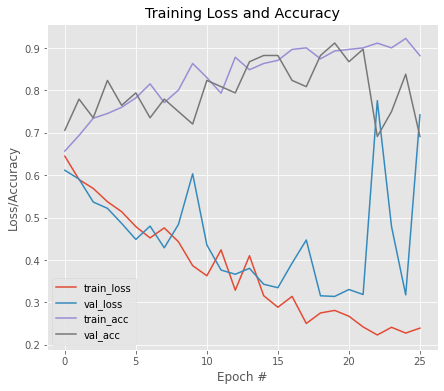


Model Performance Summary:

Best Validation accuracy:0.9117646813392639 at EPOCH:20
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8487
Epoch 1: val_accuracy improved from -inf to 0.97059, saving model to vgg16_a_1.hdf5
9/9 [==============================] - 4s 280ms/step - loss: 0.3574 - accuracy: 0.8487 - val_loss: 0.1522 - val_accuracy: 0.9706
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.9225
Epoch 2: val_accuracy did not improve from 0.97059
9/9 [==============================] - 2s 235ms/step - loss: 0.2660 - accuracy: 0.9225 - val_loss: 0.1215 - val_accuracy: 0.9559
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.8782
Epoch 3: val_accuracy did not improve from 0.97059
9/9 [==============================] - 2s 234ms/step - loss: 0.2852 - accuracy: 0.8782 - val_loss: 0.1293 - val_accuracy: 0.9706
Epoch 4/50
9/9 [==============================] - 

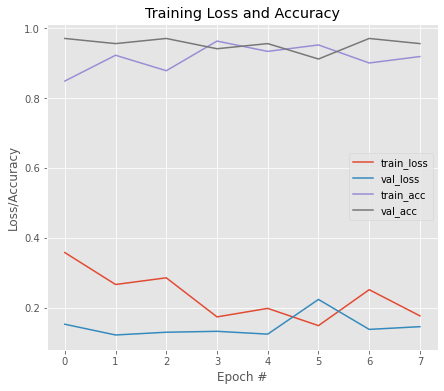


Model Performance Summary:

Best Validation accuracy:0.970588207244873 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3902 - accuracy: 0.9225
Epoch 1: val_accuracy improved from -inf to 0.97059, saving model to vgg16_b_1.hdf5
9/9 [==============================] - 4s 282ms/step - loss: 0.3902 - accuracy: 0.9225 - val_loss: 0.1282 - val_accuracy: 0.9706
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.9299
Epoch 2: val_accuracy did not improve from 0.97059
9/9 [==============================] - 2s 234ms/step - loss: 0.1989 - accuracy: 0.9299 - val_loss: 0.1952 - val_accuracy: 0.9118
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9114
Epoch 3: val_accuracy did not improve from 0.97059
9/9 [==============================] - 2s 233ms/step - loss: 0.2192 - accuracy: 0.9114 - val_loss: 0.1380 - val_accuracy: 0.9706
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.

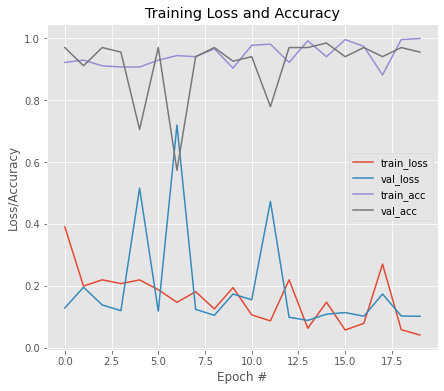


Model Performance Summary:

Best Validation accuracy:0.9852941036224365 at EPOCH:15
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.4554 - accuracy: 0.9114
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to vgg16_a_2.hdf5
9/9 [==============================] - 4s 283ms/step - loss: 0.4554 - accuracy: 0.9114 - val_loss: 0.0647 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9963
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 235ms/step - loss: 0.0439 - accuracy: 0.9963 - val_loss: 0.0570 - val_accuracy: 0.9853
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9557
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 234ms/step - loss: 0.1140 - accuracy: 0.9557 - val_loss: 0.5339 - val_accuracy: 0.6912
Epoch 4/50
9/9 [==============================] - 

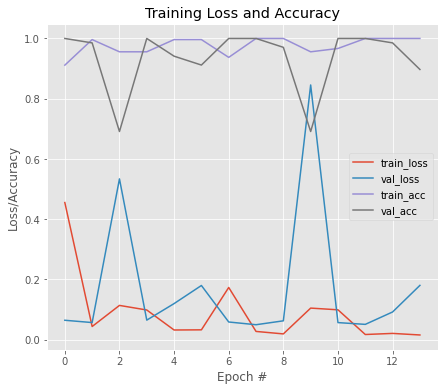


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.4965 - accuracy: 0.9410
Epoch 1: val_accuracy improved from -inf to 0.98529, saving model to vgg16_b_2.hdf5
9/9 [==============================] - 4s 282ms/step - loss: 0.4965 - accuracy: 0.9410 - val_loss: 0.0651 - val_accuracy: 0.9853
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9963
Epoch 2: val_accuracy did not improve from 0.98529
9/9 [==============================] - 2s 234ms/step - loss: 0.0370 - accuracy: 0.9963 - val_loss: 0.0531 - val_accuracy: 0.9853
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9963
Epoch 3: val_accuracy improved from 0.98529 to 1.00000, saving model to vgg16_b_2.hdf5
9/9 [==============================] - 2s 267ms/step - loss: 0.0337 - accuracy: 0.9963 - val_loss: 0.0577 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================

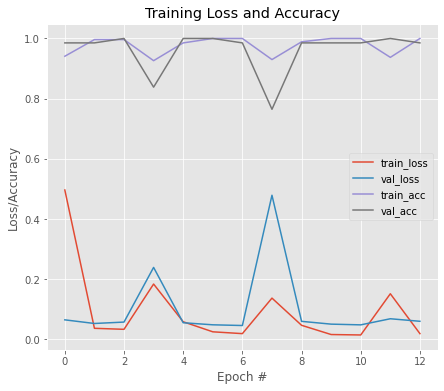


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:3
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.9631
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to vgg16_a_3.hdf5
9/9 [==============================] - 4s 281ms/step - loss: 0.3444 - accuracy: 0.9631 - val_loss: 0.0140 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9963
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 235ms/step - loss: 0.0251 - accuracy: 0.9963 - val_loss: 0.0277 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 234ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 

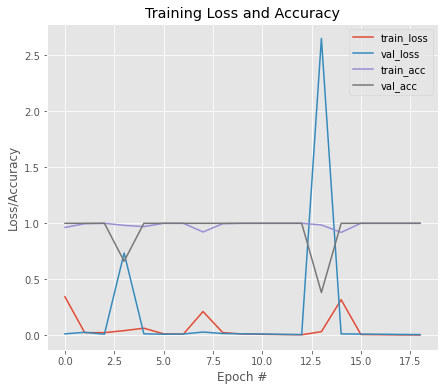


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.8856
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to vgg16_b_3.hdf5
9/9 [==============================] - 4s 282ms/step - loss: 0.6176 - accuracy: 0.8856 - val_loss: 0.0274 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9963
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 234ms/step - loss: 0.0288 - accuracy: 0.9963 - val_loss: 0.0191 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 233ms/step - loss: 0.0226 - accuracy: 0.9963 - val_loss: 0.0214 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0188 - accurac

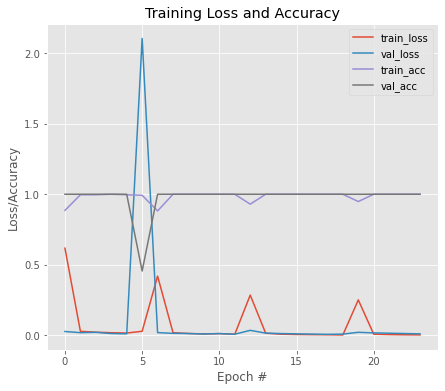


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.5585 - accuracy: 0.9338
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to vgg16_a_4.hdf5
9/9 [==============================] - 5s 430ms/step - loss: 0.5585 - accuracy: 0.9338 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 246ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 235ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 

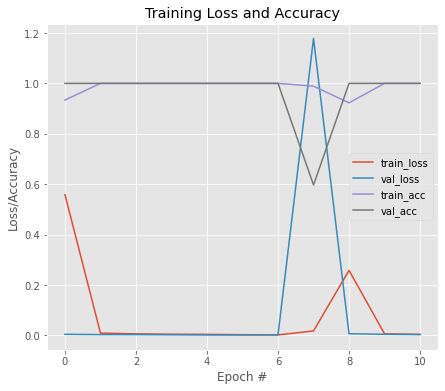


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3169 - accuracy: 0.9154
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to vgg16_b_4.hdf5
9/9 [==============================] - 4s 281ms/step - loss: 0.3169 - accuracy: 0.9154 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 234ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 233ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0044 - accurac

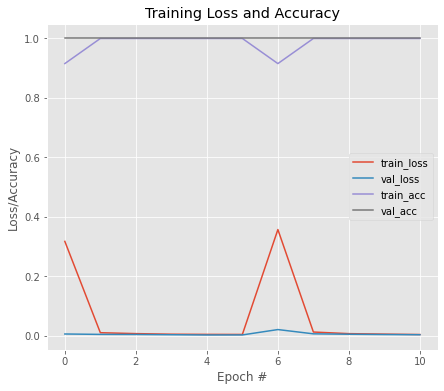


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Average Accuracy:0.9794117569923401
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.85616, saving model to vgg16_wt.hdf5
11/11 [==============================] - 3s 241ms/step - loss: 0.0379 - accuracy: 1.0000 - val_loss: 0.3131 - val_accuracy: 0.8562
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.85616 to 0.86301, saving model to vgg16_wt.hdf5
11/11 [==============================] - 1s 133ms/step - loss: 0.0368 - accuracy: 1.0000 - val_loss: 0.3100 - val_accuracy: 0.8630
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.86301 to 0.86986, saving model to vgg16_wt.hdf5
11/11 [=============

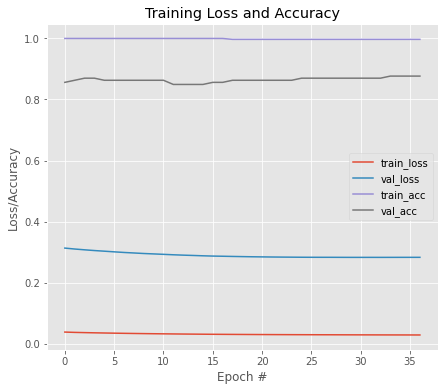


Model Performance Summary:

Best Validation accuracy:0.8767123222351074 at EPOCH:34
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.8643
Epoch 1: val_accuracy improved from -inf to 0.84247, saving model to vgg16_wt.hdf5
11/11 [==============================] - 5s 377ms/step - loss: 0.6829 - accuracy: 0.8643 - val_loss: 0.3431 - val_accuracy: 0.8425
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9587
Epoch 2: val_accuracy improved from 0.84247 to 0.86301, saving model to vgg16_wt.hdf5
11/11 [==============================] - 3s 281ms/step - loss: 0.1382 - accuracy: 0.9587 - val_loss: 0.3147 - val_accuracy: 0.8630
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.4145 - accuracy: 0.8761
Epoch 3: val_accuracy improved from 0.86301 to 0.87671, saving model to vgg16_wt.hdf5
11/11 [==============================] - 3s 284ms/step - loss: 0.4145

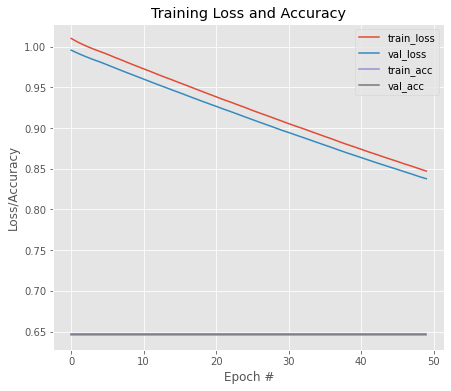


Model Performance Summary:

Best Validation accuracy:0.6470588445663452 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.6531
Epoch 1: val_accuracy improved from -inf to 0.64706, saving model to vgg19_b_0.hdf5
9/9 [==============================] - 4s 332ms/step - loss: 0.7048 - accuracy: 0.6531 - val_loss: 0.6266 - val_accuracy: 0.6471
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.6421
Epoch 2: val_accuracy improved from 0.64706 to 0.66176, saving model to vgg19_b_0.hdf5
9/9 [==============================] - 3s 316ms/step - loss: 0.6364 - accuracy: 0.6421 - val_loss: 0.6045 - val_accuracy: 0.6618
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.6716
Epoch 3: val_accuracy did not improve from 0.66176
9/9 [==============================] - 2s 274ms/step - loss: 0.6124 - accuracy: 0.6716 - val_loss: 0.5914 - val_accuracy: 0.6618
Epoch 4/50
9/9 [===============

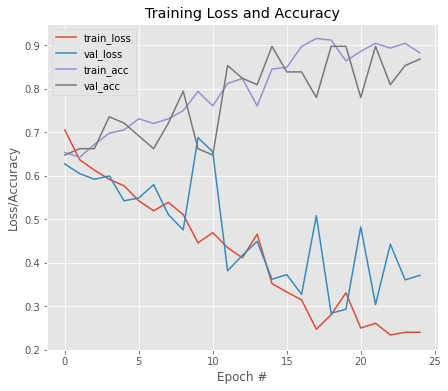


Model Performance Summary:

Best Validation accuracy:0.8970588445663452 at EPOCH:15
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.8450
Epoch 1: val_accuracy improved from -inf to 0.92647, saving model to vgg19_a_1.hdf5
9/9 [==============================] - 5s 350ms/step - loss: 0.5366 - accuracy: 0.8450 - val_loss: 0.1512 - val_accuracy: 0.9265
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9373
Epoch 2: val_accuracy improved from 0.92647 to 0.95588, saving model to vgg19_a_1.hdf5
9/9 [==============================] - 3s 320ms/step - loss: 0.1899 - accuracy: 0.9373 - val_loss: 0.1273 - val_accuracy: 0.9559
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.3184 - accuracy: 0.8893
Epoch 3: val_accuracy improved from 0.95588 to 0.97059, saving model to vgg19_a_1.hdf5
9/9 [==============================] - 3s 318ms/step - loss: 0.3184 - accuracy: 0.8893 - val_loss: 0.1060 -

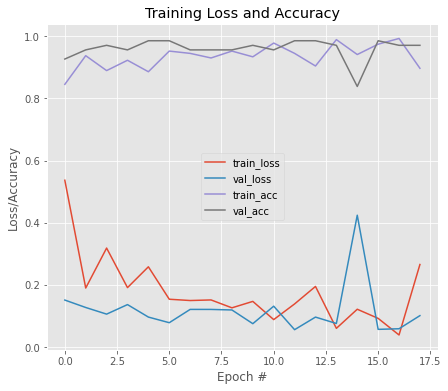


Model Performance Summary:

Best Validation accuracy:0.9852941036224365 at EPOCH:5
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.8930
Epoch 1: val_accuracy improved from -inf to 0.95588, saving model to vgg19_b_1.hdf5
9/9 [==============================] - 5s 332ms/step - loss: 0.3675 - accuracy: 0.8930 - val_loss: 0.1091 - val_accuracy: 0.9559
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9225
Epoch 2: val_accuracy did not improve from 0.95588
9/9 [==============================] - 2s 275ms/step - loss: 0.1939 - accuracy: 0.9225 - val_loss: 0.2561 - val_accuracy: 0.8971
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9594
Epoch 3: val_accuracy did not improve from 0.95588
9/9 [==============================] - 2s 275ms/step - loss: 0.1272 - accuracy: 0.9594 - val_loss: 0.0836 - val_accuracy: 0.9559
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0

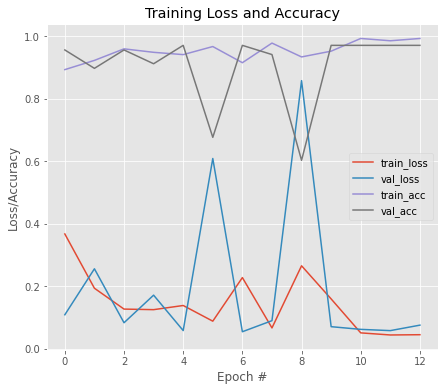


Model Performance Summary:

Best Validation accuracy:0.970588207244873 at EPOCH:5
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.9410
Epoch 1: val_accuracy improved from -inf to 0.97059, saving model to vgg19_a_2.hdf5
9/9 [==============================] - 4s 332ms/step - loss: 0.6302 - accuracy: 0.9410 - val_loss: 0.0710 - val_accuracy: 0.9706
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9815
Epoch 2: val_accuracy improved from 0.97059 to 0.98529, saving model to vgg19_a_2.hdf5
9/9 [==============================] - 3s 317ms/step - loss: 0.0451 - accuracy: 0.9815 - val_loss: 0.0603 - val_accuracy: 0.9853
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 0.98529
9/9 [==============================] - 2s 275ms/step - loss: 0.0349 - accuracy: 0.9963 - val_loss: 0.0721 - val_accuracy: 0.9706
Epoch 4/50
9/9 [

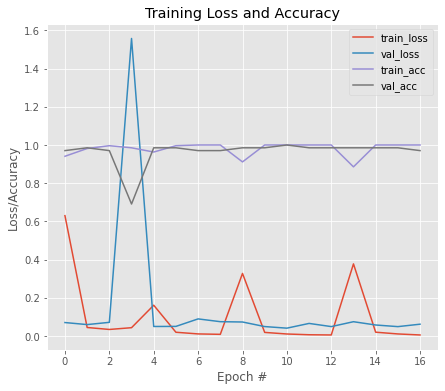


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:11
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.9262
Epoch 1: val_accuracy improved from -inf to 0.97059, saving model to vgg19_b_2.hdf5
9/9 [==============================] - 4s 332ms/step - loss: 0.4436 - accuracy: 0.9262 - val_loss: 0.1102 - val_accuracy: 0.9706
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.97059 to 0.98529, saving model to vgg19_b_2.hdf5
9/9 [==============================] - 3s 321ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 0.0808 - val_accuracy: 0.9853
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.98529
9/9 [==============================] - 2s 273ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.0684 - val_accuracy: 0.9853
Epoch 4/50
9/9 [=============================

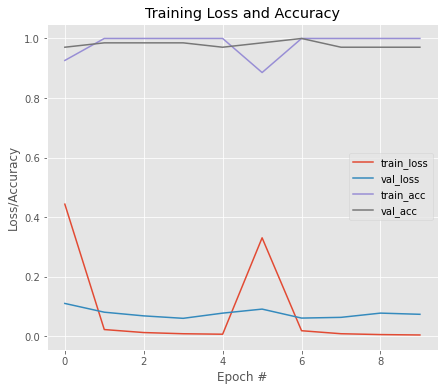


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:7
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3039 - accuracy: 0.9114
Epoch 1: val_accuracy improved from -inf to 0.98529, saving model to vgg19_a_3.hdf5
9/9 [==============================] - 4s 330ms/step - loss: 0.3039 - accuracy: 0.9114 - val_loss: 0.0315 - val_accuracy: 0.9853
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9963
Epoch 2: val_accuracy improved from 0.98529 to 1.00000, saving model to vgg19_a_3.hdf5
9/9 [==============================] - 3s 318ms/step - loss: 0.0230 - accuracy: 0.9963 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 288ms/step - loss: 0.0267 - accuracy: 0.9963 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============

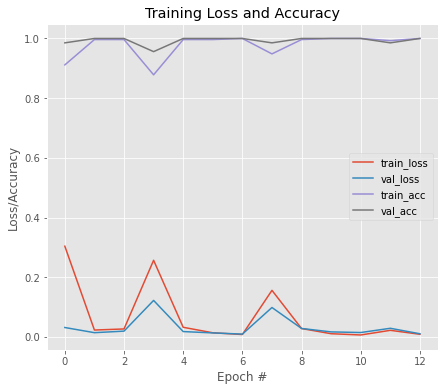


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.9041
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to vgg19_b_3.hdf5
9/9 [==============================] - 4s 349ms/step - loss: 0.5946 - accuracy: 0.9041 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9963
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 292ms/step - loss: 0.0170 - accuracy: 0.9963 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 272ms/step - loss: 0.0124 - accuracy: 0.9963 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0115 - accurac

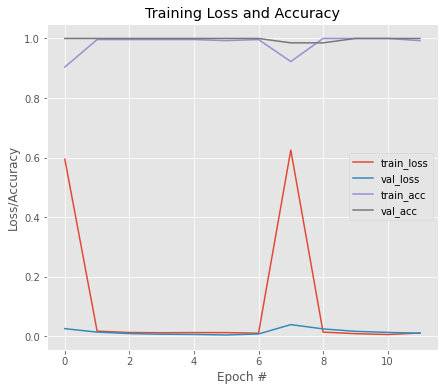


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.8484 - accuracy: 0.8860
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to vgg19_a_4.hdf5
9/9 [==============================] - 4s 332ms/step - loss: 0.8484 - accuracy: 0.8860 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 273ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 274ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 

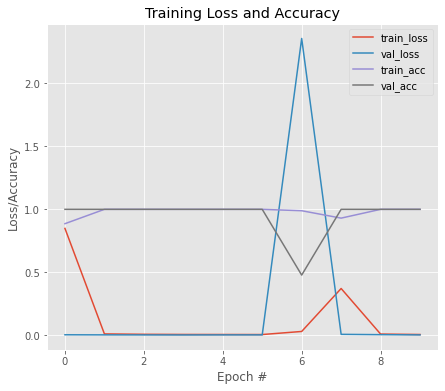


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 0.9522
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to vgg19_b_4.hdf5
9/9 [==============================] - 4s 329ms/step - loss: 0.1930 - accuracy: 0.9522 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 275ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 290ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0062 - accurac

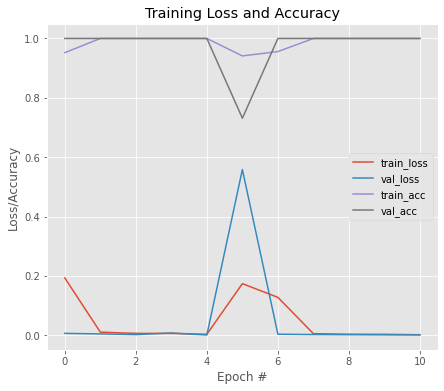


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Average Accuracy:0.9735294103622436
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.88356, saving model to vgg19_wt.hdf5
11/11 [==============================] - 2s 171ms/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 0.2774 - val_accuracy: 0.8836
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.88356
11/11 [==============================] - 2s 138ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.2768 - val_accuracy: 0.8836
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.88356
11/11 [==============================] - 1s 137ms/step - loss: 0.0197 - accuracy: 1.0000 -

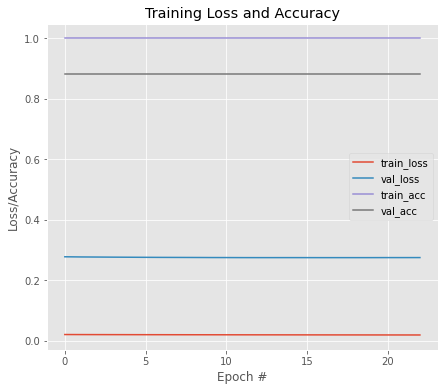


Model Performance Summary:

Best Validation accuracy:0.8835616707801819 at EPOCH:1
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.2236 - accuracy: 0.6637
Epoch 1: val_accuracy improved from -inf to 0.76027, saving model to vgg19_wt.hdf5
11/11 [==============================] - 5s 356ms/step - loss: 1.2236 - accuracy: 0.6637 - val_loss: 0.4633 - val_accuracy: 0.7603
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.4126 - accuracy: 0.8230
Epoch 2: val_accuracy improved from 0.76027 to 0.85616, saving model to vgg19_wt.hdf5
11/11 [==============================] - 4s 344ms/step - loss: 0.4126 - accuracy: 0.8230 - val_loss: 0.3054 - val_accuracy: 0.8562
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.3898 - accuracy: 0.8083
Epoch 3: val_accuracy did not improve from 0.85616
11/11 [==============================] - 3s 300ms/step - loss: 0.3898 - accuracy: 0.8083 - val_loss: 0.40

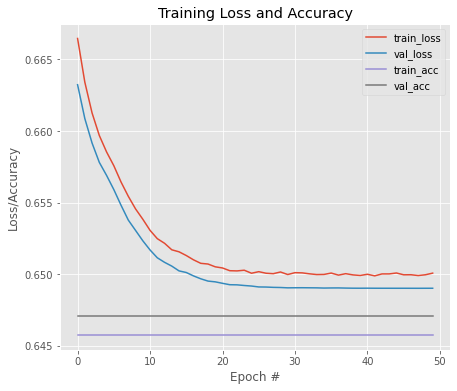


Model Performance Summary:

Best Validation accuracy:0.6470588445663452 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.6642
Epoch 1: val_accuracy improved from -inf to 0.64706, saving model to resnet50_b_0.hdf5
9/9 [==============================] - 15s 439ms/step - loss: 0.6169 - accuracy: 0.6642 - val_loss: 0.6507 - val_accuracy: 0.6471
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.9114
Epoch 2: val_accuracy did not improve from 0.64706
9/9 [==============================] - 2s 198ms/step - loss: 0.2957 - accuracy: 0.9114 - val_loss: 0.6520 - val_accuracy: 0.6471
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9852
Epoch 3: val_accuracy did not improve from 0.64706
9/9 [==============================] - 2s 197ms/step - loss: 0.1979 - accuracy: 0.9852 - val_loss: 0.6555 - val_accuracy: 0.6471
Epoch 4/50
9/9 [==============================] - ETA: 0s - los

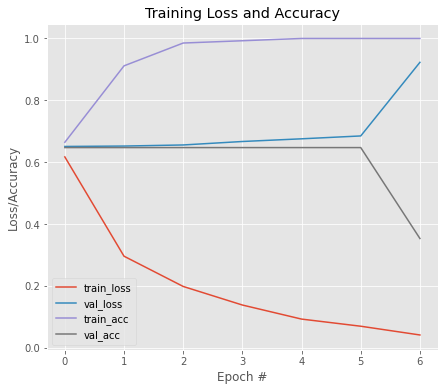


Model Performance Summary:

Best Validation accuracy:0.6470588445663452 at EPOCH:1
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9668
Epoch 1: val_accuracy improved from -inf to 0.29412, saving model to resnet50_a_1.hdf5
9/9 [==============================] - 13s 382ms/step - loss: 0.0905 - accuracy: 0.9668 - val_loss: 1.3292 - val_accuracy: 0.2941
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9926
Epoch 2: val_accuracy did not improve from 0.29412
9/9 [==============================] - 2s 198ms/step - loss: 0.0406 - accuracy: 0.9926 - val_loss: 1.9720 - val_accuracy: 0.2941
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.29412
9/9 [==============================] - 2s 197ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 2.3014 - val_accuracy: 0.2941
Epoch 4/50
9/9 [==============================]

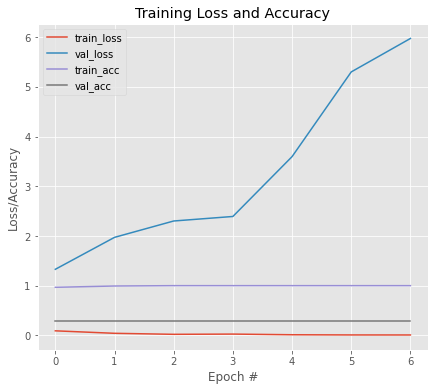


Model Performance Summary:

Best Validation accuracy:0.29411765933036804 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9963
Epoch 1: val_accuracy improved from -inf to 0.29412, saving model to resnet50_b_1.hdf5
9/9 [==============================] - 13s 386ms/step - loss: 0.0335 - accuracy: 0.9963 - val_loss: 1.9127 - val_accuracy: 0.2941
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.29412
9/9 [==============================] - 2s 198ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 2.7047 - val_accuracy: 0.2941
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.29412
9/9 [==============================] - 2s 199ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 2.9806 - val_accuracy: 0.2941
Epoch 4/50
9/9 [==============================] - ETA: 0s - lo

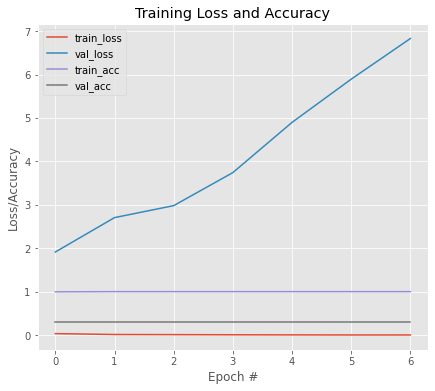


Model Performance Summary:

Best Validation accuracy:0.29411765933036804 at EPOCH:1
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9963
Epoch 1: val_accuracy improved from -inf to 0.38235, saving model to resnet50_a_2.hdf5
9/9 [==============================] - 13s 389ms/step - loss: 0.0149 - accuracy: 0.9963 - val_loss: 5.8619 - val_accuracy: 0.3824
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.38235
9/9 [==============================] - 2s 196ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 6.4693 - val_accuracy: 0.3824
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.38235
9/9 [==============================] - 2s 199ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 7.0542 - val_accuracy: 0.3824
Epoch 4/50
9/9 [==============================

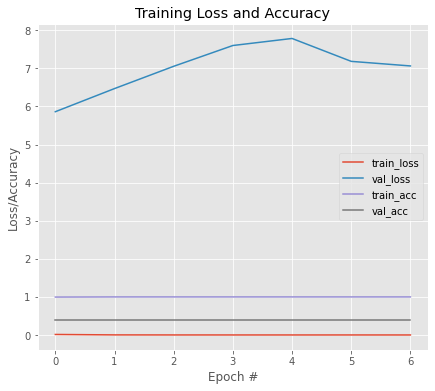


Model Performance Summary:

Best Validation accuracy:0.38235294818878174 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.38235, saving model to resnet50_b_2.hdf5
9/9 [==============================] - 13s 380ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 7.8887 - val_accuracy: 0.3824
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 8.6072e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.38235
9/9 [==============================] - 2s 197ms/step - loss: 8.6072e-04 - accuracy: 1.0000 - val_loss: 7.9177 - val_accuracy: 0.3824
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.38235
9/9 [==============================] - 2s 199ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 7.7529 - val_accuracy: 0.3824
Epoch 4/50
9/9 [==============================] - ETA:

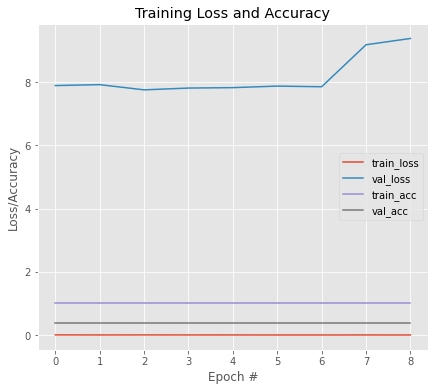


Model Performance Summary:

Best Validation accuracy:0.38235294818878174 at EPOCH:1
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 5.8052e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.36765, saving model to resnet50_a_3.hdf5
9/9 [==============================] - 12s 376ms/step - loss: 5.8052e-04 - accuracy: 1.0000 - val_loss: 8.7786 - val_accuracy: 0.3676
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.36765
9/9 [==============================] - 2s 196ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 9.5666 - val_accuracy: 0.3676
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 8.2590e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.36765
9/9 [==============================] - 2s 198ms/step - loss: 8.2590e-04 - accuracy: 1.0000 - val_loss: 9.2238 - val_accuracy: 0.3676
Epoch 4/50
9/9 [==============

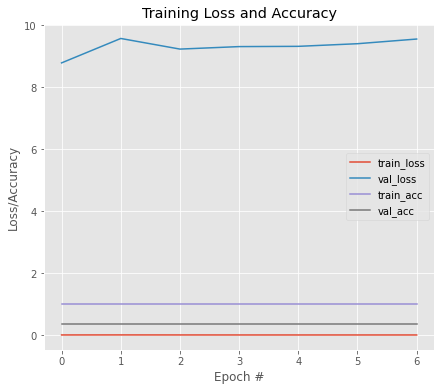


Model Performance Summary:

Best Validation accuracy:0.36764705181121826 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 1.7756e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.36765, saving model to resnet50_b_3.hdf5
9/9 [==============================] - 14s 452ms/step - loss: 1.7756e-04 - accuracy: 1.0000 - val_loss: 9.6233 - val_accuracy: 0.3676
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 6.8967e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.36765
9/9 [==============================] - 2s 199ms/step - loss: 6.8967e-05 - accuracy: 1.0000 - val_loss: 9.5746 - val_accuracy: 0.3676
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 4.3573e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.36765
9/9 [==============================] - 2s 198ms/step - loss: 4.3573e-05 - accuracy: 1.0000 - val_loss: 9.7437 - val_accuracy: 0.3676
Epoch 4/50
9/9 [======================

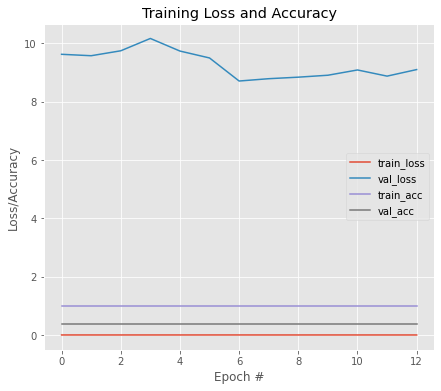


Model Performance Summary:

Best Validation accuracy:0.36764705181121826 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 1.6617e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.37313, saving model to resnet50_a_4.hdf5
9/9 [==============================] - 13s 437ms/step - loss: 1.6617e-05 - accuracy: 1.0000 - val_loss: 9.6173 - val_accuracy: 0.3731
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 2.3512e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.37313
9/9 [==============================] - 2s 197ms/step - loss: 2.3512e-05 - accuracy: 1.0000 - val_loss: 9.2660 - val_accuracy: 0.3731
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 3.8504e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.37313
9/9 [==============================] - 2s 208ms/step - loss: 3.8504e-05 - accuracy: 1.0000 - val_loss: 8.8042 - val_accuracy: 0.3731
Epoch 4/50
9/9 [======

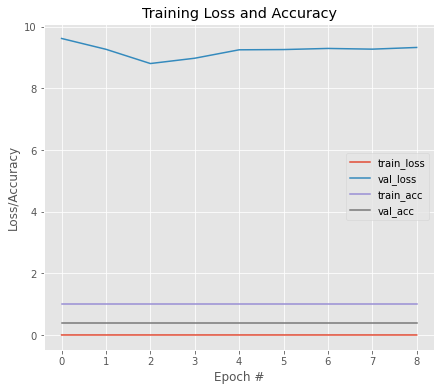


Model Performance Summary:

Best Validation accuracy:0.3731343150138855 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 3.1627e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.37313, saving model to resnet50_b_4.hdf5
9/9 [==============================] - 13s 388ms/step - loss: 3.1627e-05 - accuracy: 1.0000 - val_loss: 9.4036 - val_accuracy: 0.3731
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 6.7920e-06 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.37313
9/9 [==============================] - 2s 197ms/step - loss: 6.7920e-06 - accuracy: 1.0000 - val_loss: 9.6228 - val_accuracy: 0.3731
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 2.8204e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.37313
9/9 [==============================] - 2s 197ms/step - loss: 2.8204e-04 - accuracy: 1.0000 - val_loss: 9.9495 - val_accuracy: 0.3731
Epoch 4/50
9/9 [=======================

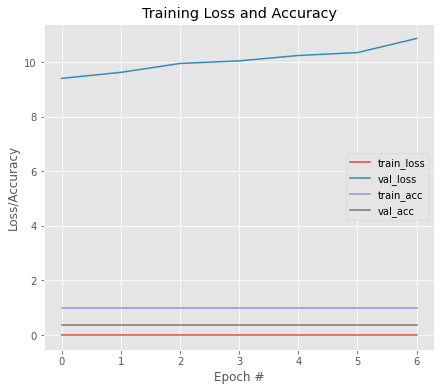


Model Performance Summary:

Best Validation accuracy:0.3731343150138855 at EPOCH:1
Average Accuracy:0.41286216378211976
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.6510 - accuracy: 0.6460
Epoch 1: val_accuracy improved from -inf to 0.64384, saving model to resnet50_wt.hdf5
11/11 [==============================] - 5s 229ms/step - loss: 0.6510 - accuracy: 0.6460 - val_loss: 0.6516 - val_accuracy: 0.6438
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.6506 - accuracy: 0.6460
Epoch 2: val_accuracy did not improve from 0.64384
11/11 [==============================] - 1s 94ms/step - loss: 0.6506 - accuracy: 0.6460 - val_loss: 0.6514 - val_accuracy: 0.6438
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.6504 - accuracy: 0.6460
Epoch 3: val_accuracy did not improve from 0.64384
11/11 [==============================] - 1s 94ms/step - loss: 0.6504 - a

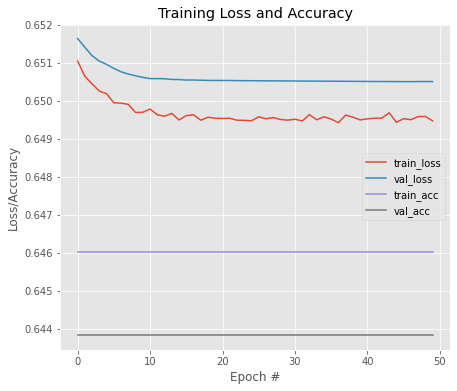


Model Performance Summary:

Best Validation accuracy:0.6438356041908264 at EPOCH:1
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.9204
Epoch 1: val_accuracy improved from -inf to 0.64384, saving model to resnet50_wt.hdf5
11/11 [==============================] - 14s 400ms/step - loss: 0.2841 - accuracy: 0.9204 - val_loss: 0.6821 - val_accuracy: 0.6438
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9971
Epoch 2: val_accuracy did not improve from 0.64384
11/11 [==============================] - 2s 212ms/step - loss: 0.0816 - accuracy: 0.9971 - val_loss: 0.6798 - val_accuracy: 0.6438
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.64384
11/11 [==============================] - 2s 219ms/step - loss: 0.0333 - accuracy: 1.0000 - val_loss: 0.8146 - val_accuracy: 0.3562
Epoch

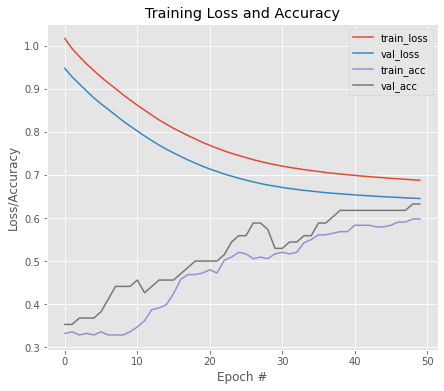


Model Performance Summary:

Best Validation accuracy:0.6323529481887817 at EPOCH:49
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.9713 - accuracy: 0.6494
Epoch 1: val_accuracy improved from -inf to 0.64706, saving model to DenseNet121_b_0.hdf5
9/9 [==============================] - 25s 582ms/step - loss: 0.9713 - accuracy: 0.6494 - val_loss: 0.6207 - val_accuracy: 0.6471
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.6900
Epoch 2: val_accuracy did not improve from 0.64706
9/9 [==============================] - 2s 216ms/step - loss: 0.6269 - accuracy: 0.6900 - val_loss: 0.6125 - val_accuracy: 0.6471
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.4587 - accuracy: 0.7343
Epoch 3: val_accuracy improved from 0.64706 to 0.66176, saving model to DenseNet121_b_0.hdf5
9/9 [==============================] - 3s 311ms/step - loss: 0.4587 - accuracy: 0.7343 - val_loss: 0.6185 - val_accuracy: 0.6618
Epoch 4/50
9/9 [=

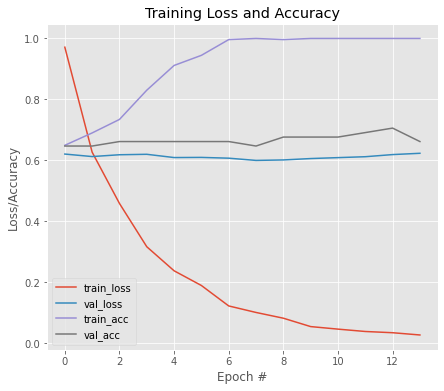


Model Performance Summary:

Best Validation accuracy:0.7058823704719543 at EPOCH:13
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9594
Epoch 1: val_accuracy improved from -inf to 0.76471, saving model to DenseNet121_a_1.hdf5
9/9 [==============================] - 23s 523ms/step - loss: 0.1294 - accuracy: 0.9594 - val_loss: 0.5340 - val_accuracy: 0.7647
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.9889
Epoch 2: val_accuracy did not improve from 0.76471
9/9 [==============================] - 2s 217ms/step - loss: 0.0628 - accuracy: 0.9889 - val_loss: 0.5355 - val_accuracy: 0.7647
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 0.76471
9/9 [==============================] - 2s 217ms/step - loss: 0.0342 - accuracy: 0.9963 - val_loss: 0.5500 - val_accuracy: 0.7647
Epoch 4/50
9/9 [===========================

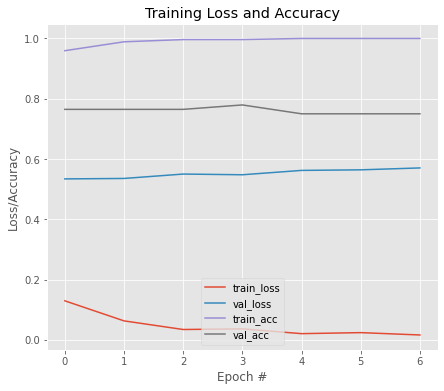


Model Performance Summary:

Best Validation accuracy:0.779411792755127 at EPOCH:4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.76471, saving model to DenseNet121_b_1.hdf5
9/9 [==============================] - 23s 519ms/step - loss: 0.0232 - accuracy: 1.0000 - val_loss: 0.5509 - val_accuracy: 0.7647
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.76471
9/9 [==============================] - 2s 215ms/step - loss: 0.0155 - accuracy: 1.0000 - val_loss: 0.5576 - val_accuracy: 0.7647
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.76471
9/9 [==============================] - 2s 213ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.5704 - val_accuracy: 0.7353
Epoch 4/50
9/9 [==============================] - ETA: 0s - l

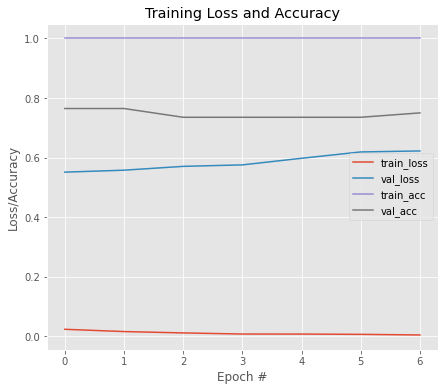


Model Performance Summary:

Best Validation accuracy:0.7647058963775635 at EPOCH:1
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.70588, saving model to DenseNet121_a_2.hdf5
9/9 [==============================] - 23s 525ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.6730 - val_accuracy: 0.7059
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.70588
9/9 [==============================] - 2s 215ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.6889 - val_accuracy: 0.6765
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.70588
9/9 [==============================] - 2s 213ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.7189 - val_accuracy: 0.7059
Epoch 4/50
9/9 [============================

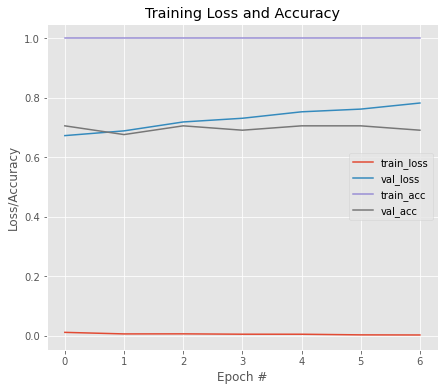


Model Performance Summary:

Best Validation accuracy:0.7058823704719543 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.67647, saving model to DenseNet121_b_2.hdf5
9/9 [==============================] - 23s 526ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.7416 - val_accuracy: 0.6765
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.67647
9/9 [==============================] - 2s 217ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.7592 - val_accuracy: 0.6765
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.67647
9/9 [==============================] - 2s 215ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.7688 - val_accuracy: 0.6618
Epoch 4/50
9/9 [==============================] - ETA: 0s - 

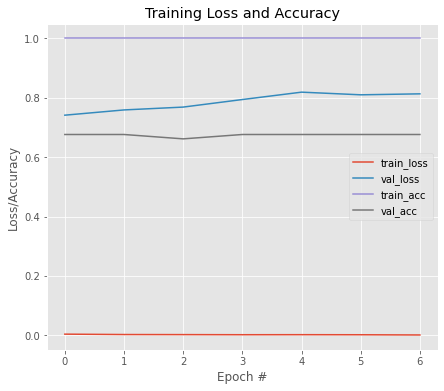


Model Performance Summary:

Best Validation accuracy:0.6764705777168274 at EPOCH:1
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000    
Epoch 1: val_accuracy improved from -inf to 0.72059, saving model to DenseNet121_a_3.hdf5
9/9 [==============================] - 23s 519ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7301 - val_accuracy: 0.7206
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.72059
9/9 [==============================] - 2s 216ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.7066 - val_accuracy: 0.7206
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.72059
9/9 [==============================] - 2s 215ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.7334 - val_accuracy: 0.7206
Epoch 4/50
9/9 [========================

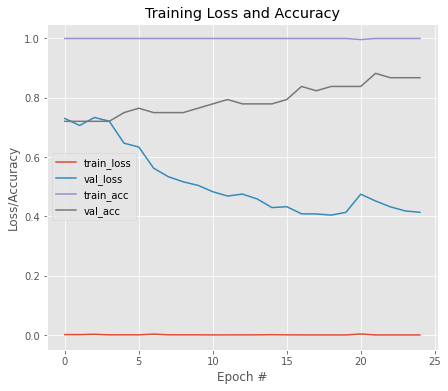


Model Performance Summary:

Best Validation accuracy:0.8823529481887817 at EPOCH:22
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 1.5779e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.85294, saving model to DenseNet121_b_3.hdf5
9/9 [==============================] - 23s 514ms/step - loss: 1.5779e-04 - accuracy: 1.0000 - val_loss: 0.4973 - val_accuracy: 0.8529
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 2.3361e-04 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.85294 to 0.86765, saving model to DenseNet121_b_3.hdf5
9/9 [==============================] - 3s 312ms/step - loss: 2.3361e-04 - accuracy: 1.0000 - val_loss: 0.5282 - val_accuracy: 0.8676
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.0141e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.86765
9/9 [==============================] - 2s 216ms/step - loss: 1.0141e-04 - accuracy: 1.0000 - val_loss: 0.5017 - val_accuracy: 

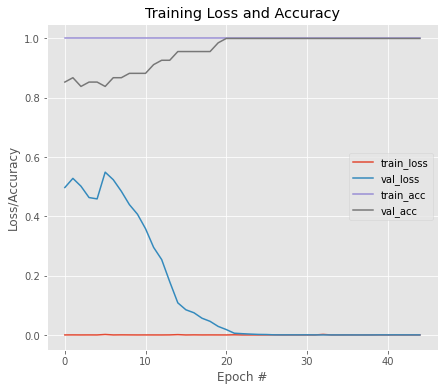


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:21
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to DenseNet121_a_4.hdf5
9/9 [==============================] - 24s 655ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 7.1062e-06 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 217ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.5388e-06 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.1009e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 218ms/step - loss: 1.1009e-04 - accuracy: 1.0000 - val_loss: 4.2773e-06 - val_accuracy: 1.0000
Epoch 4/50
9/9 [======================

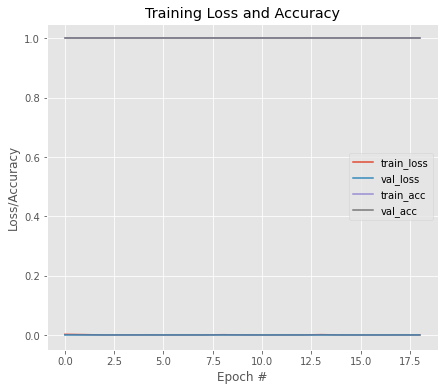


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 2.5943e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to DenseNet121_b_4.hdf5
9/9 [==============================] - 23s 525ms/step - loss: 2.5943e-04 - accuracy: 1.0000 - val_loss: 3.8425e-05 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 3.5513e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 220ms/step - loss: 3.5513e-05 - accuracy: 1.0000 - val_loss: 2.7788e-05 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.6988e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 218ms/step - loss: 1.6988e-04 - accuracy: 1.0000 - val_loss: 5.0754e-05 - val_accuracy: 1.0000
Epoch 4/50
9/9 [=======================

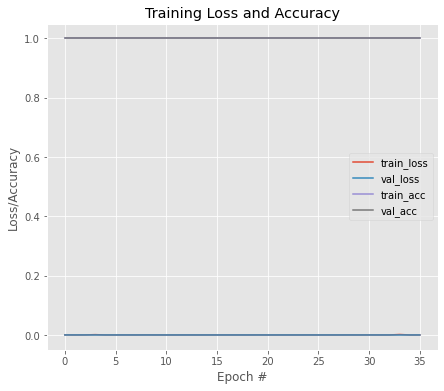


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Average Accuracy:0.8294117689132691
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.84932, saving model to DenseNet121_wt.hdf5
11/11 [==============================] - 9s 335ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.4556 - val_accuracy: 0.8493
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.84932
11/11 [==============================] - 1s 92ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.4513 - val_accuracy: 0.8493
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.84932 to 0.85616, saving model to DenseNet121_wt.hdf5
11/11 [==============================] - 2s 

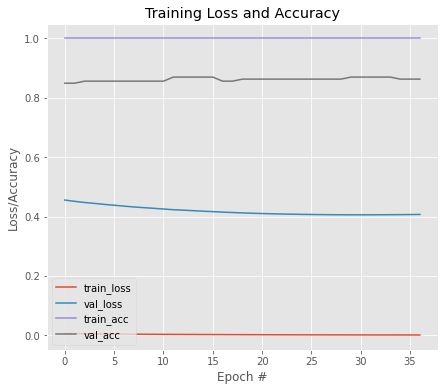


Model Performance Summary:

Best Validation accuracy:0.8698630332946777 at EPOCH:12
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 6.5647e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.82877, saving model to DenseNet121_wt.hdf5
11/11 [==============================] - 24s 525ms/step - loss: 6.5647e-04 - accuracy: 1.0000 - val_loss: 0.5239 - val_accuracy: 0.8288
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 4.3346e-04 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.82877 to 0.86301, saving model to DenseNet121_wt.hdf5
11/11 [==============================] - 3s 306ms/step - loss: 4.3346e-04 - accuracy: 1.0000 - val_loss: 0.4062 - val_accuracy: 0.8630
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 4.9377e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.86301
11/11 [==============================] - 3s 229ms/step - loss: 4.9377e-

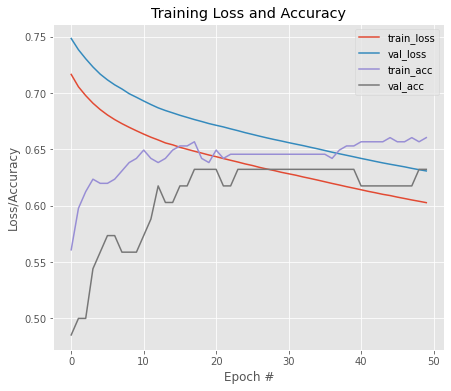


Model Performance Summary:

Best Validation accuracy:0.6323529481887817 at EPOCH:18
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.6310
Epoch 1: val_accuracy improved from -inf to 0.47059, saving model to MobileNet_b_0.hdf5
9/9 [==============================] - 6s 243ms/step - loss: 0.6876 - accuracy: 0.6310 - val_loss: 0.8502 - val_accuracy: 0.4706
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.5021 - accuracy: 0.7601
Epoch 2: val_accuracy did not improve from 0.47059
9/9 [==============================] - 1s 154ms/step - loss: 0.5021 - accuracy: 0.7601 - val_loss: 1.0095 - val_accuracy: 0.4706
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.4228 - accuracy: 0.8229
Epoch 3: val_accuracy did not improve from 0.47059
9/9 [==============================] - 1s 152ms/step - loss: 0.4228 - accuracy: 0.8229 - val_loss: 1.2311 - val_accuracy: 0.3676
Epoch 4/50
9/9 [==============================] - ETA: 0s - lo

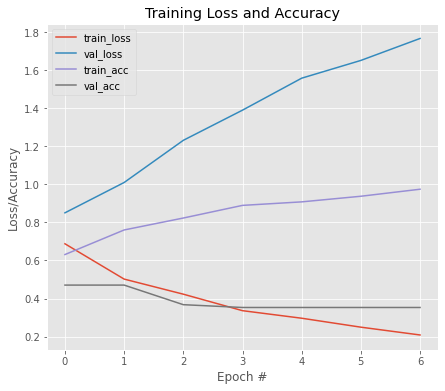


Model Performance Summary:

Best Validation accuracy:0.47058823704719543 at EPOCH:1
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9520
Epoch 1: val_accuracy improved from -inf to 0.30882, saving model to MobileNet_a_1.hdf5
9/9 [==============================] - 6s 235ms/step - loss: 0.2437 - accuracy: 0.9520 - val_loss: 1.8412 - val_accuracy: 0.3088
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.9779
Epoch 2: val_accuracy did not improve from 0.30882
9/9 [==============================] - 1s 157ms/step - loss: 0.1812 - accuracy: 0.9779 - val_loss: 1.7647 - val_accuracy: 0.3088
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1465 - accuracy: 0.9815
Epoch 3: val_accuracy improved from 0.30882 to 0.32353, saving model to MobileNet_a_1.hdf5
9/9 [==============================] - 2s 191ms/step - loss: 0.1465 - accuracy: 0.9815 - val_loss: 1.6866 - val_accuracy: 0.3235
Epoch 

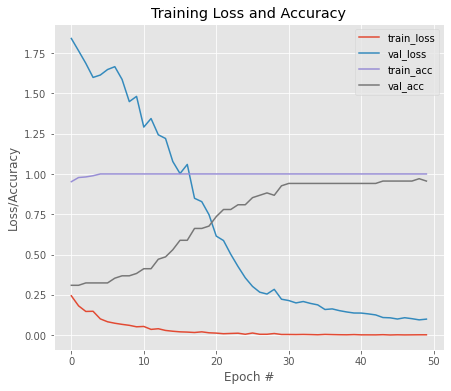


Model Performance Summary:

Best Validation accuracy:0.970588207244873 at EPOCH:49
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 7.8269e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.97059, saving model to MobileNet_b_1.hdf5
9/9 [==============================] - 6s 266ms/step - loss: 7.8269e-04 - accuracy: 1.0000 - val_loss: 0.1114 - val_accuracy: 0.9706
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 8.0155e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.97059
9/9 [==============================] - 1s 152ms/step - loss: 8.0155e-04 - accuracy: 1.0000 - val_loss: 0.1365 - val_accuracy: 0.9412
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 9.3173e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.97059
9/9 [==============================] - 1s 164ms/step - loss: 9.3173e-04 - accuracy: 1.0000 - val_loss: 0.1163 - val_accuracy: 0.9706
Epoch 4/50
9/9 [=======================

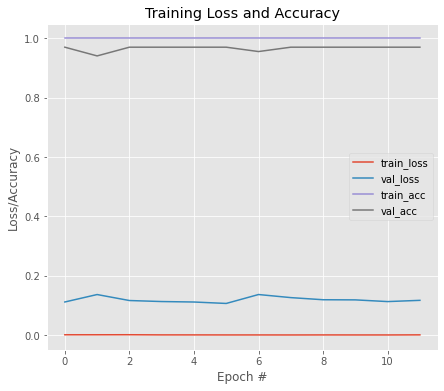


Model Performance Summary:

Best Validation accuracy:0.970588207244873 at EPOCH:1
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9926
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to MobileNet_a_2.hdf5
9/9 [==============================] - 6s 236ms/step - loss: 0.0172 - accuracy: 0.9926 - val_loss: 7.4111e-05 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 1s 154ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 6.6423e-05 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9926
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 1s 153ms/step - loss: 0.0164 - accuracy: 0.9926 - val_loss: 8.0533e-05 - val_accuracy: 1.0000
Epoch 4/50
9/9 [====================

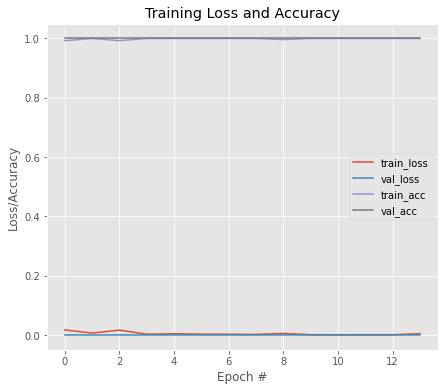


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9889
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to MobileNet_b_2.hdf5
9/9 [==============================] - 6s 237ms/step - loss: 0.0276 - accuracy: 0.9889 - val_loss: 8.8086e-05 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 1s 156ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 7.7873e-05 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 1s 160ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 7.2054e-05 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 

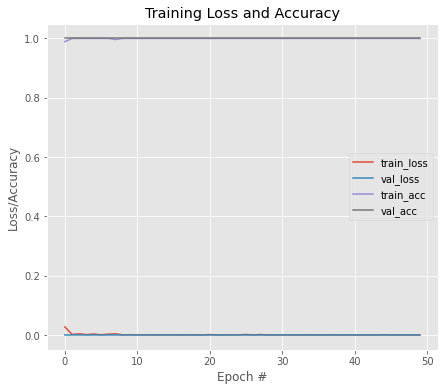


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 9.6870e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to MobileNet_a_3.hdf5
9/9 [==============================] - 6s 233ms/step - loss: 9.6870e-05 - accuracy: 1.0000 - val_loss: 7.2384e-06 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 1.0100e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 1s 164ms/step - loss: 1.0100e-04 - accuracy: 1.0000 - val_loss: 8.4918e-06 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 4.8614e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 1s 154ms/step - loss: 4.8614e-05 - accuracy: 1.0000 - val_loss: 8.3761e-06 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==========

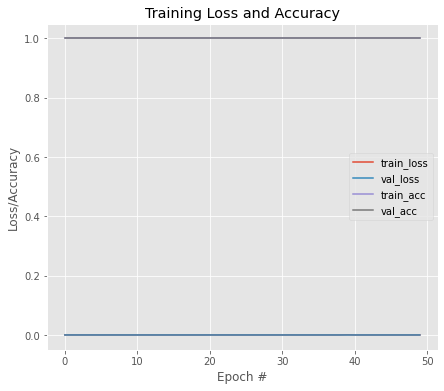


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 2.5959e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to MobileNet_b_3.hdf5
9/9 [==============================] - 6s 236ms/step - loss: 2.5959e-04 - accuracy: 1.0000 - val_loss: 6.1392e-06 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 3.0511e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 1s 154ms/step - loss: 3.0511e-04 - accuracy: 1.0000 - val_loss: 6.5600e-06 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.9602e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 1s 164ms/step - loss: 1.9602e-05 - accuracy: 1.0000 - val_loss: 5.9096e-06 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==========================

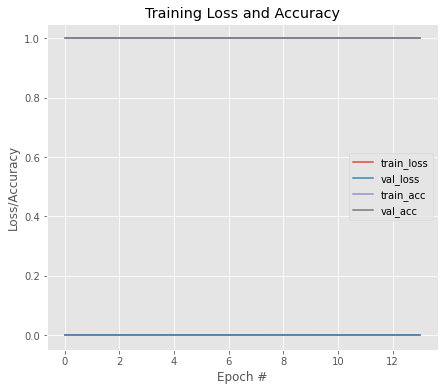


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 5.1139e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to MobileNet_a_4.hdf5
9/9 [==============================] - 6s 261ms/step - loss: 5.1139e-05 - accuracy: 1.0000 - val_loss: 5.6864e-06 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 1.3991e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 1s 154ms/step - loss: 1.3991e-05 - accuracy: 1.0000 - val_loss: 4.5904e-06 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 5.5777e-06 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 1s 153ms/step - loss: 5.5777e-06 - accuracy: 1.0000 - val_loss: 4.0976e-06 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==========

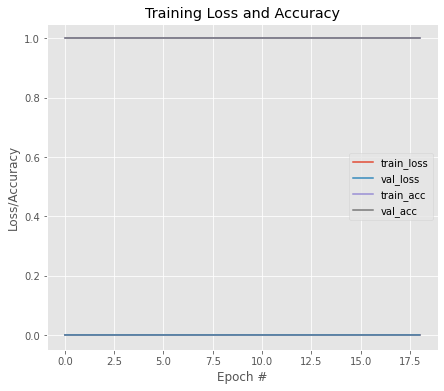


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 1.3231e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to MobileNet_b_4.hdf5
9/9 [==============================] - 6s 237ms/step - loss: 1.3231e-05 - accuracy: 1.0000 - val_loss: 6.3056e-06 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 8.2759e-06 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 1s 154ms/step - loss: 8.2759e-06 - accuracy: 1.0000 - val_loss: 6.3358e-06 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 3.4368e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 1s 151ms/step - loss: 3.4368e-05 - accuracy: 1.0000 - val_loss: 4.4783e-06 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==========================

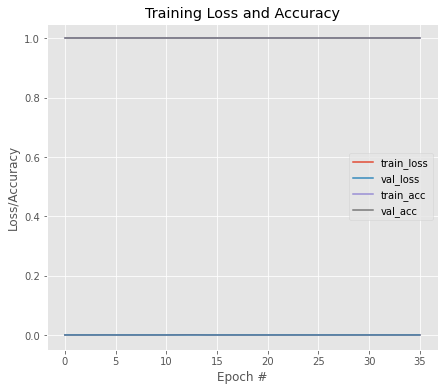


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Average Accuracy:0.8882352888584137
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.83562, saving model to MobileNet_wt.hdf5
11/11 [==============================] - 2s 112ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4901 - val_accuracy: 0.8356
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.83562 to 0.84247, saving model to MobileNet_wt.hdf5
11/11 [==============================] - 1s 59ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.4836 - val_accuracy: 0.8425
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.84247
11/11 [==============================] - 0s 46ms

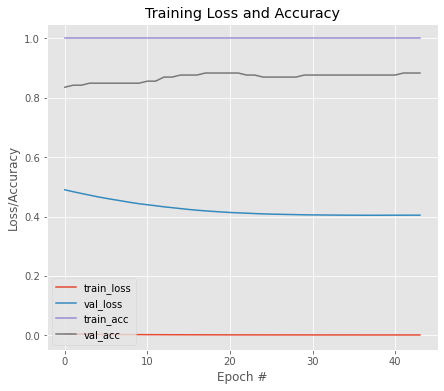


Model Performance Summary:

Best Validation accuracy:0.8835616707801819 at EPOCH:18
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9941
Epoch 1: val_accuracy improved from -inf to 0.89041, saving model to MobileNet_wt.hdf5
11/11 [==============================] - 6s 238ms/step - loss: 0.0108 - accuracy: 0.9941 - val_loss: 0.4166 - val_accuracy: 0.8904
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9971
Epoch 2: val_accuracy did not improve from 0.89041
11/11 [==============================] - 2s 158ms/step - loss: 0.0047 - accuracy: 0.9971 - val_loss: 0.4222 - val_accuracy: 0.8904
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9971
Epoch 3: val_accuracy did not improve from 0.89041
11/11 [==============================] - 2s 159ms/step - loss: 0.0052 - accuracy: 0.9971 - val_loss: 0.4049 - val_accuracy: 0.8904
Epoc

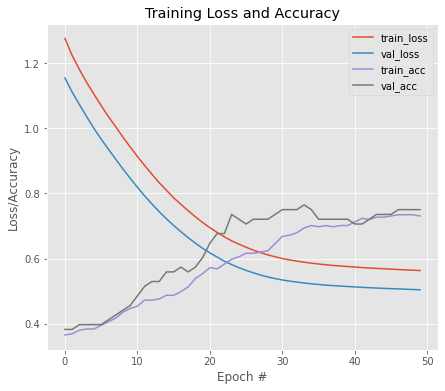


Model Performance Summary:

Best Validation accuracy:0.7647058963775635 at EPOCH:34
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.6162
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to MobileNetV2_b_0.hdf5
9/9 [==============================] - 12s 317ms/step - loss: 0.6912 - accuracy: 0.6162 - val_loss: 0.5297 - val_accuracy: 0.7500
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.5292 - accuracy: 0.7343
Epoch 2: val_accuracy did not improve from 0.75000
9/9 [==============================] - 2s 168ms/step - loss: 0.5292 - accuracy: 0.7343 - val_loss: 0.5380 - val_accuracy: 0.7059
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.7823
Epoch 3: val_accuracy did not improve from 0.75000
9/9 [==============================] - 2s 172ms/step - loss: 0.4722 - accuracy: 0.7823 - val_loss: 0.5524 - val_accuracy: 0.6765
Epoch 4/50
9/9 [==============================] - ETA: 0s -

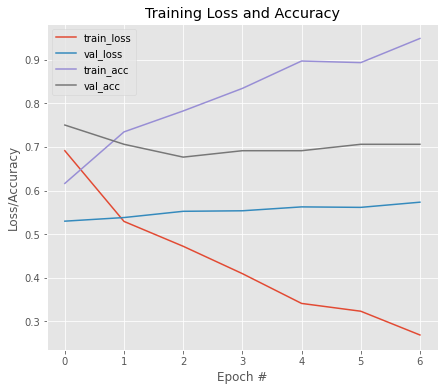


Model Performance Summary:

Best Validation accuracy:0.75 at EPOCH:1
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.2880 - accuracy: 0.9336
Epoch 1: val_accuracy improved from -inf to 0.60294, saving model to MobileNetV2_a_1.hdf5
9/9 [==============================] - 10s 303ms/step - loss: 0.2880 - accuracy: 0.9336 - val_loss: 0.7257 - val_accuracy: 0.6029
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.9520
Epoch 2: val_accuracy did not improve from 0.60294
9/9 [==============================] - 2s 169ms/step - loss: 0.2273 - accuracy: 0.9520 - val_loss: 0.7384 - val_accuracy: 0.5882
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9742
Epoch 3: val_accuracy did not improve from 0.60294
9/9 [==============================] - 2s 167ms/step - loss: 0.1941 - accuracy: 0.9742 - val_loss: 0.7188 - val_accuracy: 0.5882
Epoch 4/50
9/9 [==============================] - ETA: 0s 

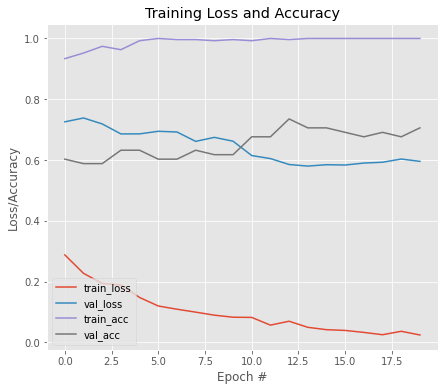


Model Performance Summary:

Best Validation accuracy:0.7352941036224365 at EPOCH:13
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9963
Epoch 1: val_accuracy improved from -inf to 0.69118, saving model to MobileNetV2_b_1.hdf5
9/9 [==============================] - 11s 308ms/step - loss: 0.0502 - accuracy: 0.9963 - val_loss: 0.5953 - val_accuracy: 0.6912
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9963
Epoch 2: val_accuracy did not improve from 0.69118
9/9 [==============================] - 2s 171ms/step - loss: 0.0415 - accuracy: 0.9963 - val_loss: 0.5963 - val_accuracy: 0.6912
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.69118
9/9 [==============================] - 2s 169ms/step - loss: 0.0291 - accuracy: 1.0000 - val_loss: 0.6209 - val_accuracy: 0.6324
Epoch 4/50
9/9 [==============================] - ETA: 0s -

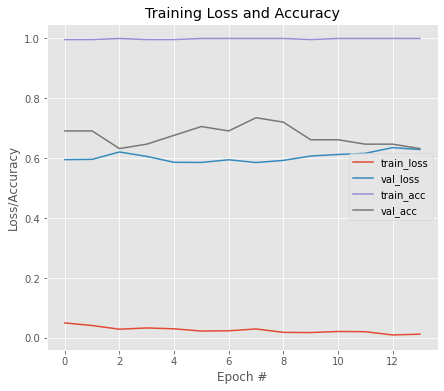


Model Performance Summary:

Best Validation accuracy:0.7352941036224365 at EPOCH:8
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9815
Epoch 1: val_accuracy improved from -inf to 0.69118, saving model to MobileNetV2_a_2.hdf5
9/9 [==============================] - 10s 305ms/step - loss: 0.0531 - accuracy: 0.9815 - val_loss: 0.6791 - val_accuracy: 0.6912
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9926
Epoch 2: val_accuracy did not improve from 0.69118
9/9 [==============================] - 2s 166ms/step - loss: 0.0365 - accuracy: 0.9926 - val_loss: 0.6950 - val_accuracy: 0.6912
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.69118
9/9 [==============================] - 2s 167ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.7032 - val_accuracy: 0.6765
Epoch 4/50
9/9 [============================

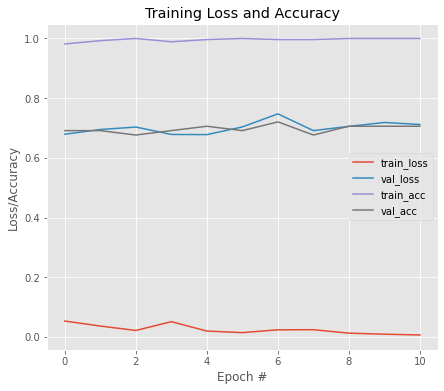


Model Performance Summary:

Best Validation accuracy:0.720588207244873 at EPOCH:7
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.67647, saving model to MobileNetV2_b_2.hdf5
9/9 [==============================] - 10s 303ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.7916 - val_accuracy: 0.6765
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.67647
9/9 [==============================] - 2s 169ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.8486 - val_accuracy: 0.6471
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.67647
9/9 [==============================] - 2s 170ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.9705 - val_accuracy: 0.5294
Epoch 4/50
9/9 [==============================] - ETA: 0s - l

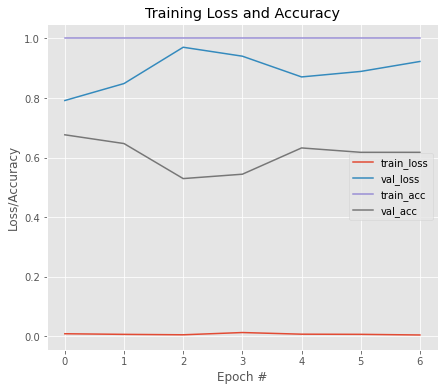


Model Performance Summary:

Best Validation accuracy:0.6764705777168274 at EPOCH:1
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.61765, saving model to MobileNetV2_a_3.hdf5
9/9 [==============================] - 10s 308ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.8694 - val_accuracy: 0.6176
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.61765 to 0.64706, saving model to MobileNetV2_a_3.hdf5
9/9 [==============================] - 2s 214ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.8510 - val_accuracy: 0.6471
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.64706 to 0.66176, saving model to MobileNetV2_a_3.hdf5
9/9 [==============================] - 2s 211ms/step - loss: 0.0044 - accuracy: 1.0000 - 

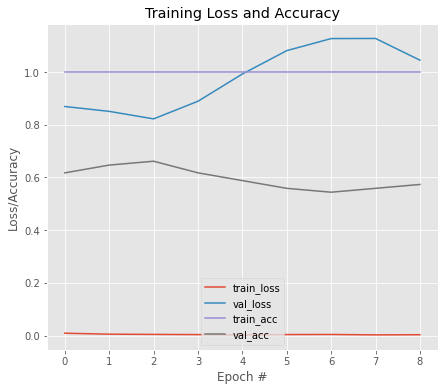


Model Performance Summary:

Best Validation accuracy:0.6617646813392639 at EPOCH:3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.69118, saving model to MobileNetV2_b_3.hdf5
9/9 [==============================] - 10s 305ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.8126 - val_accuracy: 0.6912
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.69118
9/9 [==============================] - 2s 172ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.9742 - val_accuracy: 0.6029
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.69118
9/9 [==============================] - 2s 171ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.8452 - val_accuracy: 0.6765
Epoch 4/50
9/9 [==============================] - ETA: 0s - 

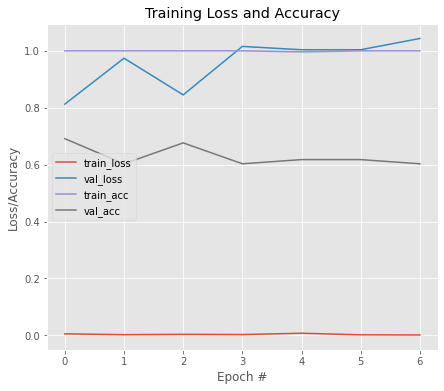


Model Performance Summary:

Best Validation accuracy:0.6911764740943909 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.55224, saving model to MobileNetV2_a_4.hdf5
9/9 [==============================] - 10s 339ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.2636 - val_accuracy: 0.5522
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9963
Epoch 2: val_accuracy did not improve from 0.55224
9/9 [==============================] - 2s 169ms/step - loss: 0.0049 - accuracy: 0.9963 - val_loss: 1.0743 - val_accuracy: 0.5224
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 7.5631e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.55224
9/9 [==============================] - 2s 170ms/step - loss: 7.5631e-04 - accuracy: 1.0000 - val_loss: 1.0782 - val_accuracy: 0.5224
Epoch 4/50
9/9 [====================

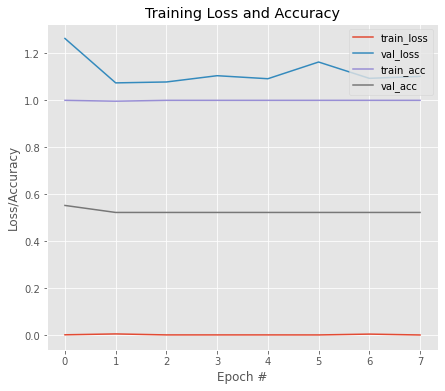


Model Performance Summary:

Best Validation accuracy:0.5522388219833374 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 5.8694e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.56716, saving model to MobileNetV2_b_4.hdf5
9/9 [==============================] - 10s 308ms/step - loss: 5.8694e-04 - accuracy: 1.0000 - val_loss: 1.3405 - val_accuracy: 0.5672
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.56716
9/9 [==============================] - 2s 171ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0376 - val_accuracy: 0.5224
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 8.6354e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.56716
9/9 [==============================] - 2s 177ms/step - loss: 8.6354e-04 - accuracy: 1.0000 - val_loss: 1.1602 - val_accuracy: 0.5373
Epoch 4/50
9/9 [============================

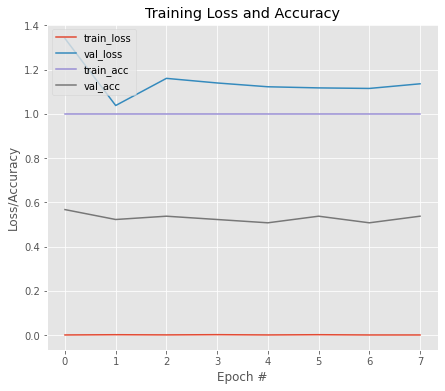


Model Performance Summary:

Best Validation accuracy:0.5671641826629639 at EPOCH:1
Average Accuracy:0.6840210676193237
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.5753 - accuracy: 0.6991
Epoch 1: val_accuracy improved from -inf to 0.66438, saving model to MobileNetV2_wt.hdf5
11/11 [==============================] - 4s 158ms/step - loss: 0.5753 - accuracy: 0.6991 - val_loss: 0.5969 - val_accuracy: 0.6644
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.6991
Epoch 2: val_accuracy improved from 0.66438 to 0.67123, saving model to MobileNetV2_wt.hdf5
11/11 [==============================] - 1s 70ms/step - loss: 0.5653 - accuracy: 0.6991 - val_loss: 0.5884 - val_accuracy: 0.6712
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.5592 - accuracy: 0.7050
Epoch 3: val_accuracy did not improve from 0.67123
11/11 [======================

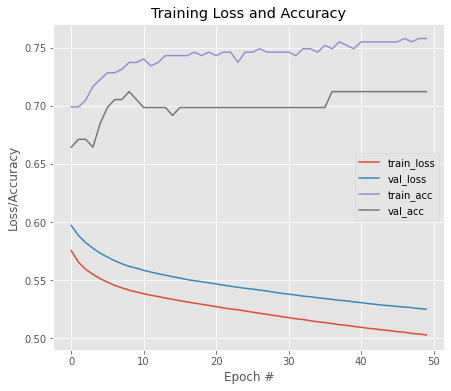


Model Performance Summary:

Best Validation accuracy:0.7123287916183472 at EPOCH:9
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.4969 - accuracy: 0.7581
Epoch 1: val_accuracy improved from -inf to 0.64384, saving model to MobileNetV2_wt.hdf5
11/11 [==============================] - 10s 296ms/step - loss: 0.4969 - accuracy: 0.7581 - val_loss: 0.6140 - val_accuracy: 0.6438
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8997
Epoch 2: val_accuracy did not improve from 0.64384
11/11 [==============================] - 2s 177ms/step - loss: 0.3250 - accuracy: 0.8997 - val_loss: 0.6255 - val_accuracy: 0.6301
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.9351
Epoch 3: val_accuracy improved from 0.64384 to 0.65068, saving model to MobileNetV2_wt.hdf5
11/11 [==============================] - 2s 211ms/step - loss: 0.2480 - accuracy: 0.9351 - v

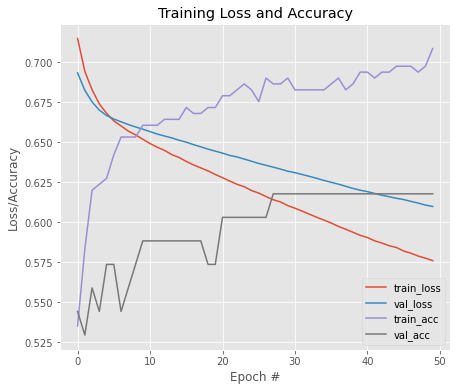


Model Performance Summary:

Best Validation accuracy:0.6176470518112183 at EPOCH:28
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.6753
Epoch 1: val_accuracy improved from -inf to 0.66176, saving model to InceptionV3_b_0.hdf5
9/9 [==============================] - 15s 456ms/step - loss: 0.6239 - accuracy: 0.6753 - val_loss: 0.6496 - val_accuracy: 0.6618
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.8708
Epoch 2: val_accuracy did not improve from 0.66176
9/9 [==============================] - 2s 169ms/step - loss: 0.4286 - accuracy: 0.8708 - val_loss: 0.6898 - val_accuracy: 0.6471
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.9483
Epoch 3: val_accuracy did not improve from 0.66176
9/9 [==============================] - 2s 169ms/step - loss: 0.3380 - accuracy: 0.9483 - val_loss: 0.6782 - val_accuracy: 0.6471
Epoch 4/50
9/9 [==============================] - ETA: 0s -

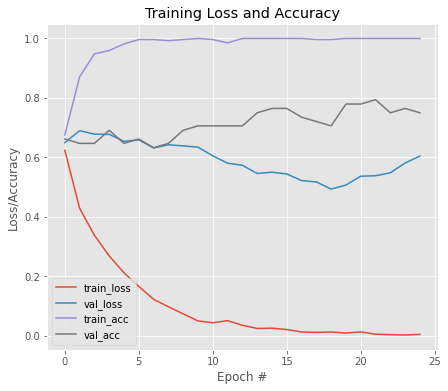


Model Performance Summary:

Best Validation accuracy:0.7941176295280457 at EPOCH:22
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9594
Epoch 1: val_accuracy improved from -inf to 0.88235, saving model to InceptionV3_a_1.hdf5
9/9 [==============================] - 14s 422ms/step - loss: 0.0839 - accuracy: 0.9594 - val_loss: 0.2231 - val_accuracy: 0.8824
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9889
Epoch 2: val_accuracy improved from 0.88235 to 0.92647, saving model to InceptionV3_a_1.hdf5
9/9 [==============================] - 2s 274ms/step - loss: 0.0295 - accuracy: 0.9889 - val_loss: 0.1724 - val_accuracy: 0.9265
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9926
Epoch 3: val_accuracy did not improve from 0.92647
9/9 [==============================] - 2s 169ms/step - loss: 0.0162 - accuracy: 0.9926 - val_loss: 0.1561 - val_accuracy: 0.9118
E

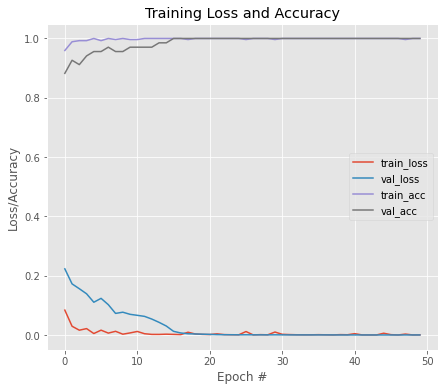


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:16
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionV3_b_1.hdf5
9/9 [==============================] - 14s 406ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 9.1760e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 168ms/step - loss: 9.1760e-04 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 167ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 

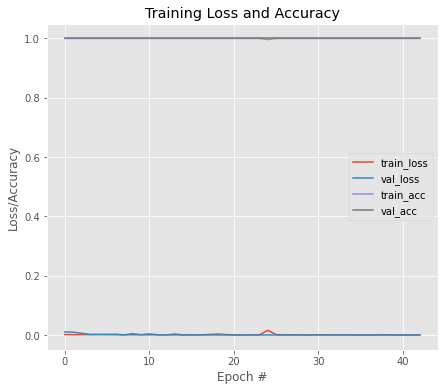


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 2.2405e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionV3_a_2.hdf5
9/9 [==============================] - 14s 405ms/step - loss: 2.2405e-04 - accuracy: 1.0000 - val_loss: 2.3690e-04 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9926
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 169ms/step - loss: 0.0115 - accuracy: 0.9926 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 9.0206e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 177ms/step - loss: 9.0206e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 4/50
9/9 [=======================

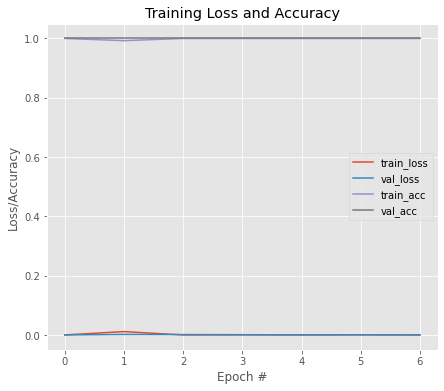


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 1.0041e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionV3_b_2.hdf5
9/9 [==============================] - 15s 416ms/step - loss: 1.0041e-04 - accuracy: 1.0000 - val_loss: 4.4431e-05 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 2.0090e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 170ms/step - loss: 2.0090e-04 - accuracy: 1.0000 - val_loss: 5.7685e-05 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000    
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 170ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.3927e-04 - val_accuracy: 1.0000
Epoch 4/50
9/9 [===========================

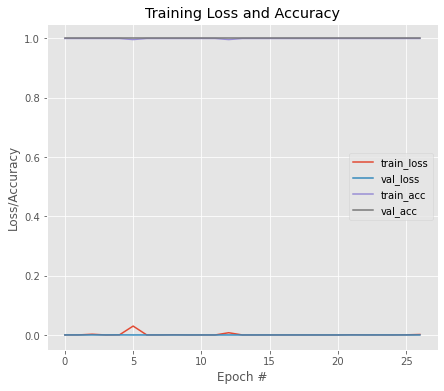


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 3.5451e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionV3_a_3.hdf5
9/9 [==============================] - 14s 405ms/step - loss: 3.5451e-04 - accuracy: 1.0000 - val_loss: 4.3809e-05 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 9.5294e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 169ms/step - loss: 9.5294e-04 - accuracy: 1.0000 - val_loss: 1.6606e-05 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 168ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2.5835e-05 - val_accuracy: 1.0000
Epoch 4/50
9/9 [===============

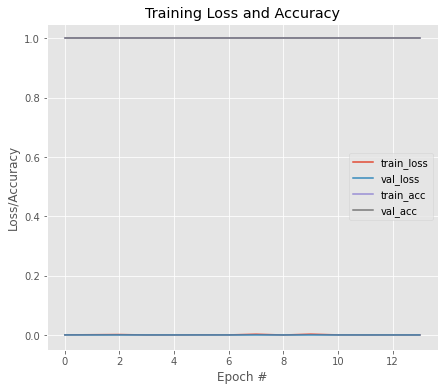


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 2.7628e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionV3_b_3.hdf5
9/9 [==============================] - 15s 488ms/step - loss: 2.7628e-05 - accuracy: 1.0000 - val_loss: 2.9441e-05 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 1.2535e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 169ms/step - loss: 1.2535e-04 - accuracy: 1.0000 - val_loss: 1.8117e-05 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 2.6194e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 169ms/step - loss: 2.6194e-05 - accuracy: 1.0000 - val_loss: 1.3766e-05 - val_accuracy: 1.0000
Epoch 4/50
9/9 [=======================

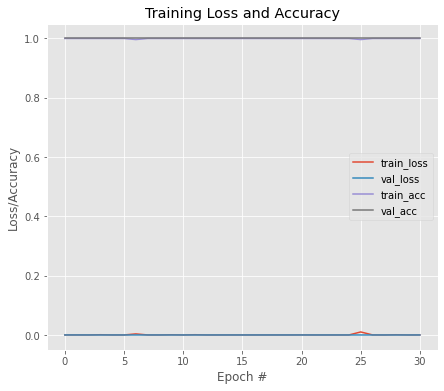


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 1.7960e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionV3_a_4.hdf5
9/9 [==============================] - 15s 506ms/step - loss: 1.7960e-04 - accuracy: 1.0000 - val_loss: 3.0549e-06 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 2.0508e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 166ms/step - loss: 2.0508e-05 - accuracy: 1.0000 - val_loss: 3.5069e-06 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9926
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 167ms/step - loss: 0.0079 - accuracy: 0.9926 - val_loss: 5.1882e-06 - val_accuracy: 1.0000
Epoch 4/50
9/9 [===============

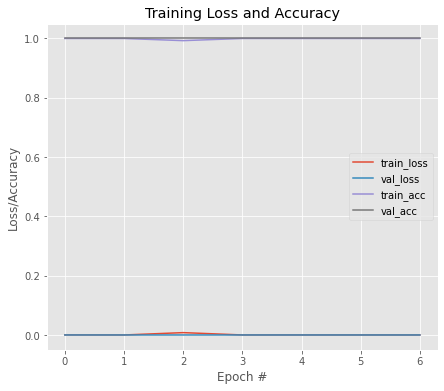


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 3.2500e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionV3_b_4.hdf5
9/9 [==============================] - 14s 410ms/step - loss: 3.2500e-05 - accuracy: 1.0000 - val_loss: 5.5494e-06 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 2.0072e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 171ms/step - loss: 2.0072e-05 - accuracy: 1.0000 - val_loss: 3.1350e-06 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 2s 177ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 6.0796e-06 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================]

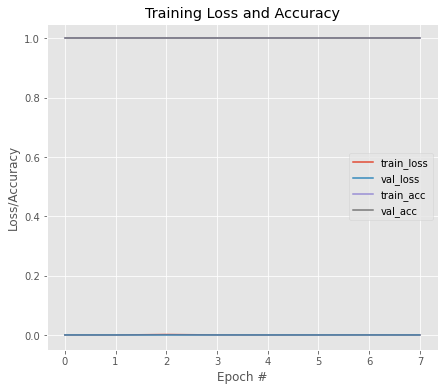


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Average Accuracy:0.9588235259056092
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.85616, saving model to InceptionV3_wt.hdf5
11/11 [==============================] - 7s 296ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.4474 - val_accuracy: 0.8562
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.85616 to 0.86301, saving model to InceptionV3_wt.hdf5
11/11 [==============================] - 1s 124ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.4418 - val_accuracy: 0.8630
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.86301
11/11 [==============================] - 1s

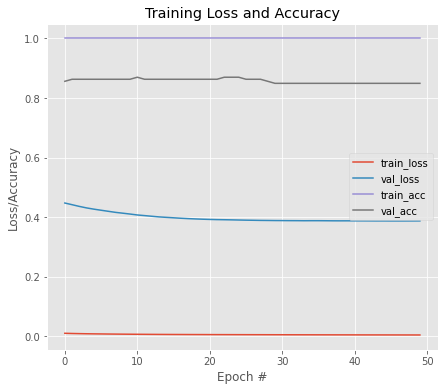


Model Performance Summary:

Best Validation accuracy:0.8698630332946777 at EPOCH:11
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 6.6084e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.84932, saving model to InceptionV3_wt.hdf5
11/11 [==============================] - 15s 416ms/step - loss: 6.6084e-04 - accuracy: 1.0000 - val_loss: 0.3938 - val_accuracy: 0.8493
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.84932
11/11 [==============================] - 2s 179ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.5124 - val_accuracy: 0.8425
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.84932
11/11 [==============================] - 2s 177ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.5295 - val_accuracy: 

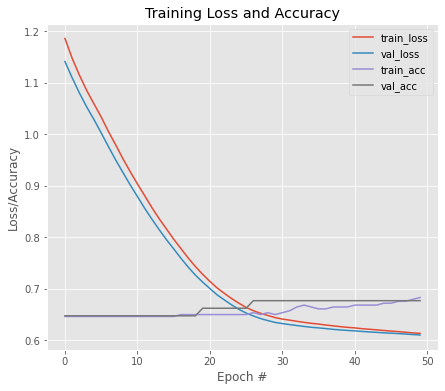


Model Performance Summary:

Best Validation accuracy:0.6764705777168274 at EPOCH:27
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.7157 - accuracy: 0.4834
Epoch 1: val_accuracy improved from -inf to 0.66176, saving model to InceptionResNetV2_b_0.hdf5
9/9 [==============================] - 39s 1s/step - loss: 0.7157 - accuracy: 0.4834 - val_loss: 0.6378 - val_accuracy: 0.6618
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.7675
Epoch 2: val_accuracy improved from 0.66176 to 0.67647, saving model to InceptionResNetV2_b_0.hdf5
9/9 [==============================] - 5s 598ms/step - loss: 0.5558 - accuracy: 0.7675 - val_loss: 0.6129 - val_accuracy: 0.6765
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.8708
Epoch 3: val_accuracy improved from 0.67647 to 0.69118, saving model to InceptionResNetV2_b_0.hdf5
9/9 [==============================] - 5s 598ms/step - loss: 0.4578 - accuracy: 0.8708 - 

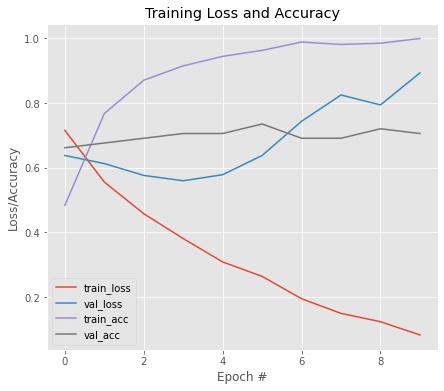


Model Performance Summary:

Best Validation accuracy:0.7352941036224365 at EPOCH:6
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9779
Epoch 1: val_accuracy improved from -inf to 0.63235, saving model to InceptionResNetV2_a_1.hdf5
9/9 [==============================] - 38s 973ms/step - loss: 0.1244 - accuracy: 0.9779 - val_loss: 1.9841 - val_accuracy: 0.6324
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.9852
Epoch 2: val_accuracy did not improve from 0.63235
9/9 [==============================] - 3s 371ms/step - loss: 0.0786 - accuracy: 0.9852 - val_loss: 2.3801 - val_accuracy: 0.6324
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.63235
9/9 [==============================] - 3s 369ms/step - loss: 0.0526 - accuracy: 1.0000 - val_loss: 2.8338 - val_accuracy: 0.6324
Epoch 4/50
9/9 [======================

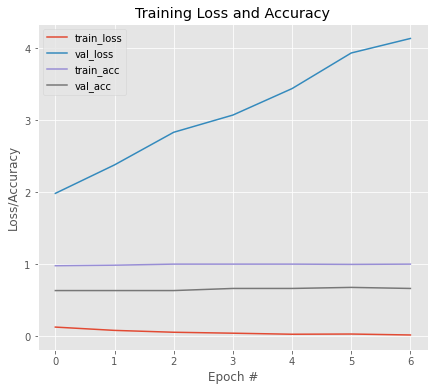


Model Performance Summary:

Best Validation accuracy:0.6764705777168274 at EPOCH:6
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.67647, saving model to InceptionResNetV2_b_1.hdf5
9/9 [==============================] - 37s 1000ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 3.3190 - val_accuracy: 0.6765
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.67647
9/9 [==============================] - 3s 387ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 3.5725 - val_accuracy: 0.6765
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.67647 to 0.70588, saving model to InceptionResNetV2_b_1.hdf5
9/9 [==============================] - 5s 600ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 3.7332 - val_accuracy: 0.7059
Epoch

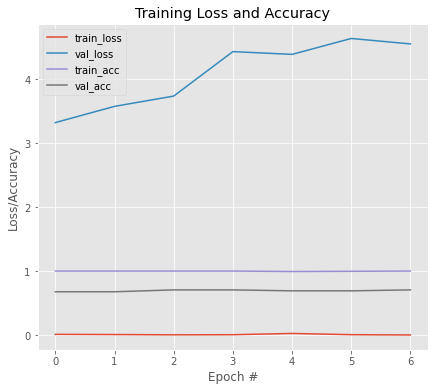


Model Performance Summary:

Best Validation accuracy:0.7058823704719543 at EPOCH:3
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to InceptionResNetV2_a_2.hdf5
9/9 [==============================] - 37s 972ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 3.3084 - val_accuracy: 0.7500
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.75000 to 0.79412, saving model to InceptionResNetV2_a_2.hdf5
9/9 [==============================] - 6s 743ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 3.5089 - val_accuracy: 0.7941
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.79412
9/9 [==============================] - 3s 368ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.6022 - val_accurac

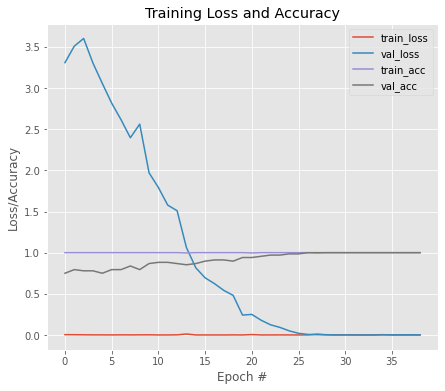


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:27
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 3.0484e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionResNetV2_b_2.hdf5
9/9 [==============================] - 40s 1s/step - loss: 3.0484e-04 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 2.7887e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 3s 372ms/step - loss: 2.7887e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.2390e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 3s 370ms/step - loss: 1.2390e-04 - accuracy: 1.0000 - val_loss: 4.8638e-04 - val_accuracy: 1.0000
Epoch 4/50
9/9 [===========================

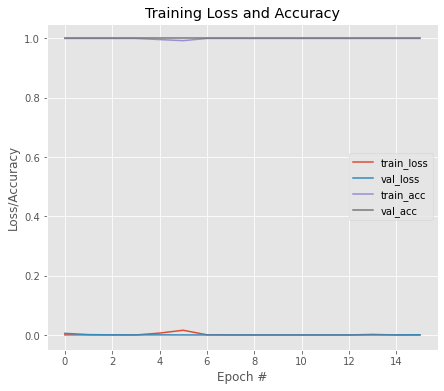


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 5.5871e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.98529, saving model to InceptionResNetV2_a_3.hdf5
9/9 [==============================] - 37s 981ms/step - loss: 5.5871e-05 - accuracy: 1.0000 - val_loss: 0.4634 - val_accuracy: 0.9853
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 6.4161e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.98529
9/9 [==============================] - 3s 370ms/step - loss: 6.4161e-05 - accuracy: 1.0000 - val_loss: 0.4155 - val_accuracy: 0.9853
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 2.8603e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.98529
9/9 [==============================] - 3s 370ms/step - loss: 2.8603e-05 - accuracy: 1.0000 - val_loss: 0.3314 - val_accuracy: 0.9853
Epoch 4/50
9/9 [=============

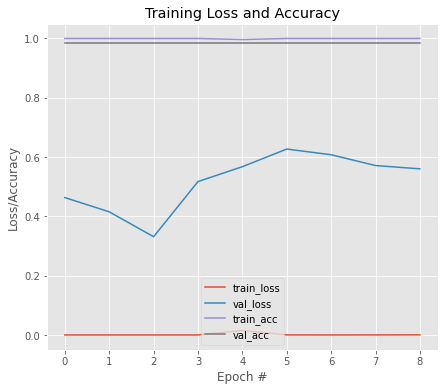


Model Performance Summary:

Best Validation accuracy:0.9852941036224365 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 7.8726e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.98529, saving model to InceptionResNetV2_b_3.hdf5
9/9 [==============================] - 38s 1s/step - loss: 7.8726e-04 - accuracy: 1.0000 - val_loss: 0.3821 - val_accuracy: 0.9853
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9963
Epoch 2: val_accuracy did not improve from 0.98529
9/9 [==============================] - 3s 369ms/step - loss: 0.0038 - accuracy: 0.9963 - val_loss: 0.3965 - val_accuracy: 0.9853
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.2124e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.98529
9/9 [==============================] - 3s 367ms/step - loss: 1.2124e-04 - accuracy: 1.0000 - val_loss: 0.3642 - val_accuracy: 0.9853
Epoch 4/50
9/9 [=========================

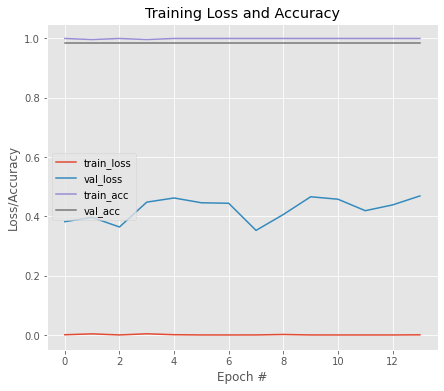


Model Performance Summary:

Best Validation accuracy:0.9852941036224365 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9926
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionResNetV2_a_4.hdf5
9/9 [==============================] - 37s 1s/step - loss: 0.0240 - accuracy: 0.9926 - val_loss: 3.6018e-05 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 8.3610e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 3s 385ms/step - loss: 8.3610e-04 - accuracy: 1.0000 - val_loss: 3.5676e-05 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 4.0624e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 3s 369ms/step - loss: 4.0624e-04 - accuracy: 1.0000 - val_loss: 3.1046e-05 - val_accuracy: 1.0000
Epoch 4/50
9/

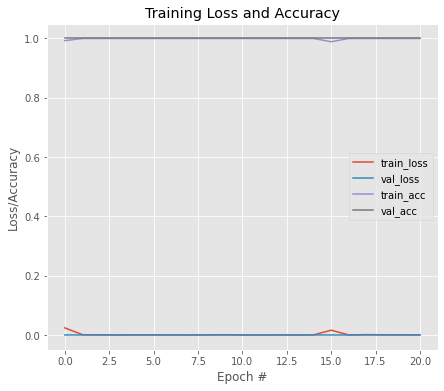


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 7.4784e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to InceptionResNetV2_b_4.hdf5
9/9 [==============================] - 39s 1s/step - loss: 7.4784e-05 - accuracy: 1.0000 - val_loss: 3.1476e-05 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 4.7991e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 3s 371ms/step - loss: 4.7991e-05 - accuracy: 1.0000 - val_loss: 1.7729e-05 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.6910e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 3s 384ms/step - loss: 1.6910e-04 - accuracy: 1.0000 - val_loss: 2.5799e-05 - val_accuracy: 1.0000
Epoch 4/50
9/9 [====================

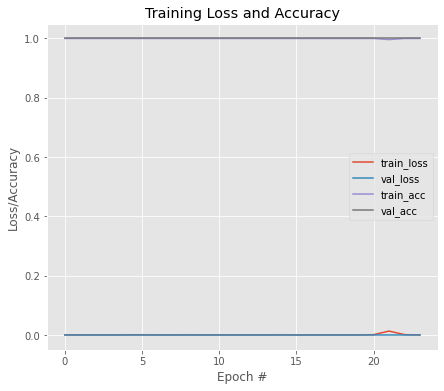


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Average Accuracy:0.8852941155433655
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.9823
Epoch 1: val_accuracy improved from -inf to 0.81507, saving model to InceptionResNetV2_wt.hdf5
11/11 [==============================] - 15s 609ms/step - loss: 0.1364 - accuracy: 0.9823 - val_loss: 1.7879 - val_accuracy: 0.8151
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9823
Epoch 2: val_accuracy did not improve from 0.81507
11/11 [==============================] - 2s 166ms/step - loss: 0.1345 - accuracy: 0.9823 - val_loss: 1.7662 - val_accuracy: 0.8151
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9823
Epoch 3: val_accuracy improved from 0.81507 to 0.82192, saving model to InceptionResNetV2_wt.hdf5
11/11 [=======================

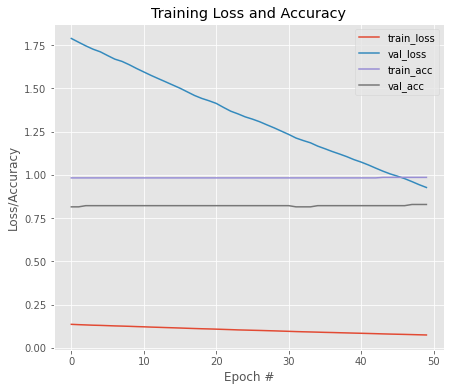


Model Performance Summary:

Best Validation accuracy:0.8287671208381653 at EPOCH:48
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.1722e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.82192, saving model to InceptionResNetV2_wt.hdf5
11/11 [==============================] - 38s 918ms/step - loss: 1.1722e-04 - accuracy: 1.0000 - val_loss: 1.3435 - val_accuracy: 0.8219
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9971
Epoch 2: val_accuracy did not improve from 0.82192
11/11 [==============================] - 4s 396ms/step - loss: 0.0262 - accuracy: 0.9971 - val_loss: 1.6658 - val_accuracy: 0.7740
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.82192
11/11 [==============================] - 4s 395ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.4105 - val_accu

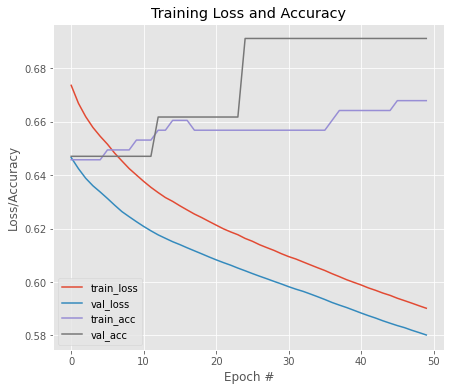


Model Performance Summary:

Best Validation accuracy:0.6911764740943909 at EPOCH:25
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6251 - accuracy: 0.6974
Epoch 1: val_accuracy improved from -inf to 0.67647, saving model to xception_b_0.hdf5
9/9 [==============================] - 13s 596ms/step - loss: 0.6251 - accuracy: 0.6974 - val_loss: 0.5759 - val_accuracy: 0.6765
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.7934
Epoch 2: val_accuracy did not improve from 0.67647
9/9 [==============================] - 4s 391ms/step - loss: 0.5328 - accuracy: 0.7934 - val_loss: 0.5570 - val_accuracy: 0.6618
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.8635
Epoch 3: val_accuracy did not improve from 0.67647
9/9 [==============================] - 4s 390ms/step - loss: 0.4822 - accuracy: 0.8635 - val_loss: 0.5427 - val_accuracy: 0.6618
Epoch 4/50
9/9 [==============================] - ETA: 0s - lo

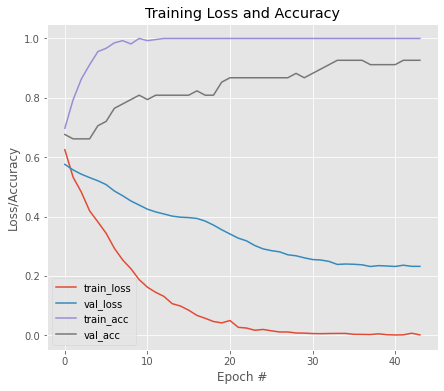


Model Performance Summary:

Best Validation accuracy:0.9264705777168274 at EPOCH:34
Starting fold 1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9779
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to xception_a_1.hdf5
9/9 [==============================] - 13s 547ms/step - loss: 0.0728 - accuracy: 0.9779 - val_loss: 2.2221e-04 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9926
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 389ms/step - loss: 0.0153 - accuracy: 0.9926 - val_loss: 2.2042e-04 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 390ms/step - loss: 0.0137 - accuracy: 0.9963 - val_loss: 2.2116e-04 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==================

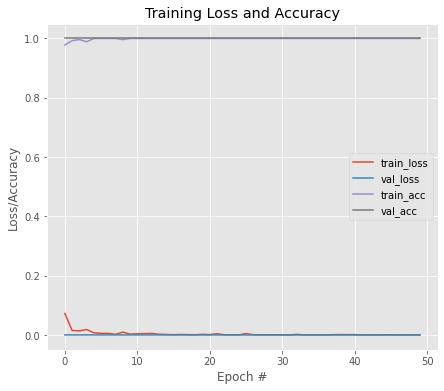


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9926
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to xception_b_1.hdf5
9/9 [==============================] - 13s 548ms/step - loss: 0.0180 - accuracy: 0.9926 - val_loss: 2.0176e-04 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 389ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 2.1943e-04 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 413ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 2.0609e-04 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 

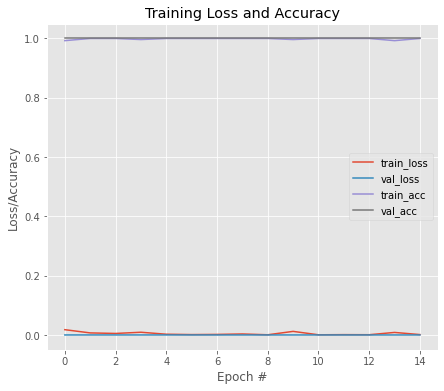


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 2
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to xception_a_2.hdf5
9/9 [==============================] - 13s 556ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.3981e-04 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 388ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.2920e-04 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 7.3820e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 390ms/step - loss: 7.3820e-04 - accuracy: 1.0000 - val_loss: 1.1813e-04 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==========================

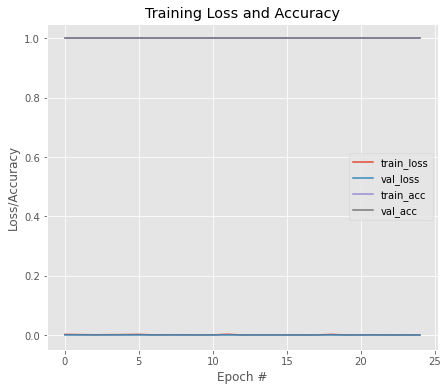


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 4.7637e-04 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to xception_b_2.hdf5
9/9 [==============================] - 13s 637ms/step - loss: 4.7637e-04 - accuracy: 1.0000 - val_loss: 1.0928e-04 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 3.7412e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 391ms/step - loss: 3.7412e-04 - accuracy: 1.0000 - val_loss: 9.1618e-05 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 391ms/step - loss: 0.0055 - accuracy: 0.9963 - val_loss: 8.9153e-05 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - 

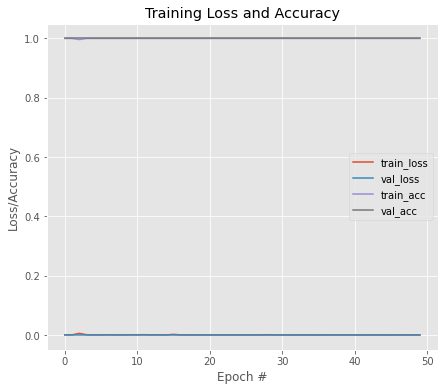


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 3
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 4.1833e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to xception_a_3.hdf5
9/9 [==============================] - 12s 549ms/step - loss: 4.1833e-05 - accuracy: 1.0000 - val_loss: 3.1678e-06 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 1.7140e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 413ms/step - loss: 1.7140e-05 - accuracy: 1.0000 - val_loss: 3.0451e-06 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 390ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 3.3922e-06 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==================

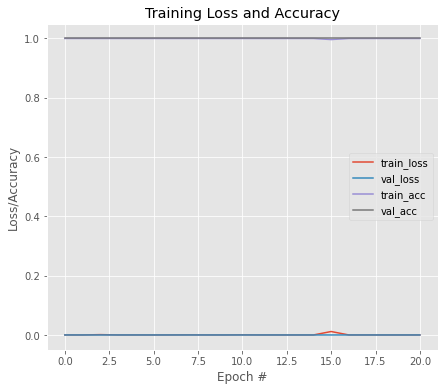


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 3.4014e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to xception_b_3.hdf5
9/9 [==============================] - 12s 550ms/step - loss: 3.4014e-05 - accuracy: 1.0000 - val_loss: 3.6096e-06 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 6.5845e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 411ms/step - loss: 6.5845e-04 - accuracy: 1.0000 - val_loss: 3.4781e-06 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 3.4130e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 391ms/step - loss: 3.4130e-05 - accuracy: 1.0000 - val_loss: 3.4255e-06 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==========================

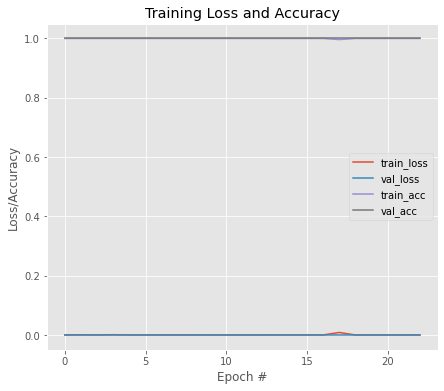


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Starting fold 4
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 2.6126e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to xception_a_4.hdf5
9/9 [==============================] - 13s 632ms/step - loss: 2.6126e-05 - accuracy: 1.0000 - val_loss: 3.0336e-06 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 6.0003e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 415ms/step - loss: 6.0003e-05 - accuracy: 1.0000 - val_loss: 2.2223e-06 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.3802e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 393ms/step - loss: 1.3802e-05 - accuracy: 1.0000 - val_loss: 2.1511e-06 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==========

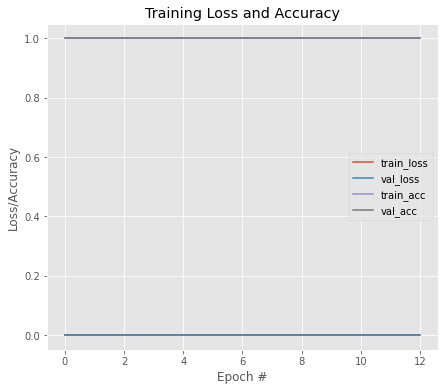


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 3.3282e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to xception_b_4.hdf5
9/9 [==============================] - 12s 550ms/step - loss: 3.3282e-05 - accuracy: 1.0000 - val_loss: 2.2507e-06 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 9.0169e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 389ms/step - loss: 9.0169e-05 - accuracy: 1.0000 - val_loss: 2.2507e-06 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 2.7547e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
9/9 [==============================] - 4s 411ms/step - loss: 2.7547e-05 - accuracy: 1.0000 - val_loss: 2.1725e-06 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==========================

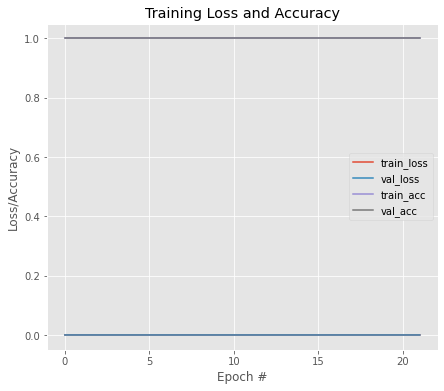


Model Performance Summary:

Best Validation accuracy:1.0 at EPOCH:1
Average Accuracy:0.9852941155433654
 Training Model on full dataset
 Training Model with pretraned layer frozen
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.88356, saving model to xception_wt.hdf5
11/11 [==============================] - 5s 263ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.3188 - val_accuracy: 0.8836
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.88356 to 0.89041, saving model to xception_wt.hdf5
11/11 [==============================] - 2s 154ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.3178 - val_accuracy: 0.8904
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.89041
11/11 [==============================] - 1s 117ms

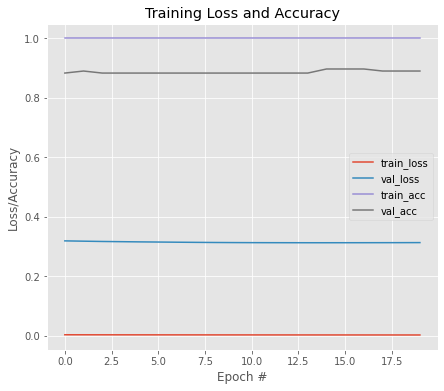


Model Performance Summary:

Best Validation accuracy:0.8972602486610413 at EPOCH:15
 Training Model with pretraned layer trainable
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.88356, saving model to xception_wt.hdf5
11/11 [==============================] - 14s 574ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.3615 - val_accuracy: 0.8836
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.88356 to 0.89041, saving model to xception_wt.hdf5
11/11 [==============================] - 5s 470ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.3529 - val_accuracy: 0.8904
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.89041
11/11 [==============================] - 5s 410ms/step - loss: 0.0014 - accuracy: 1.0000 - val_lo

In [ ]:

for model in MODEL_LIST:

  model_obj = HIGH_LEVEL_MODEL(model)
  model_obj.train_phase(training_images,training_label,test_images,test_label,data_aug=False)

Model  Accuracy  Sensitivity       AUC
0                       vgg16  0.938356     0.989362  0.917758
1                       vgg19  0.924658     0.936170  0.920008
2                    resnet50  0.643836     1.000000  0.500000
3                 DenseNet121  0.931507     0.914894  0.938216
4                   MobileNet  0.938356     0.936170  0.939239
5                 InceptionV3  0.890411     0.957447  0.863339
6           InceptionResNetV2  0.904110     0.925532  0.895458
7                 MobileNetV2  0.773973     0.925532  0.712766
8                    xception  0.917808     0.957447  0.901800
9               vgg16_A_False  0.897260     0.957447  0.872954
10              vgg19_A_False  0.876712     0.872340  0.878478
11           resnet50_A_False  0.643836     1.000000  0.500000
12        DenseNet121_A_False  0.890411     0.904255  0.884820
13          MobileNet_A_False  0.890411     0.904255  0.884820
14        MobileNetV2_A_False  0.760274     0.861702  0.719313
15        InceptionV3_A_False  0.849315     0.840426  0.852905
16  InceptionResNetV2_A_False  0.842466     0.872340  0.830401
17           xception_A_False  0.890411     0.936170  0.871931

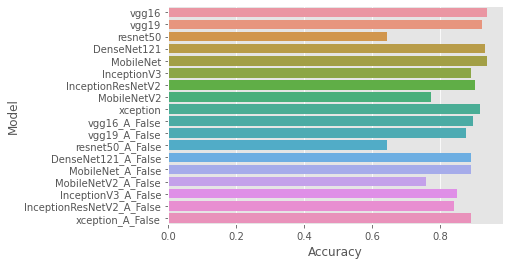

\begin{tabular}{lrrr}
\toprule
                    Model &  Accuracy &  Sensitivity &      AUC \\
\midrule
                    vgg16 &  0.938356 &     0.989362 & 0.917758 \\
                    vgg19 &  0.924658 &     0.936170 & 0.920008 \\
                 resnet50 &  0.643836 &     1.000000 & 0.500000 \\
              DenseNet121 &  0.931507 &     0.914894 & 0.938216 \\
                MobileNet &  0.938356 &     0.936170 & 0.939239 \\
              InceptionV3 &  0.890411 &     0.957447 & 0.863339 \\
        InceptionResNetV2 &  0.904110 &     0.925532 & 0.895458 \\
              MobileNetV2 &  0.773973 &     0.925532 & 0.712766 \\
                 xception &  0.917808 &     0.957447 & 0.901800 \\
            vgg16\_A\_False &  0.897260 &     0.957447 & 0.872954 \\
            vgg19\_A\_False &  0.876712 &     0.872340 & 0.878478 \\
         resnet50\_A\_False &  0.643836 &     1.000000 & 0.500000 \\
      DenseNet121\_A\_False &  0.890411 &     0.904255 & 0.884820 \\
        Mobile

In [ ]:
plot_overall_performance()